We want to find the total spin eigenfunctions of a $3$-spins system using the **VQE** algorithm and a selected **cost function**.

In [1]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.state_fns        import StateFn
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state


In [3]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

#### Definition of spin operators: $\hat{S}_x$, $\hat{S}_y$, $\hat{S}_z$, $\hat{S}^2$

In [4]:
sx=[]
for i in range (3):
    sx.append((1.0/2.,generate_pauli([i],[],3)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (3):
    sy.append((1.0/2.,generate_pauli([i],[i],3)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (3):
    sz.append((1.0/2.,generate_pauli([],[i],3)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
#print("S2 operator")
#print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIX	(0.5+0j)
IXI	(0.5+0j)
XII	(0.5+0j)

Sy operator
IIY	(0.5+0j)
IYI	(0.5+0j)
YII	(0.5+0j)

Sz operator
IIZ	(0.5+0j)
IZI	(0.5+0j)
ZII	(0.5+0j)



 #### Definition of the left spin operator: $\hat{S}_L^2$

In [5]:
slx=[]
for i in range (2):
    slx.append((1.0/2.,generate_pauli([i],[],3)))
slx=WeightedPauliOperator(slx)
print("Slx operator")
print(slx.print_details())
mat_slx=op_converter.to_matrix_operator(slx).dense_matrix
#print("Slx operator matrix")
#print(mat_slx)

sly=[]
for i in range (2):
    sly.append((1.0/2.,generate_pauli([i],[i],3)))
sly=WeightedPauliOperator(sly)
print("Sly operator")
print(sly.print_details())
mat_sly=op_converter.to_matrix_operator(sly).dense_matrix
#print("Sly operator matrix")
#print(mat_lsy)

slz=[]
for i in range (2):
    slz.append((1.0/2.,generate_pauli([],[i],3)))
slz=WeightedPauliOperator(slz)
print("Slz operator")
print(slz.print_details())
mat_slz=op_converter.to_matrix_operator(slz).dense_matrix
#print("Slz operator matrix")
#print(mat_slz)

sl2=np.dot(slx,slx)+np.dot(sly,sly)+np.dot(slz,slz)
print("Sl2 operator")
print(sl2.print_details())
mat_sl2=op_converter.to_matrix_operator(sl2).dense_matrix
#print("Sl2 operator matrix")
#print(mat_sl2)

Slx operator
IIX	(0.5+0j)
IXI	(0.5+0j)

Sly operator
IIY	(0.5+0j)
IYI	(0.5+0j)

Slz operator
IIZ	(0.5+0j)
IZI	(0.5+0j)

Sl2 operator
III	(1.5+0j)
IXX	(0.5+0j)
IYY	(0.5+0j)
IZZ	(0.5+0j)



# RY Variational Quantum Eigensolver (VQE) for $3$ spins

We want to use VQE with the RY variational form. This aim can be reached by using the $\textbf{RealAmplitudes}$ class. We want to study the total spin eigenfunctions of $3$ spins by using the **find_minimum** method of the **VQE** algorithm.

In [6]:
# Algorithm execution

# 1. On classical computer WITHOUT statistical uncertainties, namely (Psi|H|Psi) algebraically evaluated
backend_1          = Aer.get_backend('statevector_simulator') # <----
quantum_instance_1 = QuantumInstance(backend=backend_1)

# 2. On classical computer WITH statistical uncertainties and hopefully decoherence model
backend_2          = Aer.get_backend('qasm_simulator') # <---- (Psi|H|Psi) sampled
quantum_instance_2 = QuantumInstance(backend=backend_2,shots=8000)

# 3. On quantum computer ...

2021-06-20 12:55:36,190:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2021-06-20 12:55:36,192:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2021-06-20 12:55:36,209:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'qasm_si

We select as **Initial state**: $\psi_1=|0\rangle^{\otimes 5}$

## Depth = 0

Here we insert the values of the optimal cost value for each of the total spin eigenfunctions at the end of the algorithm execution.

In [7]:
cost_conv=[[] for i in range(4)]

In [8]:
psi_1   = Zero(3)                            # tensor product of zeros: |0)|0)|0)
#psi_1_c = psi_1.construct_circuit()
#display(Markdown(r"Initial state $\psi_1=|0\rangle^{\otimes 5}$"))
#print(psi_1_c.draw())

qr=QuantumRegister(3,'q')
qc=QuantumCircuit(qr)

th0=Parameter("th0")
th1=Parameter("th1")
th2=Parameter("th2")
qc.ry(th0,[0])
qc.ry(th1,[1])
qc.ry(th2,[2])

print(qc.draw())
RY_0=qc.to_gate(label="RY_0")
var_form=RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],skip_final_rotation_layer=True,insert_barriers=True,reps=1)

     ┌─────────┐
q_0: ┤ RY(th0) ├
     ├─────────┤
q_1: ┤ RY(th1) ├
     ├─────────┤
q_2: ┤ RY(th2) ├
     └─────────┘


In [9]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, qc, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-06-20 12:55:36,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fac1092f400>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fac1092f460>>
-- initial_point: Random seed
-- var_form:      ┌─────────┐
q_0: ┤ RY(th0) ├
     ├─────────┤
q_1: ┤ RY(th1) ├
     ├─────────┤
q_2: ┤ RY(th2) ├
     └─────────┘
-- var_form_params: [Parameter(th0), Parameter(th1), Parameter(th2)]
-- parameterized_circuits: None
-- ret: None
--

Optimizer: CG        

2021-06-20 12:55:36,538:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-06-20 12:55:36,539:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 3 operations with depth 1
op_counts: OrderedDict([('ry', 3)])

2021-06-20 12:55:36,540:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-06-20 12:55:36,541:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 3 operations with depth 1
op_counts: OrderedDict([('ry', 3)])

2021-06-20 12:55:36,544:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91593 (ms)
2021-06-20 12:55:37,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.55881985] - 1189.07213 (ms), eval count: 1
2021-06-20 12:55:37,484:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.66876 (ms)
2021-06-20 12:55:37,489:qiskit.aqua.algorithms.minimum_eigen_s

2021-06-20 12:55:37,913:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26171 (ms)
2021-06-20 12:55:37,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.5] - 4.72498 (ms), eval count: 29
2021-06-20 12:55:37,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.59676 (ms)
2021-06-20 12:55:37,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.5] - 5.90181 (ms), eval count: 30
2021-06-20 12:55:37,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50299 (ms)
2021-06-20 12:55:37,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.5] - 12.72917 (ms), eval count: 31
2021-06-20 12:55:37,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37403 (ms)
2021-06-20 12:55:37,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.5] - 

2021-06-20 12:55:38,279:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55108 (ms)
2021-06-20 12:55:38,291:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.21731164] - 14.27388 (ms), eval count: 2
2021-06-20 12:55:38,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.53978 (ms)
2021-06-20 12:55:38,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.21731164] - 6.33907 (ms), eval count: 3
2021-06-20 12:55:38,308:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99778 (ms)
2021-06-20 12:55:38,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.21731164] - 16.60800 (ms), eval count: 4
2021-06-20 12:55:38,343:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.48018 (ms)
2021-06-20 12:55:38,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluatio

optimal_parameters {Parameter(th0): 0.9805842029189904, Parameter(th1): 5.169374355524779, Parameter(th2): 3.07497920049345}
optimal_point [0.9805842  5.16937436 3.0749792 ]
optimal_value 1.5000000000000022
optimizer_evals 48
optimizer_time 1.9239158630371094
eigenvalue (1.5000000000000022+0j)
eigenstate [-0.0249385 +0.j -0.01331126+0.j  0.01552788+0.j  0.00828821+0.j
 -0.74847572+0.j -0.39950895+0.j  0.46603615+0.j  0.24875305+0.j]
cost_function_evals 48
Optimizer: L_BFGS_B        

2021-06-20 12:55:38,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73758411] - 14.88590 (ms), eval count: 10
2021-06-20 12:55:38,478:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.87190 (ms)
2021-06-20 12:55:38,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73758411] - 15.10572 (ms), eval count: 11
2021-06-20 12:55:38,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.85306 (ms)
2021-06-20 12:55:38,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73758411] - 5.97191 (ms), eval count: 12
2021-06-20 12:55:38,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.92816 (ms)
2021-06-20 12:55:38,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.72673608] - 11.62219 (ms), eval count: 13
2021-06-20 12:55:38,519:qiskit.aqua.operators.converter

2021-06-20 12:55:38,850:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.57220 (ms)
2021-06-20 12:55:38,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50051446] - 4.54402 (ms), eval count: 42
2021-06-20 12:55:38,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96607 (ms)
2021-06-20 12:55:38,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50051446] - 5.91803 (ms), eval count: 43
2021-06-20 12:55:38,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.87881 (ms)
2021-06-20 12:55:38,871:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50051446] - 6.86407 (ms), eval count: 44
2021-06-20 12:55:38,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.76795 (ms)
2021-06-20 12:55:38,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:55:39,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50000009] - 14.41598 (ms), eval count: 73
2021-06-20 12:55:39,226:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.91290 (ms)
2021-06-20 12:55:39,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50000009] - 11.83105 (ms), eval count: 74
2021-06-20 12:55:39,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29604 (ms)
2021-06-20 12:55:39,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50000009] - 46.58318 (ms), eval count: 75
2021-06-20 12:55:39,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.91910 (ms)
2021-06-20 12:55:39,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.50000009] - 36.49306 (ms), eval count: 76
2021-06-20 12:55:39,362:qiskit.aqua.operators.converte

optimal_parameters {Parameter(th0): 5.07480848672483, Parameter(th1): 7.1693910061676105, Parameter(th2): -3.302127047475516}
optimal_point [ 5.07480849  7.16939101 -3.30212705]
optimal_value 1.5000000825202162
optimizer_evals 84
optimizer_time 1.4124517440795898
eigenvalue (1.5000000825202162+0j)
eigenstate [-0.0596135 +0.j  0.04115139+0.j -0.02829117+0.j  0.01952949+0.j
 -0.74109251+0.j  0.51157859+0.j -0.35170519+0.j  0.24278324+0.j]
cost_function_evals 84


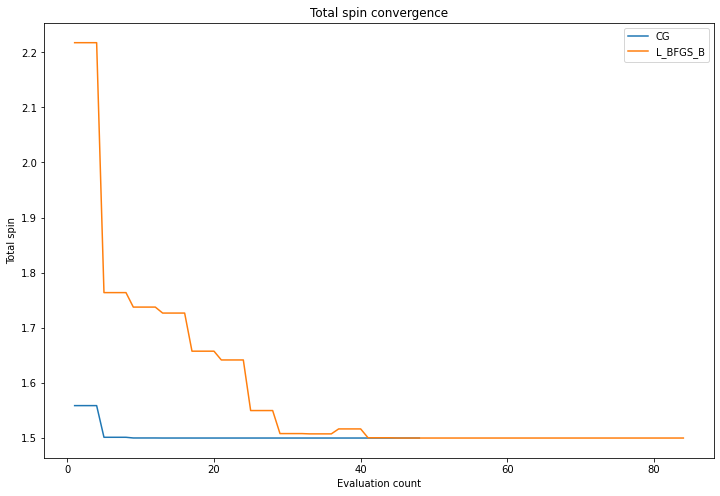

In [10]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

### Cost function for total spin selection

We want to use the **find_minimum** algorithm of **VQE** function to find the eigenstates of total spin $\hat{S}$ by using the following cost function:

$$C(s_L,s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

where the values inside the brackets are parameters which are used to select the total spin state we want to get (i.e. Barbara's classification)and the expectation values refer to the variational state which is created step by step during the optimization.

In [11]:
def spin_cost(v,l,J,M):
    l2=l*(l+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    return op1+op2+op3

In [12]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)        # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv[0].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-06-20 12:55:40,262:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[ 1.93731295 -1.20020482  3.72982113]
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary pa

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginar

## Depth =1

In [13]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=1)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├─░─┤ RY(θ[5]) ├
     └──────────┘ ░      └───┘ ░ └──────────┘


In [14]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-06-20 12:55:58,321:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fac11ca04c0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fac11ca03a0>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: 

2021-06-20 12:55:58,404:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.82207 (ms)
2021-06-20 12:55:58,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.9447863] - 5.78189 (ms), eval count: 8
2021-06-20 12:55:58,413:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.68593 (ms)
2021-06-20 12:55:58,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.9447863] - 4.92811 (ms), eval count: 9
2021-06-20 12:55:58,419:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74601 (ms)
2021-06-20 12:55:58,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.9447863] - 6.59299 (ms), eval count: 10
2021-06-20 12:55:58,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15800 (ms)
2021-06-20 12:55:58,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation re

Optimizer: CG        

2021-06-20 12:55:58,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.79146548] - 11.64198 (ms), eval count: 21
2021-06-20 12:55:58,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36902 (ms)
2021-06-20 12:55:58,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75636516] - 10.12778 (ms), eval count: 22
2021-06-20 12:55:58,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70605 (ms)
2021-06-20 12:55:58,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75636516] - 9.28688 (ms), eval count: 23
2021-06-20 12:55:58,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75078 (ms)
2021-06-20 12:55:58,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75636515] - 5.72419 (ms), eval count: 24
2021-06-20 12:55:58,543:qiskit.aqua.operators.converters

2021-06-20 12:55:58,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20592 (ms)
2021-06-20 12:55:58,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75214249] - 6.81400 (ms), eval count: 53
2021-06-20 12:55:58,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75006 (ms)
2021-06-20 12:55:58,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75214249] - 6.09303 (ms), eval count: 54
2021-06-20 12:55:58,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.73290 (ms)
2021-06-20 12:55:58,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75214249] - 5.27716 (ms), eval count: 55
2021-06-20 12:55:58,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74911 (ms)
2021-06-20 12:55:58,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:55:58,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75046371] - 5.31268 (ms), eval count: 84
2021-06-20 12:55:58,963:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13368 (ms)
2021-06-20 12:55:58,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75038959] - 6.00028 (ms), eval count: 85
2021-06-20 12:55:58,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96178 (ms)
2021-06-20 12:55:58,973:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75038959] - 4.03309 (ms), eval count: 86
2021-06-20 12:55:58,976:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88279 (ms)
2021-06-20 12:55:58,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75038959] - 7.50709 (ms), eval count: 87
2021-06-20 12:55:58,986:qiskit.aqua.operators.converters.c

2021-06-20 12:55:59,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001488] - 14.71591 (ms), eval count: 115
2021-06-20 12:55:59,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58923 (ms)
2021-06-20 12:55:59,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001488] - 10.06103 (ms), eval count: 116
2021-06-20 12:55:59,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.70000 (ms)
2021-06-20 12:55:59,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001488] - 19.61398 (ms), eval count: 117
2021-06-20 12:55:59,362:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03881 (ms)
2021-06-20 12:55:59,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001488] - 10.29396 (ms), eval count: 118
2021-06-20 12:55:59,370:qiskit.aqua.operators.conv

2021-06-20 12:55:59,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000103] - 6.42586 (ms), eval count: 146
2021-06-20 12:55:59,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34199 (ms)
2021-06-20 12:55:59,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000103] - 9.11999 (ms), eval count: 147
2021-06-20 12:55:59,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63493 (ms)
2021-06-20 12:55:59,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000073] - 10.35619 (ms), eval count: 148
2021-06-20 12:55:59,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.79012 (ms)
2021-06-20 12:55:59,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000073] - 5.22709 (ms), eval count: 149
2021-06-20 12:55:59,718:qiskit.aqua.operators.convert

2021-06-20 12:56:00,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 8.09717 (ms), eval count: 177
2021-06-20 12:56:00,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77893 (ms)
2021-06-20 12:56:00,066:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 15.91301 (ms), eval count: 178
2021-06-20 12:56:00,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14202 (ms)
2021-06-20 12:56:00,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 8.42714 (ms), eval count: 179
2021-06-20 12:56:00,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.84782 (ms)
2021-06-20 12:56:00,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 6.68693 (ms), eval count: 180
2021-06-20 12:56:00,088:qiskit.aqua.operators.convert

2021-06-20 12:56:00,413:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64812 (ms)
2021-06-20 12:56:00,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 15.55777 (ms), eval count: 209
2021-06-20 12:56:00,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.68402 (ms)
2021-06-20 12:56:00,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.45216 (ms), eval count: 210
2021-06-20 12:56:00,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16301 (ms)
2021-06-20 12:56:00,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.85897 (ms), eval count: 211
2021-06-20 12:56:00,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.92888 (ms)
2021-06-20 12:56:00,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0

2021-06-20 12:56:00,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.79107 (ms)
2021-06-20 12:56:00,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.54602 (ms), eval count: 241
2021-06-20 12:56:00,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75698 (ms)
2021-06-20 12:56:00,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.76782 (ms), eval count: 242
2021-06-20 12:56:00,713:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.90384 (ms)
2021-06-20 12:56:00,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.00281 (ms), eval count: 243
2021-06-20 12:56:00,719:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38109 (ms)
2021-06-20 12:56:00,724:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:00,937:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14298 (ms)
2021-06-20 12:56:00,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.94115 (ms), eval count: 273
2021-06-20 12:56:00,945:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01900 (ms)
2021-06-20 12:56:00,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.46598 (ms), eval count: 274
2021-06-20 12:56:00,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03498 (ms)
2021-06-20 12:56:00,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.67174 (ms), eval count: 275
2021-06-20 12:56:00,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.76318 (ms)
2021-06-20 12:56:00,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:01,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.82779 (ms)
2021-06-20 12:56:01,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.93400 (ms), eval count: 305
2021-06-20 12:56:01,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.92506 (ms)
2021-06-20 12:56:01,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.10216 (ms), eval count: 306
2021-06-20 12:56:01,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75507 (ms)
2021-06-20 12:56:01,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.49412 (ms), eval count: 307
2021-06-20 12:56:01,193:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74816 (ms)
2021-06-20 12:56:01,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:01,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44601 (ms)
2021-06-20 12:56:01,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.97400 (ms), eval count: 337
2021-06-20 12:56:01,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.64778 (ms)
2021-06-20 12:56:01,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.06496 (ms), eval count: 338
2021-06-20 12:56:01,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31774 (ms)
2021-06-20 12:56:01,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.97622 (ms), eval count: 339
2021-06-20 12:56:01,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43909 (ms)
2021-06-20 12:56:01,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:01,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40214 (ms)
2021-06-20 12:56:01,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.29489 (ms), eval count: 369
2021-06-20 12:56:01,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.77701 (ms)
2021-06-20 12:56:01,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.98605 (ms), eval count: 370
2021-06-20 12:56:01,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39403 (ms)
2021-06-20 12:56:01,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.21295 (ms), eval count: 371
2021-06-20 12:56:01,708:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25098 (ms)
2021-06-20 12:56:01,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:01,917:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98729 (ms)
2021-06-20 12:56:01,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.03714 (ms), eval count: 401
2021-06-20 12:56:01,922:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99587 (ms)
2021-06-20 12:56:01,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.28304 (ms), eval count: 402
2021-06-20 12:56:01,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72615 (ms)
2021-06-20 12:56:01,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.34503 (ms), eval count: 403
2021-06-20 12:56:01,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98896 (ms)
2021-06-20 12:56:01,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:02,022:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.26471467 -2.82853599  1.52924452 -1.95408205 -1.46957316  1.91358804]
2021-06-20 12:56:02,040:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-06-20 12:56:02,041:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 8 operations with depth 4
op_counts: OrderedDict([('ry', 6), ('barrier', 2), ('cx', 2)])

2021-06-20 12:56:02,043:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-06-20 12:56:02,045:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 8 operations with depth 4
op_counts: OrderedDict([

optimal_parameters {Parameter(θ[0]): -1.5707964185114323, Parameter(θ[1]): 2.0622265729391483e-07, Parameter(θ[2]): -1.570796055245999, Parameter(θ[3]): 0.940477091999042, Parameter(θ[4]): -2.201115304290865, Parameter(θ[5]): 1.9592853955679708}
optimal_point [-1.57079642e+00  2.06222657e-07 -1.57079606e+00  9.40477092e-01
 -2.20111530e+00  1.95928540e+00]
optimal_value 0.7500000000000089
optimizer_evals 413
optimizer_time 3.680150032043457
eigenvalue (0.7500000000000089+0j)
eigenstate [ 6.41923578e-09+0.j  6.93808743e-01+0.j -6.93808799e-01+0.j
  1.72097685e-07+0.j  8.03076394e-08+0.j  1.36489458e-01+0.j
 -1.36489584e-01+0.j -4.51888804e-08+0.j]
cost_function_evals 413
Optimizer: L_BFGS_B        

2021-06-20 12:56:02,215:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75102 (ms)
2021-06-20 12:56:02,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75011285] - 5.08213 (ms), eval count: 26
2021-06-20 12:56:02,221:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2021-06-20 12:56:02,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75011285] - 5.21302 (ms), eval count: 27
2021-06-20 12:56:02,227:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.77915 (ms)
2021-06-20 12:56:02,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75011285] - 5.09405 (ms), eval count: 28
2021-06-20 12:56:02,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.81420 (ms)
2021-06-20 12:56:02,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:56:02,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.92208 (ms), eval count: 57
2021-06-20 12:56:02,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07288 (ms)
2021-06-20 12:56:02,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 3.95083 (ms), eval count: 58
2021-06-20 12:56:02,440:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02925 (ms)
2021-06-20 12:56:02,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.89800 (ms), eval count: 59
2021-06-20 12:56:02,448:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01876 (ms)
2021-06-20 12:56:02,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.39796 (ms), eval count: 60
2021-06-20 12:56:02,455:qiskit.aqua.operators.converters.c

2021-06-20 12:56:02,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95296 (ms)
2021-06-20 12:56:02,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.99105 (ms), eval count: 89
2021-06-20 12:56:02,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96607 (ms)
2021-06-20 12:56:02,661:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.21095 (ms), eval count: 90
2021-06-20 12:56:02,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26290 (ms)
2021-06-20 12:56:02,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.42092 (ms), eval count: 91
2021-06-20 12:56:02,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30582 (ms)
2021-06-20 12:56:02,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75]

2021-06-20 12:56:02,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24407 (ms)
2021-06-20 12:56:02,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.44007 (ms), eval count: 121
2021-06-20 12:56:02,886:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21903 (ms)
2021-06-20 12:56:02,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.03294 (ms), eval count: 122
2021-06-20 12:56:02,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.76485 (ms)
2021-06-20 12:56:02,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.33032 (ms), eval count: 123
2021-06-20 12:56:02,899:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.75483 (ms)
2021-06-20 12:56:02,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:03,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74697 (ms)
2021-06-20 12:56:03,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.34081 (ms), eval count: 153
2021-06-20 12:56:03,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13082 (ms)
2021-06-20 12:56:03,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.55699 (ms), eval count: 154
2021-06-20 12:56:03,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47009 (ms)
2021-06-20 12:56:03,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.68883 (ms), eval count: 155
2021-06-20 12:56:03,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76883 (ms)
2021-06-20 12:56:03,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:03,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95582 (ms)
2021-06-20 12:56:03,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.53799 (ms), eval count: 185
2021-06-20 12:56:03,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.80514 (ms)
2021-06-20 12:56:03,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.83022 (ms), eval count: 186
2021-06-20 12:56:03,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29676 (ms)
2021-06-20 12:56:03,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.81813 (ms), eval count: 187
2021-06-20 12:56:03,340:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.65899 (ms)
2021-06-20 12:56:03,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:56:03,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.84197 (ms), eval count: 216
2021-06-20 12:56:03,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74983 (ms)
2021-06-20 12:56:03,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 4.84180 (ms), eval count: 217
2021-06-20 12:56:03,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.82994 (ms)
2021-06-20 12:56:03,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.07712 (ms), eval count: 218
2021-06-20 12:56:03,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20306 (ms)
2021-06-20 12:56:03,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.03898 (ms), eval count: 219
2021-06-20 12:56:03,566:qiskit.aqua.operators.converters.circuit_s

2021-06-20 12:56:03,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.81296 (ms), eval count: 248
2021-06-20 12:56:03,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94485 (ms)
2021-06-20 12:56:03,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.78792 (ms), eval count: 249
2021-06-20 12:56:03,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33824 (ms)
2021-06-20 12:56:03,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.06394 (ms), eval count: 250
2021-06-20 12:56:03,796:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93603 (ms)
2021-06-20 12:56:03,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.27906 (ms), eval count: 251
2021-06-20 12:56:03,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:56:04,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.00793 (ms), eval count: 280
2021-06-20 12:56:04,006:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.85497 (ms)
2021-06-20 12:56:04,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.61380 (ms), eval count: 281
2021-06-20 12:56:04,013:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97990 (ms)
2021-06-20 12:56:04,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.90761 (ms), eval count: 282
2021-06-20 12:56:04,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06192 (ms)
2021-06-20 12:56:04,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.24282 (ms), eval count: 283
2021-06-20 12:56:04,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:56:04,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.09121 (ms), eval count: 312
2021-06-20 12:56:04,223:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.74911 (ms)
2021-06-20 12:56:04,228:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.47886 (ms), eval count: 313
2021-06-20 12:56:04,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12796 (ms)
2021-06-20 12:56:04,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.29003 (ms), eval count: 314
2021-06-20 12:56:04,238:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07520 (ms)
2021-06-20 12:56:04,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.69520 (ms), eval count: 315
2021-06-20 12:56:04,245:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

optimal_parameters {Parameter(θ[0]): -1.5707178248390852, Parameter(θ[1]): -3.1415897554483796, Parameter(θ[2]): 1.5707756091384544, Parameter(θ[3]): -1.6450830963038252, Parameter(θ[4]): -1.6451431637427028, Parameter(θ[5]): 1.7803185672077348}
optimal_point [-1.57071782 -3.14158976  1.57077561 -1.6450831  -1.64514316  1.78031857]
optimal_value 0.7500000030206637
optimizer_evals 322
optimizer_time 2.272979259490967
eigenvalue (0.7500000030206637+0j)
eigenstate [ 1.23875240e-05+0.j -7.39425241e-02+0.j  7.39412251e-02+0.j
 -7.94601230e-06+0.j -4.79586802e-05+0.j  7.03231094e-01+0.j
 -7.03229141e-01+0.j  5.71753031e-06+0.j]
cost_function_evals 322


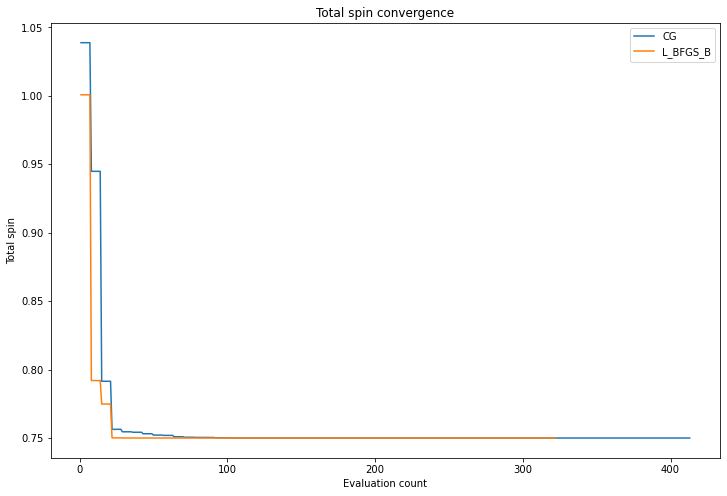

In [15]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [16]:
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv[1].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-06-20 12:56:04,646:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.50382625  2.49288525  0.58889126 -0.83842183 -2.55148238  1.30493001]
2021-06-20 12:56:04,650:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-06-20 12:

2021-06-20 12:56:51,345:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


## Depth = 2

In [17]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=2)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├─░─┤ X ├──■───░─┤ RY(θ[7]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├─░─┤ RY(θ[8]) ├
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘


In [18]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-06-20 12:57:02,297:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fac11c56cd0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fac1192dfa0>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ RY(θ[1

2021-06-20 12:57:02,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119273] - 47.84799 (ms), eval count: 1
2021-06-20 12:57:02,365:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98388 (ms)
2021-06-20 12:57:02,372:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119272] - 9.39703 (ms), eval count: 2
2021-06-20 12:57:02,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47676 (ms)
2021-06-20 12:57:02,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119272] - 6.97803 (ms), eval count: 3
2021-06-20 12:57:02,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31600 (ms)
2021-06-20 12:57:02,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119273] - 6.32095 (ms), eval count: 4
2021-06-20 12:57:02,409:qiskit.aqua.operators.converters.circ

Optimizer: CG        

2021-06-20 12:57:02,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70200 (ms)
2021-06-20 12:57:02,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119274] - 20.04480 (ms), eval count: 9
2021-06-20 12:57:02,487:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81031 (ms)
2021-06-20 12:57:02,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.29119273] - 16.51382 (ms), eval count: 10
2021-06-20 12:57:02,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75397 (ms)
2021-06-20 12:57:02,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.19082446] - 8.03423 (ms), eval count: 11
2021-06-20 12:57:02,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.56808 (ms)
2021-06-20 12:57:02,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-06-20 12:57:03,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.86832 (ms)
2021-06-20 12:57:03,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.79121654] - 12.19010 (ms), eval count: 40
2021-06-20 12:57:03,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48671 (ms)
2021-06-20 12:57:03,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.79961317] - 12.26711 (ms), eval count: 41
2021-06-20 12:57:03,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69611 (ms)
2021-06-20 12:57:03,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.79961317] - 9.16719 (ms), eval count: 42
2021-06-20 12:57:03,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37591 (ms)
2021-06-20 12:57:03,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-06-20 12:57:03,460:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.69782 (ms)
2021-06-20 12:57:03,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75231352] - 16.78801 (ms), eval count: 71
2021-06-20 12:57:03,472:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93699 (ms)
2021-06-20 12:57:03,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75231352] - 21.35897 (ms), eval count: 72
2021-06-20 12:57:03,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93293 (ms)
2021-06-20 12:57:03,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75231352] - 18.40997 (ms), eval count: 73
2021-06-20 12:57:03,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.92101 (ms)
2021-06-20 12:57:03,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:57:03,867:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98324 (ms)
2021-06-20 12:57:03,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017779] - 5.65219 (ms), eval count: 102
2021-06-20 12:57:03,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69802 (ms)
2021-06-20 12:57:03,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017779] - 5.02396 (ms), eval count: 103
2021-06-20 12:57:03,882:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99485 (ms)
2021-06-20 12:57:03,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017779] - 6.61087 (ms), eval count: 104
2021-06-20 12:57:03,890:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92213 (ms)
2021-06-20 12:57:03,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:57:04,243:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79410 (ms)
2021-06-20 12:57:04,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002033] - 8.42118 (ms), eval count: 133
2021-06-20 12:57:04,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38903 (ms)
2021-06-20 12:57:04,263:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002033] - 10.99396 (ms), eval count: 134
2021-06-20 12:57:04,269:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73292 (ms)
2021-06-20 12:57:04,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002033] - 23.55480 (ms), eval count: 135
2021-06-20 12:57:04,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07829 (ms)
2021-06-20 12:57:04,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-06-20 12:57:04,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33681 (ms)
2021-06-20 12:57:04,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000417] - 5.08213 (ms), eval count: 164
2021-06-20 12:57:04,707:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40183 (ms)
2021-06-20 12:57:04,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000417] - 15.07998 (ms), eval count: 165
2021-06-20 12:57:04,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87588 (ms)
2021-06-20 12:57:04,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000417] - 16.21079 (ms), eval count: 166
2021-06-20 12:57:04,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64771 (ms)
2021-06-20 12:57:04,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-06-20 12:57:05,060:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00708 (ms)
2021-06-20 12:57:05,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000055] - 6.46710 (ms), eval count: 195
2021-06-20 12:57:05,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40810 (ms)
2021-06-20 12:57:05,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000055] - 8.03876 (ms), eval count: 196
2021-06-20 12:57:05,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99111 (ms)
2021-06-20 12:57:05,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000055] - 6.05536 (ms), eval count: 197
2021-06-20 12:57:05,085:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81890 (ms)
2021-06-20 12:57:05,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:57:05,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.87680 (ms), eval count: 226
2021-06-20 12:57:05,314:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96409 (ms)
2021-06-20 12:57:05,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.66380 (ms), eval count: 227
2021-06-20 12:57:05,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31290 (ms)
2021-06-20 12:57:05,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.69510 (ms), eval count: 228
2021-06-20 12:57:05,329:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16579 (ms)
2021-06-20 12:57:05,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.05624 (ms), eval count: 229
2021-06-20 12:57:05,336:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:57:05,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.97400 (ms), eval count: 258
2021-06-20 12:57:05,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.89812 (ms)
2021-06-20 12:57:05,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.97782 (ms), eval count: 259
2021-06-20 12:57:05,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76391 (ms)
2021-06-20 12:57:05,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.52897 (ms), eval count: 260
2021-06-20 12:57:05,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 3.4277079105377197 seconds.
Found opt_params [-3.03380805  3.02114704 -2.24056447  1.51639085  2.98717664 -2.72684854
 -1.52911659 -1.17714835  3.31803869] in 260 evals
2021-06-20 12:57:05,758:qiskit.aqua.algorithms.minimum_eigen_so

2021-06-20 12:57:05,785:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-06-20 12:57:05,788:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 13 operations with depth 7
op_counts: OrderedDict([('ry', 9), ('barrier', 4), ('cx', 4)])

2021-06-20 12:57:05,800:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.76078 (ms)
2021-06-20 12:57:05,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.30855283] - 40.27915 (ms), eval count: 1
2021-06-20 12:57:05,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10595 (ms)
2021-06-20 12:57:05,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.30855283] - 19.02485 (ms), eval count: 2
2021-06-20 12:57:05,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28588 (ms)
2021-06-20 12:57:05,854:qiskit.aqua.algorithms.min

optimal_parameters {Parameter(θ[0]): -3.033808048163633, Parameter(θ[1]): 3.0211470434798047, Parameter(θ[2]): -2.2405644659421795, Parameter(θ[3]): 1.5163908455276474, Parameter(θ[4]): 2.9871766363897154, Parameter(θ[5]): -2.7268485429475127, Parameter(θ[6]): -1.52911659452545, Parameter(θ[7]): -1.1771483522742423, Parameter(θ[8]): 3.3180386863994866}
optimal_point [-3.03380805  3.02114704 -2.24056447  1.51639085  2.98717664 -2.72684854
 -1.52911659 -1.17714835  3.31803869]
optimal_value 0.7500000000000139
optimizer_evals 260
optimizer_time 3.4277079105377197
eigenvalue (0.7500000000000139+0j)
eigenstate [ 2.59088385e-08+0.j -5.99851846e-01+0.j  4.58451296e-01-0.j
 -1.21004013e-01+0.j  1.41400630e-01+0.j  5.00980793e-01+0.j
 -3.79976721e-01+0.j  2.57687569e-08+0.j]
cost_function_evals 260
Optimizer: L_BFGS_B        

2021-06-20 12:57:05,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.04780 (ms)
2021-06-20 12:57:05,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.59113901] - 23.66090 (ms), eval count: 12
2021-06-20 12:57:05,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76716 (ms)
2021-06-20 12:57:05,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.59113901] - 10.61416 (ms), eval count: 13
2021-06-20 12:57:06,001:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.87500 (ms)
2021-06-20 12:57:06,007:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.59113901] - 6.62899 (ms), eval count: 14
2021-06-20 12:57:06,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.86617 (ms)
2021-06-20 12:57:06,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-06-20 12:57:06,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77706578] - 5.58782 (ms), eval count: 43
2021-06-20 12:57:06,340:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81198 (ms)
2021-06-20 12:57:06,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77706578] - 12.90917 (ms), eval count: 44
2021-06-20 12:57:06,354:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01686 (ms)
2021-06-20 12:57:06,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77706578] - 6.07371 (ms), eval count: 45
2021-06-20 12:57:06,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.06918 (ms)
2021-06-20 12:57:06,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77706578] - 13.67664 (ms), eval count: 46
2021-06-20 12:57:06,380:qiskit.aqua.operators.converters

2021-06-20 12:57:06,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 22.36819 (ms), eval count: 74
2021-06-20 12:57:06,751:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13306 (ms)
2021-06-20 12:57:06,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 7.86686 (ms), eval count: 75
2021-06-20 12:57:06,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11906 (ms)
2021-06-20 12:57:06,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 12.55918 (ms), eval count: 76
2021-06-20 12:57:06,778:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66099 (ms)
2021-06-20 12:57:06,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 13.99493 (ms), eval count: 77
2021-06-20 12:57:06,797:qiskit.aqua.operators.converter

2021-06-20 12:57:07,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 8.76594 (ms), eval count: 105
2021-06-20 12:57:07,189:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.87680 (ms)
2021-06-20 12:57:07,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 24.12224 (ms), eval count: 106
2021-06-20 12:57:07,211:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10579 (ms)
2021-06-20 12:57:07,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 12.73322 (ms), eval count: 107
2021-06-20 12:57:07,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07980 (ms)
2021-06-20 12:57:07,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 7.97534 (ms), eval count: 108
2021-06-20 12:57:07,237:qiskit.aqua.operators.conver

2021-06-20 12:57:07,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 13.74912 (ms), eval count: 136
2021-06-20 12:57:07,626:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36607 (ms)
2021-06-20 12:57:07,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 12.28094 (ms), eval count: 137
2021-06-20 12:57:07,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22080 (ms)
2021-06-20 12:57:07,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 11.23095 (ms), eval count: 138
2021-06-20 12:57:07,657:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41892 (ms)
2021-06-20 12:57:07,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 14.51921 (ms), eval count: 139
2021-06-20 12:57:07,677:qiskit.aqua.operators.conv

2021-06-20 12:57:08,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.67581 (ms), eval count: 167
2021-06-20 12:57:08,050:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03800 (ms)
2021-06-20 12:57:08,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 14.45794 (ms), eval count: 168
2021-06-20 12:57:08,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.24978 (ms)
2021-06-20 12:57:08,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 27.04525 (ms), eval count: 169
2021-06-20 12:57:08,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73521 (ms)
2021-06-20 12:57:08,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 15.84578 (ms), eval count: 170
2021-06-20 12:57:08,114:qiskit.aqua.operators.conv

2021-06-20 12:57:08,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.63392 (ms), eval count: 198
2021-06-20 12:57:08,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30773 (ms)
2021-06-20 12:57:08,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.86195 (ms), eval count: 199
2021-06-20 12:57:08,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21014 (ms)
2021-06-20 12:57:08,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.48605 (ms), eval count: 200
2021-06-20 12:57:08,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53987 (ms)
2021-06-20 12:57:08,556:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.46681 (ms), eval count: 201
2021-06-20 12:57:08,563:qiskit.aqua.operators.conver

2021-06-20 12:57:08,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.36804 (ms), eval count: 229
2021-06-20 12:57:08,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34175 (ms)
2021-06-20 12:57:08,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 13.30495 (ms), eval count: 230
2021-06-20 12:57:08,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41208 (ms)
2021-06-20 12:57:08,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 13.84997 (ms), eval count: 231
2021-06-20 12:57:08,985:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58510 (ms)
2021-06-20 12:57:08,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 15.25712 (ms), eval count: 232
2021-06-20 12:57:09,001:qiskit.aqua.operators.conv

2021-06-20 12:57:09,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.00896 (ms), eval count: 260
2021-06-20 12:57:09,389:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65989 (ms)
2021-06-20 12:57:09,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 14.62507 (ms), eval count: 261
2021-06-20 12:57:09,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04499 (ms)
2021-06-20 12:57:09,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.63998 (ms), eval count: 262
2021-06-20 12:57:09,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27094 (ms)
2021-06-20 12:57:09,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.59301 (ms), eval count: 263
2021-06-20 12:57:09,438:qiskit.aqua.operators.convert

2021-06-20 12:57:09,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 17.71784 (ms), eval count: 291
2021-06-20 12:57:09,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14720 (ms)
2021-06-20 12:57:09,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.27186 (ms), eval count: 292
2021-06-20 12:57:09,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89972 (ms)
2021-06-20 12:57:09,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.36692 (ms), eval count: 293
2021-06-20 12:57:09,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14417 (ms)
2021-06-20 12:57:09,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.22392 (ms), eval count: 294
2021-06-20 12:57:09,932:qiskit.aqua.operators.conver

2021-06-20 12:57:10,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.12712 (ms), eval count: 322
2021-06-20 12:57:10,310:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70891 (ms)
2021-06-20 12:57:10,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.23293 (ms), eval count: 323
2021-06-20 12:57:10,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00994 (ms)
2021-06-20 12:57:10,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.81402 (ms), eval count: 324
2021-06-20 12:57:10,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23494 (ms)
2021-06-20 12:57:10,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.70886 (ms), eval count: 325
2021-06-20 12:57:10,344:qiskit.aqua.operators.convert

optimal_parameters {Parameter(θ[0]): -2.7375661931627198, Parameter(θ[1]): -2.9629768336262687, Parameter(θ[2]): 1.5366116347562433, Parameter(θ[3]): 1.6615797702704735, Parameter(θ[4]): 0.1992747507748625, Parameter(θ[5]): -3.105426214665817, Parameter(θ[6]): 0.7450148343437127, Parameter(θ[7]): -1.98733369537964, Parameter(θ[8]): -1.8763676379528396}
optimal_point [-2.73756619 -2.96297683  1.53661163  1.66157977  0.19927475 -3.10542621
  0.74501483 -1.9873337  -1.87636764]
optimal_value 0.7500000105157125
optimizer_evals 340
optimizer_time 4.773899078369141
eigenvalue (0.7500000105157125+0j)
eigenstate [-1.27339024e-05+0.j  1.03694714e-01+0.j -1.11492425e-01+0.j
  5.99623184e-03+0.j  7.82371989e-03+0.j  6.95870212e-01+0.j
 -7.01772277e-01+0.j -1.27197315e-05+0.j]
cost_function_evals 340


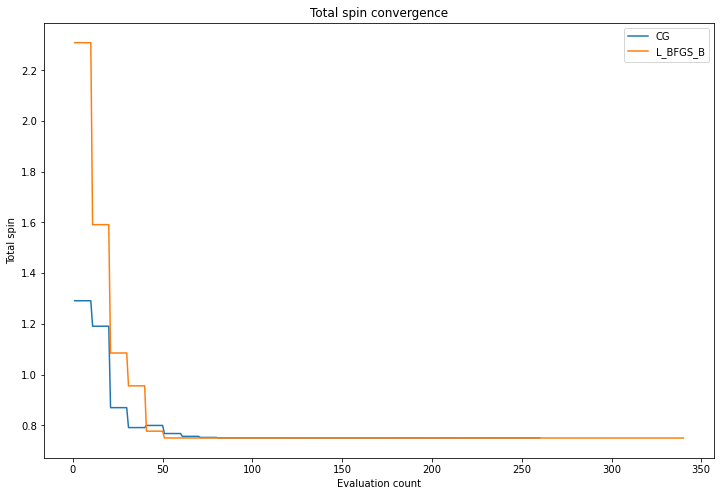

In [19]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [20]:
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv[2].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-06-20 12:57:10,921:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.83560528  2.39776399 -1.01755847 -2.97537999 -0.82242496 -0.98886139
  2.16368181  0.17650219 -2.80060917]
2021-06-20 12:57:10,933:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:16

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discar

## Depth = 3

In [21]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├─░─┤ X ├──■───░─┤ RY(θ[7]) ├─░─»
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ »
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├─░─┤ RY(θ[8]) ├─░─»
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘ ░ »
«                ░  ┌──────────┐
«q_0: ──■────────░──┤ RY(θ[9]) ├
«     ┌─┴─┐      ░ ┌┴──────────┤
«q_1: ┤ X ├──■───░─┤ RY(θ[10]) ├
«     └───┘┌─┴─┐ ░ ├───────────┤
«q_2: ─────┤ X ├─░─┤ RY(θ[11]) ├
«          └───┘ ░ └───────────┘


In [22]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-06-20 12:59:22,482:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fac11c3f310>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fac11ee44c0>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q

2021-06-20 12:59:22,485:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-06-20 12:59:22,499:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-06-20 12:59:22,500:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 18 operations with depth 10
op_counts: OrderedDict([('ry', 12), ('barrier', 6), ('cx', 6)])

2021-06-20 12:59:22,501:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-06-20 12:59:22,502:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 18 operations with depth 10
op_counts: OrderedDict([('ry', 12), ('barrier', 6), ('cx', 6)])

2021-06-20 12:59:22,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67300 (ms)
2021-06-20 12:59:22,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.19517642] - 17.19189 (ms), 

Optimizer: CG        

2021-06-20 12:59:22,667:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02172 (ms)
2021-06-20 12:59:22,673:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93825496] - 8.87108 (ms), eval count: 21
2021-06-20 12:59:22,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39999 (ms)
2021-06-20 12:59:22,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93825498] - 7.69520 (ms), eval count: 22
2021-06-20 12:59:22,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71280 (ms)
2021-06-20 12:59:22,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93825497] - 7.54619 (ms), eval count: 23
2021-06-20 12:59:22,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11103 (ms)
2021-06-20 12:59:22,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:59:22,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.82846448] - 5.98669 (ms), eval count: 52
2021-06-20 12:59:22,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39904 (ms)
2021-06-20 12:59:22,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77354891] - 6.28901 (ms), eval count: 53
2021-06-20 12:59:22,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25885 (ms)
2021-06-20 12:59:22,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77354891] - 6.16097 (ms), eval count: 54
2021-06-20 12:59:22,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25980 (ms)
2021-06-20 12:59:22,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7735489] - 6.03104 (ms), eval count: 55
2021-06-20 12:59:22,942:qiskit.aqua.operators.converters.ci

2021-06-20 12:59:23,154:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23096 (ms)
2021-06-20 12:59:23,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75566533] - 5.59998 (ms), eval count: 84
2021-06-20 12:59:23,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61004 (ms)
2021-06-20 12:59:23,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75566533] - 5.69987 (ms), eval count: 85
2021-06-20 12:59:23,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33221 (ms)
2021-06-20 12:59:23,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75566533] - 5.60999 (ms), eval count: 86
2021-06-20 12:59:23,175:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85800 (ms)
2021-06-20 12:59:23,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:59:23,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005169] - 5.31983 (ms), eval count: 115
2021-06-20 12:59:23,393:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66821 (ms)
2021-06-20 12:59:23,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005169] - 6.45208 (ms), eval count: 116
2021-06-20 12:59:23,399:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12319 (ms)
2021-06-20 12:59:23,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005169] - 5.59306 (ms), eval count: 117
2021-06-20 12:59:23,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38593 (ms)
2021-06-20 12:59:23,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001734] - 5.93805 (ms), eval count: 118
2021-06-20 12:59:23,414:qiskit.aqua.operators.converte

2021-06-20 12:59:23,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000315] - 5.93901 (ms), eval count: 146
2021-06-20 12:59:23,623:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60623 (ms)
2021-06-20 12:59:23,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000315] - 6.00886 (ms), eval count: 147
2021-06-20 12:59:23,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23811 (ms)
2021-06-20 12:59:23,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000315] - 5.97692 (ms), eval count: 148
2021-06-20 12:59:23,638:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54805 (ms)
2021-06-20 12:59:23,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000315] - 6.37603 (ms), eval count: 149
2021-06-20 12:59:23,646:qiskit.aqua.operators.converte

2021-06-20 12:59:23,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97506 (ms)
2021-06-20 12:59:23,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.25117 (ms), eval count: 178
2021-06-20 12:59:23,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65987 (ms)
2021-06-20 12:59:23,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.70576 (ms), eval count: 179
2021-06-20 12:59:23,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62697 (ms)
2021-06-20 12:59:23,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.87685 (ms), eval count: 180
2021-06-20 12:59:23,871:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65200 (ms)
2021-06-20 12:59:23,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-06-20 12:59:24,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.91993 (ms), eval count: 209
2021-06-20 12:59:24,085:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22595 (ms)
2021-06-20 12:59:24,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.99289 (ms), eval count: 210
2021-06-20 12:59:24,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22595 (ms)
2021-06-20 12:59:24,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.83792 (ms), eval count: 211
2021-06-20 12:59:24,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65892 (ms)
2021-06-20 12:59:24,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.08413 (ms), eval count: 212
2021-06-20 12:59:24,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:59:24,321:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.08611 (ms), eval count: 241
2021-06-20 12:59:24,323:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22213 (ms)
2021-06-20 12:59:24,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.04916 (ms), eval count: 242
2021-06-20 12:59:24,332:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41303 (ms)
2021-06-20 12:59:24,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.63996 (ms), eval count: 243
2021-06-20 12:59:24,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25694 (ms)
2021-06-20 12:59:24,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.92113 (ms), eval count: 244
2021-06-20 12:59:24,345:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:59:24,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.11393 (ms), eval count: 273
2021-06-20 12:59:24,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41811 (ms)
2021-06-20 12:59:24,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.18863 (ms), eval count: 274
2021-06-20 12:59:24,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26886 (ms)
2021-06-20 12:59:24,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.28829 (ms), eval count: 275
2021-06-20 12:59:24,582:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93095 (ms)
2021-06-20 12:59:24,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.17695 (ms), eval count: 276
2021-06-20 12:59:24,588:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:59:24,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.15096 (ms), eval count: 305
2021-06-20 12:59:24,879:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21593 (ms)
2021-06-20 12:59:24,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.42705 (ms), eval count: 306
2021-06-20 12:59:24,887:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22786 (ms)
2021-06-20 12:59:24,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.67603 (ms), eval count: 307
2021-06-20 12:59:24,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22976 (ms)
2021-06-20 12:59:24,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.95593 (ms), eval count: 308
2021-06-20 12:59:24,901:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:59:25,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.91063 (ms), eval count: 337
2021-06-20 12:59:25,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24097 (ms)
2021-06-20 12:59:25,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.79619 (ms), eval count: 338
2021-06-20 12:59:25,121:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39117 (ms)
2021-06-20 12:59:25,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.22892 (ms), eval count: 339
2021-06-20 12:59:25,128:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10507 (ms)
2021-06-20 12:59:25,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.33986 (ms), eval count: 340
2021-06-20 12:59:25,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-06-20 12:59:25,330:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.13415620e+00  2.98894133e+00 -1.73479850e+00  1.78241479e+00
  2.02517929e+00  2.29274253e+00 -2.25067940e+00  1.55229275e-03
  1.29231677e+00 -1.37143544e+00  1.56693206e+00  2.36655991e+00]
2021-06-20 12:59:25,342:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-06-20 12:59:25,343:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classic

optimal_parameters {Parameter(θ[0]): -3.1243028979047884, Parameter(θ[10]): -1.1284507698925086, Parameter(θ[11]): 1.076658757821213, Parameter(θ[1]): 0.6359690062884057, Parameter(θ[2]): 2.3413538139843966, Parameter(θ[3]): -1.1116788322171838, Parameter(θ[4]): -1.1717842788783113, Parameter(θ[5]): 1.4658973095344539, Parameter(θ[6]): -1.6741046664137311, Parameter(θ[7]): 0.4469593485566253, Parameter(θ[8]): -1.5961866266470233, Parameter(θ[9]): -1.3123849089926254}
optimal_point [-3.1243029  -1.12845077  1.07665876  0.63596901  2.34135381 -1.11167883
 -1.17178428  1.46589731 -1.67410467  0.44695935 -1.59618663 -1.31238491]
optimal_value 0.7500000000000013
optimizer_evals 364
optimizer_time 2.8280770778656006
eigenvalue (0.7500000000000013+0j)
eigenstate [-7.18137170e-09+0.j -1.45354845e-01+0.j  6.43318181e-01+0.j
 -2.44814874e-01+0.j -4.97963326e-01+0.j  4.59412423e-01+0.j
 -2.14597566e-01+0.j -1.99805439e-08+0.j]
cost_function_evals 364
Optimizer: L_BFGS_B        

2021-06-20 12:59:25,530:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65796 (ms)
2021-06-20 12:59:25,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.12970292] - 6.74009 (ms), eval count: 25
2021-06-20 12:59:25,539:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42479 (ms)
2021-06-20 12:59:25,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.12970292] - 6.33097 (ms), eval count: 26
2021-06-20 12:59:25,547:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04802 (ms)
2021-06-20 12:59:25,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81740819] - 7.65514 (ms), eval count: 27
2021-06-20 12:59:25,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90091 (ms)
2021-06-20 12:59:25,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:59:25,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75018335] - 5.92089 (ms), eval count: 56
2021-06-20 12:59:25,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61481 (ms)
2021-06-20 12:59:25,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75018335] - 4.92597 (ms), eval count: 57
2021-06-20 12:59:25,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91116 (ms)
2021-06-20 12:59:25,782:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75018335] - 6.98590 (ms), eval count: 58
2021-06-20 12:59:25,786:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91212 (ms)
2021-06-20 12:59:25,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75018335] - 6.05989 (ms), eval count: 59
2021-06-20 12:59:25,792:qiskit.aqua.operators.converters.c

2021-06-20 12:59:25,997:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23477 (ms)
2021-06-20 12:59:26,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 5.93591 (ms), eval count: 88
2021-06-20 12:59:26,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24192 (ms)
2021-06-20 12:59:26,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 5.88393 (ms), eval count: 89
2021-06-20 12:59:26,011:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55711 (ms)
2021-06-20 12:59:26,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 6.11806 (ms), eval count: 90
2021-06-20 12:59:26,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00009 (ms)
2021-06-20 12:59:26,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-06-20 12:59:26,229:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97196 (ms)
2021-06-20 12:59:26,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.66213 (ms), eval count: 119
2021-06-20 12:59:26,237:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95909 (ms)
2021-06-20 12:59:26,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.19991 (ms), eval count: 120
2021-06-20 12:59:26,243:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63889 (ms)
2021-06-20 12:59:26,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.39296 (ms), eval count: 121
2021-06-20 12:59:26,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24598 (ms)
2021-06-20 12:59:26,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:26,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93191 (ms)
2021-06-20 12:59:26,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.40106 (ms), eval count: 150
2021-06-20 12:59:26,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65796 (ms)
2021-06-20 12:59:26,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.17497 (ms), eval count: 151
2021-06-20 12:59:26,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89996 (ms)
2021-06-20 12:59:26,477:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.20914 (ms), eval count: 152
2021-06-20 12:59:26,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26696 (ms)
2021-06-20 12:59:26,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:26,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29597 (ms)
2021-06-20 12:59:26,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.46012 (ms), eval count: 181
2021-06-20 12:59:26,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23906 (ms)
2021-06-20 12:59:26,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.82480 (ms), eval count: 182
2021-06-20 12:59:26,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39904 (ms)
2021-06-20 12:59:26,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.80215 (ms), eval count: 183
2021-06-20 12:59:26,707:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24192 (ms)
2021-06-20 12:59:26,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:26,910:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01917 (ms)
2021-06-20 12:59:26,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.96929 (ms), eval count: 212
2021-06-20 12:59:26,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25885 (ms)
2021-06-20 12:59:26,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.70583 (ms), eval count: 213
2021-06-20 12:59:26,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94883 (ms)
2021-06-20 12:59:26,928:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.93805 (ms), eval count: 214
2021-06-20 12:59:26,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97291 (ms)
2021-06-20 12:59:26,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:27,189:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77670 (ms)
2021-06-20 12:59:27,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.57899 (ms), eval count: 243
2021-06-20 12:59:27,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25282 (ms)
2021-06-20 12:59:27,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.20580 (ms), eval count: 244
2021-06-20 12:59:27,203:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89614 (ms)
2021-06-20 12:59:27,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.62215 (ms), eval count: 245
2021-06-20 12:59:27,210:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90711 (ms)
2021-06-20 12:59:27,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:27,422:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40905 (ms)
2021-06-20 12:59:27,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 6.20008 (ms), eval count: 274
2021-06-20 12:59:27,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24598 (ms)
2021-06-20 12:59:27,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 6.22106 (ms), eval count: 275
2021-06-20 12:59:27,437:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24693 (ms)
2021-06-20 12:59:27,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000016] - 5.90801 (ms), eval count: 276
2021-06-20 12:59:27,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23906 (ms)
2021-06-20 12:59:27,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:27,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35994 (ms)
2021-06-20 12:59:27,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.64496 (ms), eval count: 305
2021-06-20 12:59:27,657:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22905 (ms)
2021-06-20 12:59:27,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.68907 (ms), eval count: 306
2021-06-20 12:59:27,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24383 (ms)
2021-06-20 12:59:27,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.16097 (ms), eval count: 307
2021-06-20 12:59:27,672:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39594 (ms)
2021-06-20 12:59:27,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:27,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99795 (ms)
2021-06-20 12:59:27,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.37412 (ms), eval count: 336
2021-06-20 12:59:27,887:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25384 (ms)
2021-06-20 12:59:27,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.69701 (ms), eval count: 337
2021-06-20 12:59:27,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91998 (ms)
2021-06-20 12:59:27,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.16312 (ms), eval count: 338
2021-06-20 12:59:27,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81007 (ms)
2021-06-20 12:59:27,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:28,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24311 (ms)
2021-06-20 12:59:28,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.95212 (ms), eval count: 367
2021-06-20 12:59:28,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24288 (ms)
2021-06-20 12:59:28,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.89299 (ms), eval count: 368
2021-06-20 12:59:28,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25623 (ms)
2021-06-20 12:59:28,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.25801 (ms), eval count: 369
2021-06-20 12:59:28,136:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23692 (ms)
2021-06-20 12:59:28,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:28,342:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26791 (ms)
2021-06-20 12:59:28,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.95403 (ms), eval count: 398
2021-06-20 12:59:28,349:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25217 (ms)
2021-06-20 12:59:28,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.74708 (ms), eval count: 399
2021-06-20 12:59:28,356:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26505 (ms)
2021-06-20 12:59:28,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.93781 (ms), eval count: 400
2021-06-20 12:59:28,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24073 (ms)
2021-06-20 12:59:28,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:28,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27697 (ms)
2021-06-20 12:59:28,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.11138 (ms), eval count: 429
2021-06-20 12:59:28,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83702 (ms)
2021-06-20 12:59:28,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.08094 (ms), eval count: 430
2021-06-20 12:59:28,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82819 (ms)
2021-06-20 12:59:28,585:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.38103 (ms), eval count: 431
2021-06-20 12:59:28,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05898 (ms)
2021-06-20 12:59:28,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:28,794:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03991 (ms)
2021-06-20 12:59:28,799:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.66904 (ms), eval count: 460
2021-06-20 12:59:28,801:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21903 (ms)
2021-06-20 12:59:28,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.68104 (ms), eval count: 461
2021-06-20 12:59:28,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68490 (ms)
2021-06-20 12:59:28,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.72705 (ms), eval count: 462
2021-06-20 12:59:28,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26004 (ms)
2021-06-20 12:59:28,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-06-20 12:59:29,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25313 (ms)
2021-06-20 12:59:29,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.00123 (ms), eval count: 491
2021-06-20 12:59:29,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23811 (ms)
2021-06-20 12:59:29,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.70393 (ms), eval count: 492
2021-06-20 12:59:29,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90902 (ms)
2021-06-20 12:59:29,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.83284 (ms), eval count: 493
2021-06-20 12:59:29,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24693 (ms)
2021-06-20 12:59:29,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

optimal_parameters {Parameter(θ[0]): -2.1939200234645932, Parameter(θ[10]): 2.9406185445073882, Parameter(θ[11]): -2.2426118434297666, Parameter(θ[1]): 2.108324545090549, Parameter(θ[2]): 1.4502443267398006, Parameter(θ[3]): 2.2027780867693103, Parameter(θ[4]): -2.1354697276664885, Parameter(θ[5]): 0.34646512310391503, Parameter(θ[6]): 1.4767871788543456, Parameter(θ[7]): -1.6668883527518066, Parameter(θ[8]): 2.2484848511402133, Parameter(θ[9]): 2.5717791662504905}
optimal_point [-2.19392002  2.94061854 -2.24261184  2.10832455  1.45024433  2.20277809
 -2.13546973  0.34646512  1.47678718 -1.66688835  2.24848485  2.57177917]
optimal_value 0.7500000092448174
optimizer_evals 520
optimizer_time 3.9124999046325684
eigenvalue (0.7500000092448174+0j)
eigenstate [-4.64274430e-05+0.j  1.45306749e-02+0.j  4.07229433e-01+0.j
 -1.25371990e-01+0.j -4.21790839e-01+0.j -4.99664487e-01+0.j
  6.25030238e-01+0.j -2.44605611e-05+0.j]
cost_function_evals 520


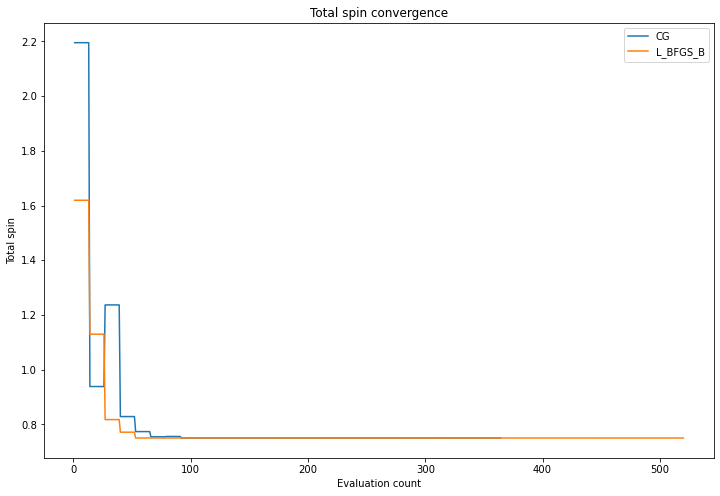

In [23]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [24]:
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv[3].append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-06-20 12:59:29,458:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.09575985 -1.9742836   1.59369315  1.11396245 -0.93319715  0.73186626
 -1.34932227  0.31924281 -1.51322697  1.53306391 -2.45962759 -0.74529676]
2021-06-20 12:59:29,460:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex 

2021-06-20 13:02:56,944:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/li

## Cost function for the different states of total spin

In [25]:
psi_L   = compose_two_spins('L')
psi_LC  = compose_with_center(psi_L,'L')

print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

eig_3spins=[]
for v in psi_LC.values():
    eig_3spins.append(np.concatenate(np.concatenate(v)))

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


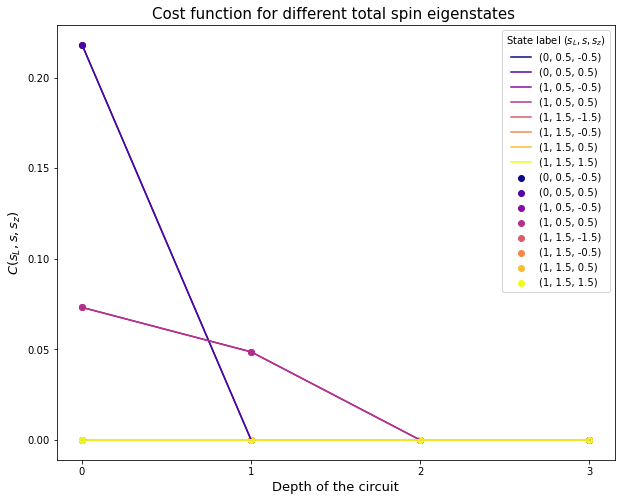

In [26]:
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,8)))

opt_val=[[] for i in range(4)]
for i in range(4):
    for el in cost_conv[i]:
        opt_val[i].append(el['optimal_value'])
    
eig_val=[[] for i in range(len(psi_LC.keys()))]
for i in range(len(psi_LC.keys())):
    for j in range(len(cost_conv)):
        eig_val[i].append(opt_val[j][i])

plt.figure(figsize=(10,8))
for i in range(8):
    c = next(colors)
    plt.plot(np.arange(4),eig_val[i],label=lab_list[i],color=c)
    plt.scatter(np.arange(4),eig_val[i],label=lab_list[i],color=c)
plt.title('Cost function for different total spin eigenstates ',fontsize=15)
plt.xlabel('Depth of the circuit',fontsize=13)
plt.ylabel(r'$C(s_L,s,s_z)$',fontsize=13)
plt.xticks(np.arange(4))
plt.legend(title=r'State label $(s_L,s,s_z)$')
#plt.show()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/VQE_RY_cost_depth.pdf")

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


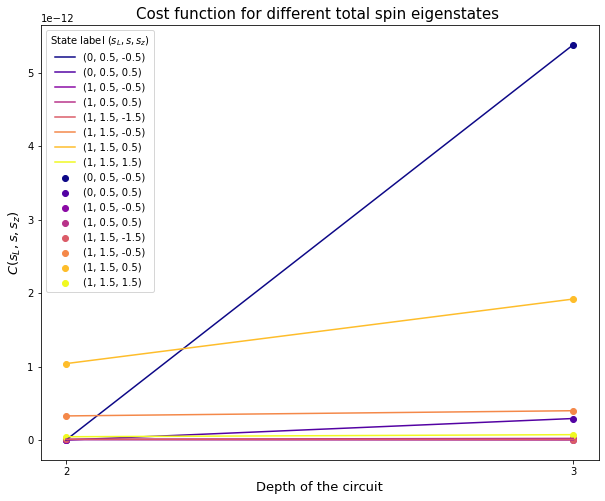

In [27]:
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,8)))

plt.figure(figsize=(10,8))
for i in range(8):
    c = next(colors)
    plt.plot(np.arange(2,4),eig_val[i][2:],label=lab_list[i],color=c)
    plt.scatter(np.arange(2,4),eig_val[i][2:],label=lab_list[i],color=c)
plt.title('Cost function for different total spin eigenstates ',fontsize=15)
plt.xlabel('Depth of the circuit',fontsize=13)
plt.ylabel(r'$C(s_L,s,s_z)$',fontsize=13)
plt.xticks(np.arange(2,4))
plt.legend(title=r'State label $(s_L,s,s_z)$')
#plt.show()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/VQE_RY_cost_depth2.pdf")

### Cost function value and best states in the case of RY with depth = 3

In [28]:
for i in range(8):
    print("State label: ",lab_list[i],' , C(s_L,s,s_z) = ',eig_val[i][3])

State label:  (0, 0.5, -0.5)  , C(s_L,s,s_z) =  3.3469410390712967e-15
State label:  (0, 0.5, 0.5)  , C(s_L,s,s_z) =  1.602185765755606e-14
State label:  (1, 0.5, -0.5)  , C(s_L,s,s_z) =  9.773130515521694e-15
State label:  (1, 0.5, 0.5)  , C(s_L,s,s_z) =  1.8420053774582537e-14
State label:  (1, 1.5, -1.5)  , C(s_L,s,s_z) =  2.0175789768189673e-13
State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  2.5089380051576877e-12
State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  1.6520493996546667e-10
State label:  (1, 1.5, 1.5)  , C(s_L,s,s_z) =  3.332345732209227e-14


#### Comparison wiith the total spin eigenfunctions of $3$ spins

In [29]:
for i,el in enumerate(cost_conv[3]):
    best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("Optimal: |",lab_list[i],">=",to_ket(best_psi))
    #print("Optimal: |",lab_list[i],">=",to_state(np.real(best_psi)))
    #print("Ideal: |",lab_list[i],">=",eig_3spins[i])
    print("<ideal|ideal> = ",np.dot(np.conjugate(eig_3spins[i]),eig_3spins[i]))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    int_prod=np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi)))
    fid=np.conjugate(int_prod)*int_prod
    print("|< ideal | optimal >|^2 = ",fid,"\n")

Optimal: | (0, 0.5, -0.5) >=  + (-0.707+0.000j) |101⟩ + (0.707+0.000j) |011⟩
<ideal|ideal> =  1.0000000000000002
<optimal|optimal> =  1.0
|< ideal | optimal >|^2 =  0.9999999685255558 

Optimal: | (0, 0.5, 0.5) >=  + (0.707+0.000j) |100⟩ + (-0.707+0.000j) |010⟩
<ideal|ideal> =  1.0000000000000002
<optimal|optimal> =  1.0
|< ideal | optimal >|^2 =  0.9999999280836946 

Optimal: | (1, 0.5, -0.5) >=  + (0.816+0.000j) |110⟩ + (-0.408+0.000j) |101⟩ + (-0.408+0.000j) |011⟩
<ideal|ideal> =  0.9999999999999999
<optimal|optimal> =  1.0
|< ideal | optimal >|^2 =  0.999999923118105 

Optimal: | (1, 0.5, 0.5) >=  + (-0.408+0.000j) |100⟩ + (-0.408+0.000j) |010⟩ + (0.817+0.000j) |001⟩
<ideal|ideal> =  0.9999999999999999
<optimal|optimal> =  1.0000000000000009
|< ideal | optimal >|^2 =  0.9999999301242847 

Optimal: | (1, 1.5, -1.5) >=  + (1.000+0.000j) |111⟩
<ideal|ideal> =  1.0
<optimal|optimal> =  0.9999999999999999
|< ideal | optimal >|^2 =  0.9999998396414209 

Optimal: | (1, 1.5, -0.5) >= (-0.4

| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|^2$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(0,1/2,-1/2)$ |$0.99999997$ |  
|$(0,1/2,1/2)$ | $0.99999993$ | 
|$(1,1/2,-1/2)$ |$0.99999992$ | 
|$(1,1/2,1/2)$ | $0.99999993$ | 
|$(1,3/2,-3/2)$ | $0.99999984$ | 
|$(1,3/2,3/2)$ | $0.99999991$ | 

**Questions about the improvement of the results on the states $(s_L=1,s=3/2,s_z=-1/2)$ and $(s_L=1,s=3/2,s_z=1/2)$**

We recap the results about those two states.

| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.371$ |  
|$(1,3/2,1/2)$ | $0.098$ | 

- First of all, we can change variational form, initial state and cost function
- What if we consider a more entangled structure of the variational form? In other words, what if we add also the connection $(0,2)$?
- What if we consider a different initial state? E.g. we can start from one of the expected vectors which compose the final state.

# Case of states $(s_L=1,s=3/2,s_z=-1/2)$ and $(s_L=1,s=3/2,s_z=1/2)$

## Depth $3$ and entanglement connections $[(0,1),(1,2),(0,2)]$

In [88]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2),(0,2)],insert_barriers=True,reps=3)
print("Number of parameters: "+str(var_form.num_parameters))
print(var_form.draw())

     ┌──────────┐ ░                 ░ ┌──────────┐ ░                 ░ »
q_0: ┤ RY(θ[0]) ├─░───■─────────■───░─┤ RY(θ[3]) ├─░───■─────────■───░─»
     ├──────────┤ ░ ┌─┴─┐       │   ░ ├──────────┤ ░ ┌─┴─┐       │   ░ »
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■────┼───░─┤ RY(θ[4]) ├─░─┤ X ├──■────┼───░─»
     ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ »
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├┤ X ├─░─»
     └──────────┘ ░      └───┘└───┘ ░ └──────────┘ ░      └───┘└───┘ ░ »
«     ┌──────────┐ ░                 ░  ┌──────────┐
«q_0: ┤ RY(θ[6]) ├─░───■─────────■───░──┤ RY(θ[9]) ├
«     ├──────────┤ ░ ┌─┴─┐       │   ░ ┌┴──────────┤
«q_1: ┤ RY(θ[7]) ├─░─┤ X ├──■────┼───░─┤ RY(θ[10]) ├
«     ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├───────────┤
«q_2: ┤ RY(θ[8]) ├─░──────┤ X ├┤ X ├─░─┤ RY(θ[11]) ├
«     └──────────┘ ░      └───┘└───┘ ░ └───────────┘


In [89]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

Optimizer: CG        

2021-03-02 12:45:37,437:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f90b29dfd30>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f90b29df940>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░                 ░ ┌──────────┐ ░                 ░ »
q_0: ┤ RY(θ[0]) ├─░───■─────────■───░─┤ RY(θ[3]) ├─░───■─────────■───░─»
     ├──────────┤ ░ ┌─┴─┐       │   ░ ├──────────┤ ░ ┌─┴─┐       │   ░ »
q_1: ┤ RY(θ[1]) 

2021-03-02 12:45:37,441:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.92688087  1.47008941 -2.54351535  2.82799363  2.93354615 -1.55456315
 -2.29891138 -0.67744651 -0.65672045  0.92470972  1.077469    2.29230752]
2021-03-02 12:45:37,464:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-03-02 12:45:37,485:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-02 12:45:37,488:qiskit.aq

2021-03-02 12:45:37,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.98446869] - 6.94728 (ms), eval count: 25
2021-03-02 12:45:37,724:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11589 (ms)
2021-03-02 12:45:37,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.9844687] - 30.36475 (ms), eval count: 26
2021-03-02 12:45:37,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31910 (ms)
2021-03-02 12:45:37,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.13987006] - 23.25416 (ms), eval count: 27
2021-03-02 12:45:37,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42789 (ms)
2021-03-02 12:45:37,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.13987007] - 5.67603 (ms), eval count: 28
2021-03-02 12:45:37,788:qiskit.aqua.operators.converters.

2021-03-02 12:45:38,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20401 (ms)
2021-03-02 12:45:38,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75368524] - 6.78492 (ms), eval count: 57
2021-03-02 12:45:38,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64723 (ms)
2021-03-02 12:45:38,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75368524] - 7.63226 (ms), eval count: 58
2021-03-02 12:45:38,098:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20203 (ms)
2021-03-02 12:45:38,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75368523] - 7.24387 (ms), eval count: 59
2021-03-02 12:45:38,113:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.52898 (ms)
2021-03-02 12:45:38,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-02 12:45:38,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75255064] - 5.74017 (ms), eval count: 88
2021-03-02 12:45:38,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.56903 (ms)
2021-03-02 12:45:38,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75255064] - 11.76071 (ms), eval count: 89
2021-03-02 12:45:38,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43290 (ms)
2021-03-02 12:45:38,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75255064] - 7.45797 (ms), eval count: 90
2021-03-02 12:45:38,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49775 (ms)
2021-03-02 12:45:38,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75255064] - 5.24592 (ms), eval count: 91
2021-03-02 12:45:38,449:qiskit.aqua.operators.converters.

2021-03-02 12:45:38,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000181] - 8.12602 (ms), eval count: 119
2021-03-02 12:45:38,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23906 (ms)
2021-03-02 12:45:38,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000181] - 6.05297 (ms), eval count: 120
2021-03-02 12:45:38,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00605 (ms)
2021-03-02 12:45:38,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000181] - 9.93395 (ms), eval count: 121
2021-03-02 12:45:38,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41191 (ms)
2021-03-02 12:45:38,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000181] - 6.19388 (ms), eval count: 122
2021-03-02 12:45:38,784:qiskit.aqua.operators.converte

2021-03-02 12:45:39,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.78978 (ms), eval count: 150
2021-03-02 12:45:39,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47581 (ms)
2021-03-02 12:45:39,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.68423 (ms), eval count: 151
2021-03-02 12:45:39,096:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35112 (ms)
2021-03-02 12:45:39,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.26805 (ms), eval count: 152
2021-03-02 12:45:39,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33300 (ms)
2021-03-02 12:45:39,123:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 4.84920 (ms), eval count: 153
2021-03-02 12:45:39,127:qiskit.aqua.operators.converte

2021-03-02 12:45:39,424:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22428 (ms)
2021-03-02 12:45:39,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 4.28987 (ms), eval count: 182
2021-03-02 12:45:39,434:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80285 (ms)
2021-03-02 12:45:39,437:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.29663 (ms), eval count: 183
2021-03-02 12:45:39,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46484 (ms)
2021-03-02 12:45:39,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.13897 (ms), eval count: 184
2021-03-02 12:45:39,453:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51491 (ms)
2021-03-02 12:45:39,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 12:45:39,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62005 (ms)
2021-03-02 12:45:39,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.43301 (ms), eval count: 214
2021-03-02 12:45:39,755:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37703 (ms)
2021-03-02 12:45:39,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.45392 (ms), eval count: 215
2021-03-02 12:45:39,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07210 (ms)
2021-03-02 12:45:39,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.79009 (ms), eval count: 216
2021-03-02 12:45:39,772:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15824 (ms)
2021-03-02 12:45:39,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 12:45:40,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96290 (ms)
2021-03-02 12:45:40,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.83500 (ms), eval count: 246
2021-03-02 12:45:40,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23429 (ms)
2021-03-02 12:45:40,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.73907 (ms), eval count: 247
2021-03-02 12:45:40,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70803 (ms)
2021-03-02 12:45:40,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.39083 (ms), eval count: 248
2021-03-02 12:45:40,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64723 (ms)
2021-03-02 12:45:40,117:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 12:45:40,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02584 (ms)
2021-03-02 12:45:40,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.54285 (ms), eval count: 278
2021-03-02 12:45:40,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60980 (ms)
2021-03-02 12:45:40,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.09526 (ms), eval count: 279
2021-03-02 12:45:40,420:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16277 (ms)
2021-03-02 12:45:40,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.63710 (ms), eval count: 280
2021-03-02 12:45:40,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09880 (ms)
2021-03-02 12:45:40,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 12:45:40,657:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.42085698 -1.96293041 -1.08255399  0.28948611 -0.53381408 -1.70282178
  0.90152355 -0.13298161  0.18567279 -2.95523981 -0.74585294  2.88518825]
2021-03-02 12:45:40,671:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-02 12:45:40,672:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 21 operations with depth 13
op_counts

optimal_parameters {Parameter(θ[0]): -3.8055693366232535, Parameter(θ[10]): 1.3103776739140454, Parameter(θ[11]): -2.2647388367919494, Parameter(θ[1]): 3.1896414320842825, Parameter(θ[2]): 3.0667404070078863, Parameter(θ[3]): -2.03714161269413, Parameter(θ[4]): -2.534246674654953, Parameter(θ[5]): -0.7806474475537168, Parameter(θ[6]): -0.9678640007440485, Parameter(θ[7]): 0.3980697285047032, Parameter(θ[8]): 0.9804289355485293, Parameter(θ[9]): 2.1732426388223964}
optimal_point [-3.80556934  1.31037767 -2.26473884  3.18964143  3.06674041 -2.03714161
 -2.53424667 -0.78064745 -0.967864    0.39806973  0.98042894  2.17324264]
optimal_value 0.7500000000000022
optimizer_evals 299
optimizer_time 3.17936110496521
eigenvalue (0.7500000000000022+0j)
eigenstate [-7.37637123e-09+0.j  6.35481505e-02+0.j -4.35720281e-01+0.j
 -1.16253027e-01+0.j  3.72172171e-01+0.j  6.27040044e-01+0.j
 -5.10787003e-01+0.j -1.26437185e-09+0.j]
cost_function_evals 299
Optimizer: L_BFGS_B        

2021-03-02 12:45:40,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8624955] - 5.97000 (ms), eval count: 15
2021-03-02 12:45:40,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37901 (ms)
2021-03-02 12:45:40,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8624955] - 8.83698 (ms), eval count: 16
2021-03-02 12:45:40,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59693 (ms)
2021-03-02 12:45:40,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8624955] - 7.00092 (ms), eval count: 17
2021-03-02 12:45:40,863:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23596 (ms)
2021-03-02 12:45:40,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8624955] - 5.14913 (ms), eval count: 18
2021-03-02 12:45:40,872:qiskit.aqua.operators.converters.circu

2021-03-02 12:45:41,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37115 (ms)
2021-03-02 12:45:41,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.05140816] - 7.57504 (ms), eval count: 47
2021-03-02 12:45:41,190:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20687 (ms)
2021-03-02 12:45:41,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.05140816] - 8.75974 (ms), eval count: 48
2021-03-02 12:45:41,203:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34699 (ms)
2021-03-02 12:45:41,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.05140816] - 8.04090 (ms), eval count: 49
2021-03-02 12:45:41,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79005 (ms)
2021-03-02 12:45:41,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-02 12:45:41,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76538714] - 7.15709 (ms), eval count: 78
2021-03-02 12:45:41,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45874 (ms)
2021-03-02 12:45:41,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75108836] - 9.65095 (ms), eval count: 79
2021-03-02 12:45:41,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19495 (ms)
2021-03-02 12:45:41,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75108836] - 5.28908 (ms), eval count: 80
2021-03-02 12:45:41,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88994 (ms)
2021-03-02 12:45:41,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75108836] - 7.23505 (ms), eval count: 81
2021-03-02 12:45:41,529:qiskit.aqua.operators.converters.c

2021-03-02 12:45:41,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000029] - 6.63686 (ms), eval count: 109
2021-03-02 12:45:41,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63603 (ms)
2021-03-02 12:45:41,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000029] - 7.03192 (ms), eval count: 110
2021-03-02 12:45:41,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81818 (ms)
2021-03-02 12:45:41,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000029] - 11.30700 (ms), eval count: 111
2021-03-02 12:45:41,837:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55926 (ms)
2021-03-02 12:45:41,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000029] - 7.54881 (ms), eval count: 112
2021-03-02 12:45:41,845:qiskit.aqua.operators.convert

2021-03-02 12:45:42,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 14.31489 (ms), eval count: 140
2021-03-02 12:45:42,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19400 (ms)
2021-03-02 12:45:42,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 6.16217 (ms), eval count: 141
2021-03-02 12:45:42,147:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53391 (ms)
2021-03-02 12:45:42,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 6.40488 (ms), eval count: 142
2021-03-02 12:45:42,154:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54305 (ms)
2021-03-02 12:45:42,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 6.60300 (ms), eval count: 143
2021-03-02 12:45:42,163:qiskit.aqua.operators.convert

2021-03-02 12:45:42,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 9.08589 (ms), eval count: 171
2021-03-02 12:45:42,459:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53630 (ms)
2021-03-02 12:45:42,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 8.09979 (ms), eval count: 172
2021-03-02 12:45:42,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42598 (ms)
2021-03-02 12:45:42,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 7.59101 (ms), eval count: 173
2021-03-02 12:45:42,476:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16086 (ms)
2021-03-02 12:45:42,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 9.87482 (ms), eval count: 174
2021-03-02 12:45:42,489:qiskit.aqua.operators.converte

2021-03-02 12:45:42,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 8.31795 (ms), eval count: 202
2021-03-02 12:45:42,773:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24519 (ms)
2021-03-02 12:45:42,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 6.59394 (ms), eval count: 203
2021-03-02 12:45:42,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02394 (ms)
2021-03-02 12:45:42,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 6.71172 (ms), eval count: 204
2021-03-02 12:45:42,788:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21808 (ms)
2021-03-02 12:45:42,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 6.38723 (ms), eval count: 205
2021-03-02 12:45:42,798:qiskit.aqua.operators.converte

2021-03-02 12:45:43,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 6.38103 (ms), eval count: 233
2021-03-02 12:45:43,223:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51205 (ms)
2021-03-02 12:45:43,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 7.90286 (ms), eval count: 234
2021-03-02 12:45:43,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68824 (ms)
2021-03-02 12:45:43,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.90722 (ms), eval count: 235
2021-03-02 12:45:43,240:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51110 (ms)
2021-03-02 12:45:43,245:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.43778 (ms), eval count: 236
2021-03-02 12:45:43,248:qiskit.aqua.operators.converte

2021-03-02 12:45:43,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.58602 (ms), eval count: 264
2021-03-02 12:45:43,525:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76995 (ms)
2021-03-02 12:45:43,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.72707 (ms), eval count: 265
2021-03-02 12:45:43,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46794 (ms)
2021-03-02 12:45:43,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.12809 (ms), eval count: 266
2021-03-02 12:45:43,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58811 (ms)
2021-03-02 12:45:43,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.09121 (ms), eval count: 267
2021-03-02 12:45:43,555:qiskit.aqua.operators.convert

2021-03-02 12:45:43,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000224] - 6.51312 (ms), eval count: 295
2021-03-02 12:45:43,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40977 (ms)
2021-03-02 12:45:43,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000224] - 6.21915 (ms), eval count: 296
2021-03-02 12:45:43,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46818 (ms)
2021-03-02 12:45:43,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000224] - 6.23608 (ms), eval count: 297
2021-03-02 12:45:43,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.52695 (ms)
2021-03-02 12:45:43,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000224] - 12.32505 (ms), eval count: 298
2021-03-02 12:45:43,900:qiskit.aqua.operators.convert

2021-03-02 12:45:44,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.43675 (ms), eval count: 326
2021-03-02 12:45:44,211:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74594 (ms)
2021-03-02 12:45:44,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.27424 (ms), eval count: 327
2021-03-02 12:45:44,222:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96981 (ms)
2021-03-02 12:45:44,228:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.31580 (ms), eval count: 328
2021-03-02 12:45:44,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16920 (ms)
2021-03-02 12:45:44,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.21104 (ms), eval count: 329
2021-03-02 12:45:44,238:qiskit.aqua.operators.converte

2021-03-02 12:45:44,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.38621 (ms), eval count: 357
2021-03-02 12:45:44,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20497 (ms)
2021-03-02 12:45:44,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 4.35686 (ms), eval count: 358
2021-03-02 12:45:44,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79498 (ms)
2021-03-02 12:45:44,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.92720 (ms), eval count: 359
2021-03-02 12:45:44,543:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71685 (ms)
2021-03-02 12:45:44,549:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.04908 (ms), eval count: 360
2021-03-02 12:45:44,553:qiskit.aqua.operators.convert

2021-03-02 12:45:44,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.01411 (ms), eval count: 388
2021-03-02 12:45:44,853:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18303 (ms)
2021-03-02 12:45:44,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.40202 (ms), eval count: 389
2021-03-02 12:45:44,864:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41995 (ms)
2021-03-02 12:45:44,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 13.79800 (ms), eval count: 390
2021-03-02 12:45:44,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58906 (ms)
2021-03-02 12:45:44,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000052] - 6.86097 (ms), eval count: 391
2021-03-02 12:45:44,888:qiskit.aqua.operators.convert

2021-03-02 12:45:45,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.63895 (ms), eval count: 419
2021-03-02 12:45:45,180:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23811 (ms)
2021-03-02 12:45:45,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.09019 (ms), eval count: 420
2021-03-02 12:45:45,193:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37210 (ms)
2021-03-02 12:45:45,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.22416 (ms), eval count: 421
2021-03-02 12:45:45,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77073 (ms)
2021-03-02 12:45:45,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.22384 (ms), eval count: 422
2021-03-02 12:45:45,211:qiskit.aqua.operators.convert

2021-03-02 12:45:45,503:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.30569 (ms), eval count: 450
2021-03-02 12:45:45,507:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24996 (ms)
2021-03-02 12:45:45,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.56819 (ms), eval count: 451
2021-03-02 12:45:45,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20687 (ms)
2021-03-02 12:45:45,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.12395 (ms), eval count: 452
2021-03-02 12:45:45,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94526 (ms)
2021-03-02 12:45:45,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.37288 (ms), eval count: 453
2021-03-02 12:45:45,537:qiskit.aqua.operators.convert

2021-03-02 12:45:45,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.91416 (ms), eval count: 481
2021-03-02 12:45:45,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54018 (ms)
2021-03-02 12:45:45,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.12109 (ms), eval count: 482
2021-03-02 12:45:45,866:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35922 (ms)
2021-03-02 12:45:45,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.02112 (ms), eval count: 483
2021-03-02 12:45:45,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.57785 (ms)
2021-03-02 12:45:45,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.35068 (ms), eval count: 484
2021-03-02 12:45:45,889:qiskit.aqua.operators.converte

2021-03-02 12:45:46,231:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.05624 (ms), eval count: 512
2021-03-02 12:45:46,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18701 (ms)
2021-03-02 12:45:46,246:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 12.48980 (ms), eval count: 513
2021-03-02 12:45:46,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39491 (ms)
2021-03-02 12:45:46,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.03098 (ms), eval count: 514
2021-03-02 12:45:46,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96195 (ms)
2021-03-02 12:45:46,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 11.60383 (ms), eval count: 515
2021-03-02 12:45:46,290:qiskit.aqua.operators.conve

2021-03-02 12:45:46,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.63218 (ms), eval count: 543
2021-03-02 12:45:46,596:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58191 (ms)
2021-03-02 12:45:46,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 13.39579 (ms), eval count: 544
2021-03-02 12:45:46,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50690 (ms)
2021-03-02 12:45:46,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.36594 (ms), eval count: 545
2021-03-02 12:45:46,624:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20902 (ms)
2021-03-02 12:45:46,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.06513 (ms), eval count: 546
2021-03-02 12:45:46,636:qiskit.aqua.operators.convert

2021-03-02 12:45:46,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.15234 (ms), eval count: 574
2021-03-02 12:45:46,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27196 (ms)
2021-03-02 12:45:46,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.36897 (ms), eval count: 575
2021-03-02 12:45:46,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47200 (ms)
2021-03-02 12:45:46,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.50415 (ms), eval count: 576
2021-03-02 12:45:46,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44625 (ms)
2021-03-02 12:45:46,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.52299 (ms), eval count: 577
2021-03-02 12:45:46,968:qiskit.aqua.operators.convert

2021-03-02 12:45:47,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.96499 (ms), eval count: 605
2021-03-02 12:45:47,255:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79482 (ms)
2021-03-02 12:45:47,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.69305 (ms), eval count: 606
2021-03-02 12:45:47,264:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39689 (ms)
2021-03-02 12:45:47,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.59568 (ms), eval count: 607
2021-03-02 12:45:47,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87492 (ms)
2021-03-02 12:45:47,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.13491 (ms), eval count: 608
2021-03-02 12:45:47,279:qiskit.aqua.operators.converte

2021-03-02 12:45:47,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.96621 (ms), eval count: 636
2021-03-02 12:45:47,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25210 (ms)
2021-03-02 12:45:47,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.57210 (ms), eval count: 637
2021-03-02 12:45:47,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00891 (ms)
2021-03-02 12:45:47,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.49986 (ms), eval count: 638
2021-03-02 12:45:47,597:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10404 (ms)
2021-03-02 12:45:47,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.51188 (ms), eval count: 639
2021-03-02 12:45:47,610:qiskit.aqua.operators.convert

2021-03-02 12:45:47,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 6.93107 (ms), eval count: 667
2021-03-02 12:45:47,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90020 (ms)
2021-03-02 12:45:47,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 17.09604 (ms), eval count: 668
2021-03-02 12:45:47,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41692 (ms)
2021-03-02 12:45:47,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 9.30786 (ms), eval count: 669
2021-03-02 12:45:48,008:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52900 (ms)
2021-03-02 12:45:48,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 14.01901 (ms), eval count: 670
2021-03-02 12:45:48,036:qiskit.aqua.operators.conver

2021-03-02 12:45:48,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.98297 (ms), eval count: 698
2021-03-02 12:45:48,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90091 (ms)
2021-03-02 12:45:48,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.97994 (ms), eval count: 699
2021-03-02 12:45:48,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12288 (ms)
2021-03-02 12:45:48,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.55191 (ms), eval count: 700
2021-03-02 12:45:48,529:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30026 (ms)
2021-03-02 12:45:48,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.46298 (ms), eval count: 701
2021-03-02 12:45:48,541:qiskit.aqua.operators.converte

2021-03-02 12:45:48,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 15.41591 (ms), eval count: 729
2021-03-02 12:45:48,837:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13606 (ms)
2021-03-02 12:45:48,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.93996 (ms), eval count: 730
2021-03-02 12:45:48,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06614 (ms)
2021-03-02 12:45:48,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.86693 (ms), eval count: 731
2021-03-02 12:45:48,855:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87325 (ms)
2021-03-02 12:45:48,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.44686 (ms), eval count: 732
2021-03-02 12:45:48,868:qiskit.aqua.operators.convert

2021-03-02 12:45:49,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.14993 (ms), eval count: 760
2021-03-02 12:45:49,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51515 (ms)
2021-03-02 12:45:49,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.05910 (ms), eval count: 761
2021-03-02 12:45:49,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16317 (ms)
2021-03-02 12:45:49,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 13.11898 (ms), eval count: 762
2021-03-02 12:45:49,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17707 (ms)
2021-03-02 12:45:49,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.72324 (ms), eval count: 763
2021-03-02 12:45:49,215:qiskit.aqua.operators.convert

2021-03-02 12:45:49,549:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.98011 (ms), eval count: 791
2021-03-02 12:45:49,553:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33603 (ms)
2021-03-02 12:45:49,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.68304 (ms), eval count: 792
2021-03-02 12:45:49,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21021 (ms)
2021-03-02 12:45:49,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.65593 (ms), eval count: 793
2021-03-02 12:45:49,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38974 (ms)
2021-03-02 12:45:49,585:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.98306 (ms), eval count: 794
2021-03-02 12:45:49,595:qiskit.aqua.operators.converte

2021-03-02 12:45:49,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 4.60601 (ms), eval count: 822
2021-03-02 12:45:49,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54209 (ms)
2021-03-02 12:45:49,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 17.44175 (ms), eval count: 823
2021-03-02 12:45:49,947:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98984 (ms)
2021-03-02 12:45:49,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.16598 (ms), eval count: 824
2021-03-02 12:45:49,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91307 (ms)
2021-03-02 12:45:49,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.69830 (ms), eval count: 825
2021-03-02 12:45:49,963:qiskit.aqua.operators.convert

2021-03-02 12:45:50,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.55486 (ms), eval count: 853
2021-03-02 12:45:50,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19400 (ms)
2021-03-02 12:45:50,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.10304 (ms), eval count: 854
2021-03-02 12:45:50,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68524 (ms)
2021-03-02 12:45:50,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 12.62689 (ms), eval count: 855
2021-03-02 12:45:50,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83773 (ms)
2021-03-02 12:45:50,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.87783 (ms), eval count: 856
2021-03-02 12:45:50,307:qiskit.aqua.operators.convert

2021-03-02 12:45:50,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.56311 (ms), eval count: 884
2021-03-02 12:45:50,641:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53112 (ms)
2021-03-02 12:45:50,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 11.33704 (ms), eval count: 885
2021-03-02 12:45:50,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94311 (ms)
2021-03-02 12:45:50,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.73001 (ms), eval count: 886
2021-03-02 12:45:50,668:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46079 (ms)
2021-03-02 12:45:50,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.50780 (ms), eval count: 887
2021-03-02 12:45:50,678:qiskit.aqua.operators.convert

optimal_parameters {Parameter(θ[0]): 2.2885816519826476, Parameter(θ[10]): -1.5773260669204539, Parameter(θ[11]): -0.9188474668453668, Parameter(θ[1]): 0.22929552201245756, Parameter(θ[2]): -0.7485033014960062, Parameter(θ[3]): -2.4662419497987673, Parameter(θ[4]): 1.4871718449514888, Parameter(θ[5]): -0.2877658415245237, Parameter(θ[6]): 0.23025959251129222, Parameter(θ[7]): -2.680388535364736, Parameter(θ[8]): -0.827626381417588, Parameter(θ[9]): 2.336886603137473}
optimal_point [ 2.28858165 -1.57732607 -0.91884747  0.22929552 -0.7485033  -2.46624195
  1.48717184 -0.28776584  0.23025959 -2.68038854 -0.82762638  2.3368866 ]
optimal_value 0.750000021253952
optimizer_evals 910
optimizer_time 10.253199100494385
eigenvalue (0.750000021253952+0j)
eigenstate [ 3.85989655e-05+0.j  9.74156938e-02+0.j -4.63690351e-02+0.j
 -2.99783454e-01+0.j -5.10936820e-02+0.j  8.02137343e-01+0.j
 -5.02449092e-01+0.j -4.28542635e-05+0.j]
cost_function_evals 910


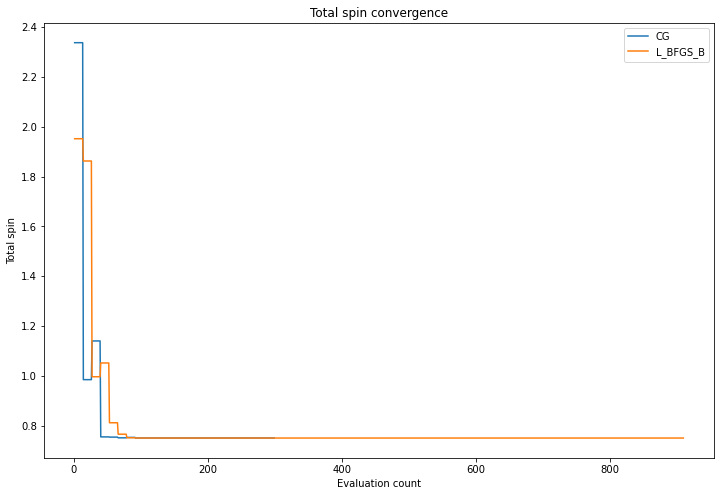

In [90]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [91]:
lab_list2=[(1,1.5,-0.5),(1,1.5,0.5)]
cost_conv2=[]
for l in lab_list2:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv2.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-02 12:45:51,235:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.30670324  0.34446284 -1.4668133  -2.20060079  0.61333247 -0.05563305
  2.02007636  1.66205103  1.62413961  0.44436083 -1.80692632 -1.6115741 ]
2021-03-02 12:45:51,239:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex 

### Cost function value and best states in the case of RY with depth $3$ and ent=$[(0,1),(1,2),(0,2)]$

In [92]:
for i,el in enumerate(cost_conv2):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  6.851253170164102e-13
| (1, 1.5, -0.5) >= (-0.357+0.000j) |000⟩ + (-0.148+0.000j) |100⟩ + (-0.148+0.000j) |010⟩ + (0.402+0.000j) |110⟩ + (-0.148+0.000j) |001⟩ + (0.403+0.000j) |101⟩ + (0.402+0.000j) |011⟩ + (-0.566+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999998
< ideal | optimal > =  0.6971795400782086 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  9.438445730462793e-11
| (1, 1.5, 0.5) >= (0.811+0.000j) |000⟩ + (-0.061+0.000j) |100⟩ + (-0.062+0.000j) |010⟩ + (0.034+0.000j) |110⟩ + (-0.061+0.000j) |001⟩ + (0.036+0.000j) |101⟩ + (0.037+0.000j) |011⟩ + (0.572+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999998
< ideal | optimal > =  -0.10582318526173992 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.697$ |  
|$(1,3/2,1/2)$ | $0.106$ | 

We don't see a significant improvement with the precision.

## Depth =3 and initial state with $\frac{1}{\sqrt{2}} \Bigl(|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle \Bigr)|\uparrow_2\rangle$

In the case of states $(s_L=1,s=3/2,s_z=-1/2)$ and $(s_L=1,s=3/2,s_z=1/2)$ we always have that the left spin $s_L=1$, therefore we know from the rules of Clebsh-Gordan coefficients that we want a state with the superposition $\frac{|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}}$ (triplet state with $s_L^z$).

In [67]:
qr=QuantumRegister(3,'q')
qc=QuantumCircuit(qr)

qc.h(0)
qc.x(1)
qc.cx(0,1)
#qc.h(2)
psi_custom   = Custom(3,state='zero',circuit=qc) # Here I custom the circuit
display(Markdown(r"Initial state $\psi_{custom}$"))
print(psi_custom.construct_circuit().draw())

Initial state $\psi_{custom}$

     ┌────────────┐     
q_0: ┤ U(π/2,0,π) ├──■──
     └┬──────────┬┘┌─┴─┐
q_1: ─┤ U(π,0,π) ├─┤ X ├
      └──────────┘ └───┘
q_2: ───────────────────
                        


In [94]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_custom,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌────────────┐     ┌──────────┐ ░            ░ ┌──────────┐ ░           »
q_0: ┤ U(π/2,0,π) ├──■──┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■───────»
     └┬──────────┬┘┌─┴─┐├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐     »
q_1: ─┤ U(π,0,π) ├─┤ X ├┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├─░─┤ X ├──■──»
      ├──────────┤ └───┘└──────────┘ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐»
q_2: ─┤ RY(θ[2]) ├───────────────────░──────┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├»
      └──────────┘                   ░      └───┘ ░ └──────────┘ ░      └───┘»
«      ░ ┌──────────┐ ░            ░  ┌──────────┐
«q_0: ─░─┤ RY(θ[6]) ├─░───■────────░──┤ RY(θ[9]) ├
«      ░ ├──────────┤ ░ ┌─┴─┐      ░ ┌┴──────────┤
«q_1: ─░─┤ RY(θ[7]) ├─░─┤ X ├──■───░─┤ RY(θ[10]) ├
«      ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├───────────┤
«q_2: ─░─┤ RY(θ[8]) ├─░──────┤ X ├─░─┤ RY(θ[11]) ├
«      ░ └──────────┘ ░      └───┘ ░ └───────────┘


In [95]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-02 14:01:52,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f90b31a56d0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f90b0523b80>>
-- initial_point: Random seed
-- var_form:      ┌─────────────┐     ┌──────────┐ ░            ░ ┌──────────┐ ░           »
q_0: ┤ U3(π/2,0,π) ├──■──┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■───────»
     └┬───────────┬┘┌─┴─┐├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐  

2021-03-02 14:01:52,012:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.26644869 -2.91010193  1.77663366 -1.64923722  0.38355832  2.97019824
  1.27873022 -1.99578456  1.81744386  1.53888683 -1.81637189  0.49473441]
2021-03-02 14:01:52,014:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-03-02 14:01:52,030:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-02 14:01:52,031:qiskit.aq

Optimizer: CG        

2021-03-02 14:01:52,203:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42598 (ms)
2021-03-02 14:01:52,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.86563696] - 7.33328 (ms), eval count: 22
2021-03-02 14:01:52,211:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21093 (ms)
2021-03-02 14:01:52,216:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.86563697] - 6.33502 (ms), eval count: 23
2021-03-02 14:01:52,220:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71709 (ms)
2021-03-02 14:01:52,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.86563696] - 6.86002 (ms), eval count: 24
2021-03-02 14:01:52,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10819 (ms)
2021-03-02 14:01:52,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-02 14:01:52,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75138931] - 7.50709 (ms), eval count: 53
2021-03-02 14:01:52,610:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20401 (ms)
2021-03-02 14:01:52,615:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75138931] - 5.96714 (ms), eval count: 54
2021-03-02 14:01:52,619:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43480 (ms)
2021-03-02 14:01:52,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75138931] - 6.29497 (ms), eval count: 55
2021-03-02 14:01:52,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38307 (ms)
2021-03-02 14:01:52,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75138931] - 7.99203 (ms), eval count: 56
2021-03-02 14:01:52,636:qiskit.aqua.operators.converters.c

2021-03-02 14:01:52,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.57404 (ms)
2021-03-02 14:01:52,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7504315] - 7.99060 (ms), eval count: 85
2021-03-02 14:01:52,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50299 (ms)
2021-03-02 14:01:52,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7504315] - 6.18911 (ms), eval count: 86
2021-03-02 14:01:52,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53089 (ms)
2021-03-02 14:01:52,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7504315] - 7.16186 (ms), eval count: 87
2021-03-02 14:01:52,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37281 (ms)
2021-03-02 14:01:52,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation 

2021-03-02 14:01:53,341:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19686 (ms)
2021-03-02 14:01:53,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003649] - 5.34987 (ms), eval count: 116
2021-03-02 14:01:53,349:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18701 (ms)
2021-03-02 14:01:53,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003649] - 7.07579 (ms), eval count: 117
2021-03-02 14:01:53,357:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42288 (ms)
2021-03-02 14:01:53,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75014396] - 6.69479 (ms), eval count: 118
2021-03-02 14:01:53,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38674 (ms)
2021-03-02 14:01:53,373:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-02 14:01:53,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90592 (ms)
2021-03-02 14:01:53,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000069] - 12.51006 (ms), eval count: 147
2021-03-02 14:01:53,687:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20490 (ms)
2021-03-02 14:01:53,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000069] - 7.06983 (ms), eval count: 148
2021-03-02 14:01:53,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20425 (ms)
2021-03-02 14:01:53,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000069] - 8.07714 (ms), eval count: 149
2021-03-02 14:01:53,708:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10214 (ms)
2021-03-02 14:01:53,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-02 14:01:53,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 9.64713 (ms), eval count: 178
2021-03-02 14:01:54,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71988 (ms)
2021-03-02 14:01:54,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 8.04305 (ms), eval count: 179
2021-03-02 14:01:54,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.29194 (ms)
2021-03-02 14:01:54,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 10.97894 (ms), eval count: 180
2021-03-02 14:01:54,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40278 (ms)
2021-03-02 14:01:54,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 7.01785 (ms), eval count: 181
2021-03-02 14:01:54,036:qiskit.aqua.operators.convert

2021-03-02 14:01:54,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84989 (ms)
2021-03-02 14:01:54,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.22322 (ms), eval count: 210
2021-03-02 14:01:54,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16293 (ms)
2021-03-02 14:01:54,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.74400 (ms), eval count: 211
2021-03-02 14:01:54,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96981 (ms)
2021-03-02 14:01:54,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.67644 (ms), eval count: 212
2021-03-02 14:01:54,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68514 (ms)
2021-03-02 14:01:54,372:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 14:01:54,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49202 (ms)
2021-03-02 14:01:54,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.04534 (ms), eval count: 242
2021-03-02 14:01:54,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16007 (ms)
2021-03-02 14:01:54,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.15399 (ms), eval count: 243
2021-03-02 14:01:54,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17087 (ms)
2021-03-02 14:01:54,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.24497 (ms), eval count: 244
2021-03-02 14:01:54,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.32410 (ms)
2021-03-02 14:01:54,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-02 14:01:54,983:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 2.970442295074463 seconds.
Found opt_params [ 2.34046553 -2.79621623  2.10592607 -1.57522045  0.25705854  2.77766566
  1.41030475 -2.67497919  1.13696515  2.30131385 -1.62571467  0.05155635] in 273 evals
2021-03-02 14:01:55,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x7f90b31a55b0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_s

2021-03-02 14:01:55,016:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.69448192  1.09961458  1.23143918  0.3458845   1.8376731  -1.42564204
  2.99094415 -2.71664124  2.51811392 -2.59278937 -0.92286603  0.68753128]
2021-03-02 14:01:55,031:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-02 14:01:55,035:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 21 operations with depth 12
op_counts

optimal_parameters {Parameter(θ[0]): 2.340465534226454, Parameter(θ[10]): -2.7962162299992404, Parameter(θ[11]): 2.1059260680118963, Parameter(θ[1]): -1.5752204480733951, Parameter(θ[2]): 0.257058542546429, Parameter(θ[3]): 2.7776656590178055, Parameter(θ[4]): 1.4103047484580924, Parameter(θ[5]): -2.67497918673157, Parameter(θ[6]): 1.1369651522082747, Parameter(θ[7]): 2.3013138549222742, Parameter(θ[8]): -1.625714669530558, Parameter(θ[9]): 0.05155634724947836}
optimal_point [ 2.34046553 -2.79621623  2.10592607 -1.57522045  0.25705854  2.77766566
  1.41030475 -2.67497919  1.13696515  2.30131385 -1.62571467  0.05155635]
optimal_value 0.7500000000000013
optimizer_evals 273
optimizer_time 2.970442295074463
eigenvalue (0.7500000000000013+0j)
eigenstate [ 9.84452535e-09+0.j -2.06925051e-01+0.j  1.37709191e-01+0.j
 -6.28986115e-01+0.j  6.92158389e-02+0.j  7.26798815e-01+0.j
 -9.78126760e-02+0.j  3.04034673e-09+0.j]
cost_function_evals 273
Optimizer: L_BFGS_B        

2021-03-02 14:01:55,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.16419265] - 11.36518 (ms), eval count: 15
2021-03-02 14:01:55,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90895 (ms)
2021-03-02 14:01:55,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.16419265] - 10.20288 (ms), eval count: 16
2021-03-02 14:01:55,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17302 (ms)
2021-03-02 14:01:55,230:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.16419265] - 6.17886 (ms), eval count: 17
2021-03-02 14:01:55,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85704 (ms)
2021-03-02 14:01:55,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.16419265] - 6.18815 (ms), eval count: 18
2021-03-02 14:01:55,242:qiskit.aqua.operators.converters

2021-03-02 14:01:55,524:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51825 (ms)
2021-03-02 14:01:55,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76184128] - 6.67310 (ms), eval count: 47
2021-03-02 14:01:55,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42908 (ms)
2021-03-02 14:01:55,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76184128] - 6.40082 (ms), eval count: 48
2021-03-02 14:01:55,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21212 (ms)
2021-03-02 14:01:55,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76184128] - 6.94513 (ms), eval count: 49
2021-03-02 14:01:55,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25282 (ms)
2021-03-02 14:01:55,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-02 14:01:55,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75210446] - 8.38780 (ms), eval count: 78
2021-03-02 14:01:55,887:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44601 (ms)
2021-03-02 14:01:55,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75004951] - 7.81202 (ms), eval count: 79
2021-03-02 14:01:55,898:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65796 (ms)
2021-03-02 14:01:55,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75004951] - 5.51701 (ms), eval count: 80
2021-03-02 14:01:55,906:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64318 (ms)
2021-03-02 14:01:55,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75004951] - 7.36403 (ms), eval count: 81
2021-03-02 14:01:55,917:qiskit.aqua.operators.converters.c

2021-03-02 14:01:56,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500002] - 6.27995 (ms), eval count: 109
2021-03-02 14:01:56,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69706 (ms)
2021-03-02 14:01:56,245:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500002] - 10.83517 (ms), eval count: 110
2021-03-02 14:01:56,248:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87707 (ms)
2021-03-02 14:01:56,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500002] - 10.50973 (ms), eval count: 111
2021-03-02 14:01:56,260:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87111 (ms)
2021-03-02 14:01:56,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500002] - 6.83212 (ms), eval count: 112
2021-03-02 14:01:56,267:qiskit.aqua.operators.converters

2021-03-02 14:01:56,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.80878 (ms), eval count: 140
2021-03-02 14:01:56,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24431 (ms)
2021-03-02 14:01:56,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 9.07898 (ms), eval count: 141
2021-03-02 14:01:56,578:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33419 (ms)
2021-03-02 14:01:56,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.56502 (ms), eval count: 142
2021-03-02 14:01:56,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.52397 (ms)
2021-03-02 14:01:56,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.06687 (ms), eval count: 143
2021-03-02 14:01:56,596:qiskit.aqua.operators.converte

2021-03-02 14:01:56,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 6.78015 (ms), eval count: 171
2021-03-02 14:01:56,904:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20902 (ms)
2021-03-02 14:01:56,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 6.57392 (ms), eval count: 172
2021-03-02 14:01:56,913:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68300 (ms)
2021-03-02 14:01:56,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 9.66501 (ms), eval count: 173
2021-03-02 14:01:56,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70104 (ms)
2021-03-02 14:01:56,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000006] - 9.00078 (ms), eval count: 174
2021-03-02 14:01:56,943:qiskit.aqua.operators.converte

2021-03-02 14:01:57,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.45273 (ms), eval count: 202
2021-03-02 14:01:57,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58906 (ms)
2021-03-02 14:01:57,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.16886 (ms), eval count: 203
2021-03-02 14:01:57,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65503 (ms)
2021-03-02 14:01:57,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.27489 (ms), eval count: 204
2021-03-02 14:01:57,323:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34015 (ms)
2021-03-02 14:01:57,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.71196 (ms), eval count: 205
2021-03-02 14:01:57,332:qiskit.aqua.operators.convert

2021-03-02 14:01:57,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.56025 (ms), eval count: 233
2021-03-02 14:01:57,680:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15895 (ms)
2021-03-02 14:01:57,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.49595 (ms), eval count: 234
2021-03-02 14:01:57,690:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29287 (ms)
2021-03-02 14:01:57,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.78782 (ms), eval count: 235
2021-03-02 14:01:57,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98603 (ms)
2021-03-02 14:01:57,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.90391 (ms), eval count: 236
2021-03-02 14:01:57,719:qiskit.aqua.operators.convert

2021-03-02 14:01:58,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.16004 (ms), eval count: 264
2021-03-02 14:01:58,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.56999 (ms)
2021-03-02 14:01:58,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.47228 (ms), eval count: 265
2021-03-02 14:01:58,083:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39499 (ms)
2021-03-02 14:01:58,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.83992 (ms), eval count: 266
2021-03-02 14:01:58,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65915 (ms)
2021-03-02 14:01:58,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.55501 (ms), eval count: 267
2021-03-02 14:01:58,103:qiskit.aqua.operators.converte

2021-03-02 14:01:58,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.81989 (ms), eval count: 295
2021-03-02 14:01:58,404:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21920 (ms)
2021-03-02 14:01:58,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.57289 (ms), eval count: 296
2021-03-02 14:01:58,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21784 (ms)
2021-03-02 14:01:58,419:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.60476 (ms), eval count: 297
2021-03-02 14:01:58,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72369 (ms)
2021-03-02 14:01:58,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.72009 (ms), eval count: 298
2021-03-02 14:01:58,439:qiskit.aqua.operators.converte

2021-03-02 14:01:58,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 13.74388 (ms), eval count: 326
2021-03-02 14:01:58,766:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43306 (ms)
2021-03-02 14:01:58,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.25999 (ms), eval count: 327
2021-03-02 14:01:58,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26314 (ms)
2021-03-02 14:01:58,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 4.79198 (ms), eval count: 328
2021-03-02 14:01:58,785:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78790 (ms)
2021-03-02 14:01:58,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.01277 (ms), eval count: 329
2021-03-02 14:01:58,797:qiskit.aqua.operators.convert

2021-03-02 14:01:59,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.04806 (ms), eval count: 357
2021-03-02 14:01:59,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42114 (ms)
2021-03-02 14:01:59,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.91678 (ms), eval count: 358
2021-03-02 14:01:59,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12479 (ms)
2021-03-02 14:01:59,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.35807 (ms), eval count: 359
2021-03-02 14:01:59,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16913 (ms)
2021-03-02 14:01:59,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.08413 (ms), eval count: 360
2021-03-02 14:01:59,122:qiskit.aqua.operators.converte

optimal_parameters {Parameter(θ[0]): -0.4342354114231297, Parameter(θ[10]): 1.0506104991449625, Parameter(θ[11]): 1.45957316538801, Parameter(θ[1]): 0.6069884776107547, Parameter(θ[2]): 1.802792354507084, Parameter(θ[3]): -1.7558661340887218, Parameter(θ[4]): 2.814561267920205, Parameter(θ[5]): -2.8497079519280195, Parameter(θ[6]): 2.284502994800857, Parameter(θ[7]): -2.288068702656271, Parameter(θ[8]): -1.1824429087444115, Parameter(θ[9]): 0.5080258207477599}
optimal_point [-0.43423541  1.0506105   1.45957317  0.60698848  1.80279235 -1.75586613
  2.81456127 -2.84970795  2.28450299 -2.2880687  -1.18244291  0.50802582]
optimal_value 0.7500000108266178
optimizer_evals 377
optimizer_time 4.296334981918335
eigenvalue (0.7500000108266178+0j)
eigenstate [ 1.43814993e-05+0.j  2.72888918e-01+0.j -5.68094957e-01+0.j
  5.60328707e-01+0.j  2.95166315e-01+0.j -4.29735418e-01+0.j
 -1.30521314e-01+0.j  3.39005410e-05+0.j]
cost_function_evals 377


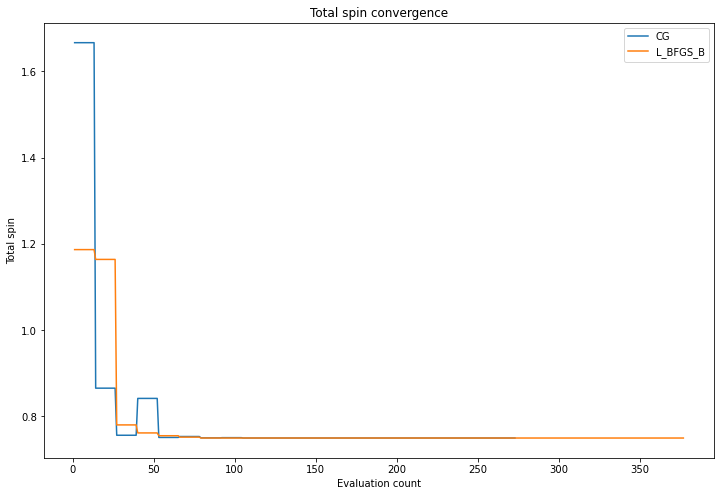

In [96]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [99]:
lab_list2=[(1,1.5,-0.5),(1,1.5,0.5)]
cost_conv2=[]
for l in lab_list2:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv2.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-02 14:03:53,105:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.40343987 -2.84269986  1.81510355  0.60169579 -0.91242112 -0.16408529
  2.30062082  2.50384625  2.24444939 -2.0175269   1.51767494 -1.19438278]
2021-03-02 14:03:53,108:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex 

### Cost function value and best states in the case of RY with depth $3$ and initial state $\frac{|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}}|\uparrow_2\rangle$

In [100]:
for i,el in enumerate(cost_conv2):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  2.3844265014873535e-13
| (1, 1.5, -0.5) >= (0.197+0.000j) |000⟩ + (-0.045+0.000j) |100⟩ + (-0.045+0.000j) |010⟩ + (0.539+0.000j) |110⟩ + (-0.045+0.000j) |001⟩ + (0.539+0.000j) |101⟩ + (0.539+0.000j) |011⟩ + (0.289+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999999
< ideal | optimal > =  0.9334700196582907 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  7.620750671536917e-13
| (1, 1.5, 0.5) >= (0.685+0.000j) |000⟩ + (-0.174+0.000j) |100⟩ + (-0.173+0.000j) |010⟩ + (-0.371+0.000j) |110⟩ + (-0.174+0.000j) |001⟩ + (-0.371+0.000j) |101⟩ + (-0.371+0.000j) |011⟩ + (0.166+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999997
< ideal | optimal > =  -0.3003603421492932 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.933$ |  
|$(1,3/2,1/2)$ | $0.300$ | 


We see an improvement in both states by choosing as initial state the triplet state with $s_L^z=0$, especially in the first of the two. However, the second state is really far from the precision of other spin eigenstates.

# SO4 Variational Quantum Eigensolver

In [8]:
from  typing import List, Optional, Union
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import InitialState

class so4(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        self._connections = connections
        self._num_parameters = len(connections)*reps*6
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    def append_so4(self,circuit,qubit1,qubit2,parameters):
        circuit.s(qubit1)
        circuit.s(qubit2)
        circuit.h(qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.u3(parameters[0],parameters[1],parameters[2],qubit1)
        circuit.u3(parameters[3],parameters[4],parameters[5],qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.h(qubit2)
        circuit.sdg(qubit1)
        circuit.sdg(qubit2)

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        m = 0
        for l in range(self._reps):
            for [i,j] in self._connections:
                self.append_so4(circuit,i,j,parameters[6*m:6*(m+1)])
                m += 1
        return circuit

### Depth $1$ and initial state  $| 0 \rangle^{\otimes 3}$
We start with the initial state $|\psi_1 \rangle = | 0 \rangle^{\otimes 3}$ and depth of the circuit equal to $1$.

In [13]:
var_form  = so4(num_qubits=3,reps=1,connections=[(0,1),(1,2)],initial_state=psi_1) # Ansatz SO(4)
print("Number of parameters in so4: ", var_form.num_parameters)

Number of parameters in so4:  12


In [14]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-03 10:54:23,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fb78f6f7430>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fb78f6f7e80>>
-- initial_point: Random seed
-- var_form: <__main__.so4 object at 0x7fb78f6bd6d0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callba

Optimizer: CG        

2021-03-03 10:54:24,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.87473842] - 896.38233 (ms), eval count: 1
2021-03-03 10:54:24,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30510 (ms)
2021-03-03 10:54:24,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.87473841] - 6.23798 (ms), eval count: 2
2021-03-03 10:54:24,585:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30987 (ms)
2021-03-03 10:54:24,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.87473841] - 5.87273 (ms), eval count: 3
2021-03-03 10:54:24,592:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30391 (ms)
2021-03-03 10:54:24,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.87473843] - 5.24402 (ms), eval count: 4
2021-03-03 10:54:24,599:qiskit.aqua.operators.converters.cir

2021-03-03 10:54:24,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71583 (ms)
2021-03-03 10:54:24,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06088723] - 11.11603 (ms), eval count: 33
2021-03-03 10:54:24,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88994 (ms)
2021-03-03 10:54:24,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06088723] - 8.04520 (ms), eval count: 34
2021-03-03 10:54:24,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58780 (ms)
2021-03-03 10:54:24,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06088722] - 10.88595 (ms), eval count: 35
2021-03-03 10:54:24,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29192 (ms)
2021-03-03 10:54:24,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-03-03 10:54:25,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84218419] - 5.47886 (ms), eval count: 64
2021-03-03 10:54:25,195:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05493 (ms)
2021-03-03 10:54:25,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84218418] - 8.33893 (ms), eval count: 65
2021-03-03 10:54:25,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55807 (ms)
2021-03-03 10:54:25,210:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75327082] - 6.90293 (ms), eval count: 66
2021-03-03 10:54:25,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15602 (ms)
2021-03-03 10:54:25,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75327082] - 7.57003 (ms), eval count: 67
2021-03-03 10:54:25,224:qiskit.aqua.operators.converters.c

2021-03-03 10:54:25,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83511 (ms)
2021-03-03 10:54:25,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75030522] - 5.76806 (ms), eval count: 96
2021-03-03 10:54:25,486:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93095 (ms)
2021-03-03 10:54:25,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75030522] - 5.83887 (ms), eval count: 97
2021-03-03 10:54:25,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19893 (ms)
2021-03-03 10:54:25,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75030522] - 7.47895 (ms), eval count: 98
2021-03-03 10:54:25,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81508 (ms)
2021-03-03 10:54:25,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-03 10:54:25,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37806 (ms)
2021-03-03 10:54:25,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000917] - 5.53584 (ms), eval count: 127
2021-03-03 10:54:25,843:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39213 (ms)
2021-03-03 10:54:25,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000917] - 6.11591 (ms), eval count: 128
2021-03-03 10:54:25,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15895 (ms)
2021-03-03 10:54:25,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000917] - 5.25904 (ms), eval count: 129
2021-03-03 10:54:25,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16301 (ms)
2021-03-03 10:54:25,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:26,170:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33872 (ms)
2021-03-03 10:54:26,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000184] - 6.03390 (ms), eval count: 158
2021-03-03 10:54:26,178:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77503 (ms)
2021-03-03 10:54:26,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000184] - 6.08492 (ms), eval count: 159
2021-03-03 10:54:26,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73116 (ms)
2021-03-03 10:54:26,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000184] - 5.60403 (ms), eval count: 160
2021-03-03 10:54:26,192:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35589 (ms)
2021-03-03 10:54:26,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:26,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.12490 (ms), eval count: 189
2021-03-03 10:54:26,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18995 (ms)
2021-03-03 10:54:26,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.18410 (ms), eval count: 190
2021-03-03 10:54:26,521:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49035 (ms)
2021-03-03 10:54:26,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 16.82997 (ms), eval count: 191
2021-03-03 10:54:26,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19805 (ms)
2021-03-03 10:54:26,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.58190 (ms), eval count: 192
2021-03-03 10:54:26,556:qiskit.aqua.operators.converters.circuit_sampler:DEB

2021-03-03 10:54:26,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.09374 (ms), eval count: 221
2021-03-03 10:54:26,842:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92213 (ms)
2021-03-03 10:54:26,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.36601 (ms), eval count: 222
2021-03-03 10:54:26,850:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91808 (ms)
2021-03-03 10:54:26,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.13999 (ms), eval count: 223
2021-03-03 10:54:26,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81293 (ms)
2021-03-03 10:54:26,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.74004 (ms), eval count: 224
2021-03-03 10:54:26,874:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2021-03-03 10:54:27,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 13.60989 (ms), eval count: 253
2021-03-03 10:54:27,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29199 (ms)
2021-03-03 10:54:27,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.98018 (ms), eval count: 254
2021-03-03 10:54:27,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22206 (ms)
2021-03-03 10:54:27,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.19395 (ms), eval count: 255
2021-03-03 10:54:27,207:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53279 (ms)
2021-03-03 10:54:27,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.11711 (ms), eval count: 256
2021-03-03 10:54:27,216:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2021-03-03 10:54:27,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.70919 (ms), eval count: 285
2021-03-03 10:54:27,507:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20091 (ms)
2021-03-03 10:54:27,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 18.05902 (ms), eval count: 286
2021-03-03 10:54:27,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 3.8642029762268066 seconds.
Found opt_params [-3.02334431 -1.30006826 -0.48064348 -0.89230329  0.68691609  2.26863343
  0.35102667  2.3729462  -0.24720836  1.85971511 -2.30834033 -1.10443851] in 286 evals
2021-03-03 10:54:27,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: Fals

2021-03-03 10:54:27,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 7.61819 (ms), eval count: 14
2021-03-03 10:54:27,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68610 (ms)
2021-03-03 10:54:27,726:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 7.68900 (ms), eval count: 15
2021-03-03 10:54:27,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12605 (ms)
2021-03-03 10:54:27,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 6.59299 (ms), eval count: 16
2021-03-03 10:54:27,736:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13583 (ms)
2021-03-03 10:54:27,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 5.73182 (ms), eval count: 17


optimal_parameters {Parameter(θ[0]): -3.023344310940525, Parameter(θ[1]): -1.3000682585363381, Parameter(θ[2]): -0.48064348494726883, Parameter(θ[3]): -0.8923032936512281, Parameter(θ[4]): 0.6869160884038479, Parameter(θ[5]): 2.268633434083911, Parameter(θ[6]): 0.35102667271976457, Parameter(θ[7]): 2.37294619569278, Parameter(θ[8]): -0.24720836359311726, Parameter(θ[9]): 1.859715114953757, Parameter(θ[10]): -2.308340332781163, Parameter(θ[11]): -1.1044385111824777}
optimal_point [-3.02334431 -1.30006826 -0.48064348 -0.89230329  0.68691609  2.26863343
  0.35102667  2.3729462  -0.24720836  1.85971511 -2.30834033 -1.10443851]
optimal_value 0.7500000000000002
optimizer_evals 286
optimizer_time 3.8642029762268066
eigenvalue (0.7500000000000002+0j)
eigenstate [-6.15038462e-09+3.45409012e-10j  5.86675672e-01-3.29480275e-02j
 -3.40773972e-01+1.91380532e-02j -5.05098986e-01+2.83666361e-02j
 -2.45901698e-01+1.38099743e-02j  4.68634594e-01-2.63187759e-02j
  3.64643955e-02-2.04786045e-03j -6.26301

2021-03-03 10:54:27,745:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19495 (ms)
2021-03-03 10:54:27,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 15.44499 (ms), eval count: 18
2021-03-03 10:54:27,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13702 (ms)
2021-03-03 10:54:27,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 4.33183 (ms), eval count: 19
2021-03-03 10:54:27,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79195 (ms)
2021-03-03 10:54:27,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.73997806] - 9.36389 (ms), eval count: 20
2021-03-03 10:54:27,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38903 (ms)
2021-03-03 10:54:27,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-03-03 10:54:28,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81031925] - 7.22623 (ms), eval count: 49
2021-03-03 10:54:28,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18780 (ms)
2021-03-03 10:54:28,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81031925] - 6.81496 (ms), eval count: 50
2021-03-03 10:54:28,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82686 (ms)
2021-03-03 10:54:28,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81031925] - 16.45303 (ms), eval count: 51
2021-03-03 10:54:28,086:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09427 (ms)
2021-03-03 10:54:28,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81031925] - 13.83877 (ms), eval count: 52
2021-03-03 10:54:28,102:qiskit.aqua.operators.converters

2021-03-03 10:54:28,390:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15609 (ms)
2021-03-03 10:54:28,396:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77712189] - 6.77180 (ms), eval count: 81
2021-03-03 10:54:28,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12891 (ms)
2021-03-03 10:54:28,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77712189] - 7.47776 (ms), eval count: 82
2021-03-03 10:54:28,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14202 (ms)
2021-03-03 10:54:28,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77712189] - 5.38301 (ms), eval count: 83
2021-03-03 10:54:28,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16920 (ms)
2021-03-03 10:54:28,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-03 10:54:28,708:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16014 (ms)
2021-03-03 10:54:28,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75443801] - 6.35695 (ms), eval count: 112
2021-03-03 10:54:28,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28524 (ms)
2021-03-03 10:54:28,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75443801] - 11.45220 (ms), eval count: 113
2021-03-03 10:54:28,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16706 (ms)
2021-03-03 10:54:28,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75443801] - 7.67589 (ms), eval count: 114
2021-03-03 10:54:28,742:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83711 (ms)
2021-03-03 10:54:28,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 10:54:29,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.56283 (ms)
2021-03-03 10:54:29,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75021596] - 8.08096 (ms), eval count: 143
2021-03-03 10:54:29,036:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78790 (ms)
2021-03-03 10:54:29,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75004568] - 7.02906 (ms), eval count: 144
2021-03-03 10:54:29,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39594 (ms)
2021-03-03 10:54:29,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75004568] - 4.49800 (ms), eval count: 145
2021-03-03 10:54:29,053:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33300 (ms)
2021-03-03 10:54:29,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:29,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40905 (ms)
2021-03-03 10:54:29,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000194] - 6.69098 (ms), eval count: 174
2021-03-03 10:54:29,352:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63388 (ms)
2021-03-03 10:54:29,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000194] - 5.88107 (ms), eval count: 175
2021-03-03 10:54:29,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11485 (ms)
2021-03-03 10:54:29,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000194] - 6.10781 (ms), eval count: 176
2021-03-03 10:54:29,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12224 (ms)
2021-03-03 10:54:29,373:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:29,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88494 (ms)
2021-03-03 10:54:29,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.24275 (ms), eval count: 205
2021-03-03 10:54:29,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33889 (ms)
2021-03-03 10:54:29,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.03007 (ms), eval count: 206
2021-03-03 10:54:29,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19710 (ms)
2021-03-03 10:54:29,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.10814 (ms), eval count: 207
2021-03-03 10:54:29,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11103 (ms)
2021-03-03 10:54:29,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 10:54:29,986:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70112 (ms)
2021-03-03 10:54:29,992:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.85398 (ms), eval count: 236
2021-03-03 10:54:29,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17493 (ms)
2021-03-03 10:54:29,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.74231 (ms), eval count: 237
2021-03-03 10:54:30,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11294 (ms)
2021-03-03 10:54:30,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.27177 (ms), eval count: 238
2021-03-03 10:54:30,013:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21093 (ms)
2021-03-03 10:54:30,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:30,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16992 (ms)
2021-03-03 10:54:30,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.26802 (ms), eval count: 267
2021-03-03 10:54:30,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89392 (ms)
2021-03-03 10:54:30,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.50196 (ms), eval count: 268
2021-03-03 10:54:30,350:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34175 (ms)
2021-03-03 10:54:30,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.64496 (ms), eval count: 269
2021-03-03 10:54:30,361:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51913 (ms)
2021-03-03 10:54:30,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 10:54:30,647:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35002 (ms)
2021-03-03 10:54:30,654:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.53007 (ms), eval count: 298
2021-03-03 10:54:30,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12367 (ms)
2021-03-03 10:54:30,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 4.99892 (ms), eval count: 299
2021-03-03 10:54:30,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12097 (ms)
2021-03-03 10:54:30,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.95307 (ms), eval count: 300
2021-03-03 10:54:30,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99294 (ms)
2021-03-03 10:54:30,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:30,957:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10483 (ms)
2021-03-03 10:54:30,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.41920 (ms), eval count: 329
2021-03-03 10:54:30,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21999 (ms)
2021-03-03 10:54:30,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.36296 (ms), eval count: 330
2021-03-03 10:54:30,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17612 (ms)
2021-03-03 10:54:30,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.54387 (ms), eval count: 331
2021-03-03 10:54:31,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45612 (ms)
2021-03-03 10:54:31,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 10:54:31,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39689 (ms)
2021-03-03 10:54:31,301:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.01389 (ms), eval count: 360
2021-03-03 10:54:31,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05398 (ms)
2021-03-03 10:54:31,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.05004 (ms), eval count: 361
2021-03-03 10:54:31,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04802 (ms)
2021-03-03 10:54:31,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.99194 (ms), eval count: 362
2021-03-03 10:54:31,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11103 (ms)
2021-03-03 10:54:31,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:31,603:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03595 (ms)
2021-03-03 10:54:31,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.17411 (ms), eval count: 391
2021-03-03 10:54:31,612:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05803 (ms)
2021-03-03 10:54:31,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.93607 (ms), eval count: 392
2021-03-03 10:54:31,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60503 (ms)
2021-03-03 10:54:31,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.50811 (ms), eval count: 393
2021-03-03 10:54:31,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12891 (ms)
2021-03-03 10:54:31,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:31,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60711 (ms)
2021-03-03 10:54:31,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.56502 (ms), eval count: 422
2021-03-03 10:54:31,926:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93810 (ms)
2021-03-03 10:54:31,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.30777 (ms), eval count: 423
2021-03-03 10:54:31,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47724 (ms)
2021-03-03 10:54:31,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.11186 (ms), eval count: 424
2021-03-03 10:54:31,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00295 (ms)
2021-03-03 10:54:31,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 10:54:32,209:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73903 (ms)
2021-03-03 10:54:32,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.91421 (ms), eval count: 453
2021-03-03 10:54:32,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18399 (ms)
2021-03-03 10:54:32,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.72983 (ms), eval count: 454
2021-03-03 10:54:32,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87612 (ms)
2021-03-03 10:54:32,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.14779 (ms), eval count: 455
2021-03-03 10:54:32,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 4.714064836502075 seconds.
Found opt_params [ 1.57545102  0.24456811 -0.11371169  2.75128605 -2.1916

optimal_parameters {Parameter(θ[0]): 1.575451023474982, Parameter(θ[1]): 0.2445681135173182, Parameter(θ[2]): -0.11371169410958389, Parameter(θ[3]): 2.751286049330775, Parameter(θ[4]): -2.191676626300417, Parameter(θ[5]): 0.9184051052569188, Parameter(θ[6]): 3.141592653589292, Parameter(θ[7]): -2.7755470418407637, Parameter(θ[8]): -0.15240655926917962, Parameter(θ[9]): -2.7920460919133285, Parameter(θ[10]): 1.180896178044602, Parameter(θ[11]): 1.9898057576347465}
optimal_point [ 1.57545102  0.24456811 -0.11371169  2.75128605 -2.19167663  0.91840511
  3.14159265 -2.77554704 -0.15240656 -2.79204609  1.18089618  1.98980576]
optimal_value 0.7500000083112771
optimizer_evals 455
optimizer_time 4.714064836502075
eigenvalue (0.7500000083112771+0j)
eigenstate [ 3.97710401e-05-1.92034303e-05j -7.04204737e-02+3.40024966e-02j
  4.03572301e-01-1.94864719e-01j -4.78032879e-02+2.30817978e-02j
 -3.33120584e-01+1.60847137e-01j  5.38070234e-01-2.59806990e-01j
 -4.90236454e-01+2.36710469e-01j -5.43992701

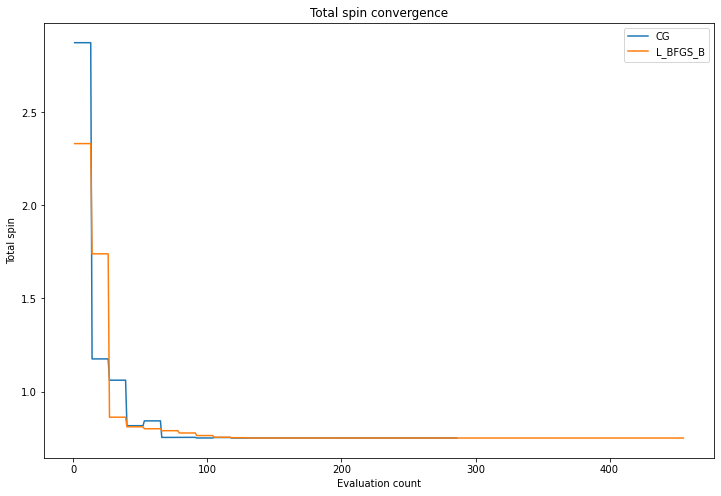

In [15]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [18]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

cost_conv3=[]
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)       # To use with so4
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv3.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-03 10:57:12,142:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.616287   -1.97750434  1.23894253 -2.22523621  0.52961161  1.33701262
 -3.13762188  0.77254427 -0.06906129  1.68942127 -1.77493082 -0.09850034]
2021-03-03 10:57:12,145:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex 

2021-03-03 10:58:37,025:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/li

### Cost function value and best states in the case of SO4 with depth = 1 and initial state $|\psi_1 \rangle = | 0 \rangle^{\otimes 5}$

In [19]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
    if i==5 or i==6:
        best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4
    else:
        best_circ=var_form.construct_circuit(el['optimal_point']) 
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi))),"\n")

State label:  (0, 0.5, -0.5)  , C(s_L,s,s_z) =  1.2704218195603034e-15
| (0, 0.5, -0.5) >=  + (0.367-0.605j) |101⟩ + (-0.367+0.605j) |011⟩
<optimal|optimal> =  0.268672019781909
< ideal | optimal > =  -0.5183358134163256 

State label:  (0, 0.5, 0.5)  , C(s_L,s,s_z) =  3.082016028427432e-14
| (0, 0.5, 0.5) >=  + (0.573-0.414j) |100⟩ + (-0.573+0.414j) |010⟩
<optimal|optimal> =  0.657311906882492
< ideal | optimal > =  -0.8107477126663122 

State label:  (1, 0.5, -0.5)  , C(s_L,s,s_z) =  4.7200391575889005e-15
| (1, 0.5, -0.5) >=  + (0.612+0.541j) |110⟩ + (-0.306-0.270j) |101⟩ + (-0.306-0.270j) |011⟩
<optimal|optimal> =  0.5612249499109692
< ideal | optimal > =  -0.7491494611466722 

State label:  (1, 0.5, 0.5)  , C(s_L,s,s_z) =  9.350555322202923e-15
| (1, 0.5, 0.5) >=  + (0.293-0.285j) |100⟩ + (0.293-0.285j) |010⟩ + (-0.585+0.569j) |001⟩
<optimal|optimal> =  0.5139992991545873
< ideal | optimal > =  -0.7169374090597912 

State label:  (1, 1.5, -1.5)  , C(s_L,s,s_z) =  2.128558339913581

Some coefficients have complex values because *Qiskit* doesn't consider the invariance with respect to a global phase. Moreover, we notice that the absolute square value gives the exact coefficient.

Then, we are going to consider the states with the square of the absolute value of each coefficient.

In [20]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
    if i==5 or i==6:
        best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4
    else:
        best_circ=var_form.construct_circuit(el['optimal_point']) 
    best_psi=CircuitStateFn(best_circ).to_matrix()
    
    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))
    
    # The best state
    print("|",lab_list[i],">=",to_ket(best_psi_rot))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi_rot))),"\n")

State label:  (0, 0.5, -0.5)  , C(s_L,s,s_z) =  1.2704218195603034e-15
| (0, 0.5, -0.5) >=  + (0.707) |101⟩ + (-0.707) |011⟩
<optimal|optimal> =  0.9999999999999999
< ideal | optimal > =  -0.9999999919754481 

State label:  (0, 0.5, 0.5)  , C(s_L,s,s_z) =  3.082016028427432e-14
| (0, 0.5, 0.5) >=  + (0.707) |100⟩ + (-0.707) |010⟩
<optimal|optimal> =  1.0
< ideal | optimal > =  -0.9999999594645742 

State label:  (1, 0.5, -0.5)  , C(s_L,s,s_z) =  4.7200391575889005e-15
| (1, 0.5, -0.5) >=  + (0.817) |110⟩ + (-0.408) |101⟩ + (-0.408) |011⟩
<optimal|optimal> =  0.9999999999999993
< ideal | optimal > =  -0.9999999690189997 

State label:  (1, 0.5, 0.5)  , C(s_L,s,s_z) =  9.350555322202923e-15
| (1, 0.5, 0.5) >=  + (0.408) |100⟩ + (0.408) |010⟩ + (-0.816) |001⟩
<optimal|optimal> =  0.9999999999999996
< ideal | optimal > =  -0.9999999507341524 

State label:  (1, 1.5, -1.5)  , C(s_L,s,s_z) =  2.128558339913581e-14
| (1, 1.5, -1.5) >=  + (-1.000) |111⟩
<optimal|optimal> =  1.0000000000000002


By rotating each state of the same angle, we see that the all spin eigenstates are precise except for $(s_L=1,s=3/2,s_z=-1/2)$ and $(s_L=1,s=3/2,s_z=1/2)$. However, we see that those two states are more precise with respect to the states that we got with **RY**.

#### Dicke states

| Label $(s_{01},s,s_z)$| $\langle \psi_{ideal}|\psi_{optimal} \rangle$ | 
| :-: | :-: | 
|<img width=100/>|<img width=100/>|
|$(1,3/2,-1/2)$ | $0.499$ |  
|$(1,3/2,1/2)$ | $0.058$ | 

## Case of states $(s_L=1,s=3/2,s_z=-1/2)$ and $(s_L=1,s=3/2,s_z=1/2)$

### Depth $2$ and initial state $|0\rangle^{\otimes 3}$ 

In [21]:
var_form  = so4(num_qubits=3,reps=2,connections=[(0,1),(1,2)],initial_state=psi_1) # Ansatz SO(4)
print("Number of parameters in so4: ", var_form.num_parameters)

Number of parameters in so4:  24


In [22]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-03 11:02:39,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fb790ccbd30>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fb790ccb550>>
-- initial_point: Random seed
-- var_form: <__main__.so4 object at 0x7fb790ce3640>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]', 'θ[17]', 'θ[18]', 'θ[19]', '

2021-03-03 11:02:39,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07591 (ms)
2021-03-03 11:02:39,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440226] - 7.45893 (ms), eval count: 12
2021-03-03 11:02:39,691:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25496 (ms)
2021-03-03 11:02:39,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440224] - 8.68702 (ms), eval count: 13
2021-03-03 11:02:39,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10524 (ms)
2021-03-03 11:02:39,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440225] - 7.27105 (ms), eval count: 14
2021-03-03 11:02:39,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28524 (ms)
2021-03-03 11:02:39,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

Optimizer: CG        

2021-03-03 11:02:39,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440227] - 133.12626 (ms), eval count: 16
2021-03-03 11:02:39,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22509 (ms)
2021-03-03 11:02:39,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440226] - 7.80296 (ms), eval count: 17
2021-03-03 11:02:39,861:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69008 (ms)
2021-03-03 11:02:39,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440225] - 6.88910 (ms), eval count: 18
2021-03-03 11:02:39,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90775 (ms)
2021-03-03 11:02:39,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.52440227] - 7.24316 (ms), eval count: 19
2021-03-03 11:02:39,879:qiskit.aqua.operators.converters

2021-03-03 11:02:40,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84200972] - 6.60205 (ms), eval count: 47
2021-03-03 11:02:40,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76804 (ms)
2021-03-03 11:02:40,246:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84200972] - 9.03201 (ms), eval count: 48
2021-03-03 11:02:40,255:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.87406 (ms)
2021-03-03 11:02:40,263:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84200972] - 12.46309 (ms), eval count: 49
2021-03-03 11:02:40,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82924 (ms)
2021-03-03 11:02:40,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84200973] - 9.27901 (ms), eval count: 50
2021-03-03 11:02:40,280:qiskit.aqua.operators.converters.

2021-03-03 11:02:40,626:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.58886 (ms)
2021-03-03 11:02:40,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.99826784] - 23.03410 (ms), eval count: 79
2021-03-03 11:02:40,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46391 (ms)
2021-03-03 11:02:40,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.99826784] - 20.69306 (ms), eval count: 80
2021-03-03 11:02:40,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28500 (ms)
2021-03-03 11:02:40,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.99826784] - 11.58190 (ms), eval count: 81
2021-03-03 11:02:40,696:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.60267 (ms)
2021-03-03 11:02:40,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 11:02:41,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18415 (ms)
2021-03-03 11:02:41,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75039235] - 7.80487 (ms), eval count: 110
2021-03-03 11:02:41,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07806 (ms)
2021-03-03 11:02:41,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75039235] - 9.58180 (ms), eval count: 111
2021-03-03 11:02:41,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34413 (ms)
2021-03-03 11:02:41,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75039235] - 9.89580 (ms), eval count: 112
2021-03-03 11:02:41,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92802 (ms)
2021-03-03 11:02:41,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 11:02:41,448:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35629 (ms)
2021-03-03 11:02:41,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7548098] - 8.78692 (ms), eval count: 141
2021-03-03 11:02:41,459:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27714 (ms)
2021-03-03 11:02:41,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7548098] - 8.63791 (ms), eval count: 142
2021-03-03 11:02:41,469:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14808 (ms)
2021-03-03 11:02:41,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7548098] - 13.80086 (ms), eval count: 143
2021-03-03 11:02:41,486:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39015 (ms)
2021-03-03 11:02:41,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-03-03 11:02:41,827:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04182 (ms)
2021-03-03 11:02:41,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002085] - 6.88577 (ms), eval count: 172
2021-03-03 11:02:41,836:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25401 (ms)
2021-03-03 11:02:41,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002085] - 6.89578 (ms), eval count: 173
2021-03-03 11:02:41,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50602 (ms)
2021-03-03 11:02:41,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002085] - 8.44216 (ms), eval count: 174
2021-03-03 11:02:41,855:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17104 (ms)
2021-03-03 11:02:41,860:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 11:02:42,227:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77877 (ms)
2021-03-03 11:02:42,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000048] - 8.62098 (ms), eval count: 203
2021-03-03 11:02:42,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31504 (ms)
2021-03-03 11:02:42,241:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000048] - 7.84206 (ms), eval count: 204
2021-03-03 11:02:42,244:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05112 (ms)
2021-03-03 11:02:42,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000048] - 7.16901 (ms), eval count: 205
2021-03-03 11:02:42,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28922 (ms)
2021-03-03 11:02:42,259:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 11:02:42,608:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54488 (ms)
2021-03-03 11:02:42,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000546] - 13.60703 (ms), eval count: 234
2021-03-03 11:02:42,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03013 (ms)
2021-03-03 11:02:42,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000546] - 6.29687 (ms), eval count: 235
2021-03-03 11:02:42,631:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14100 (ms)
2021-03-03 11:02:42,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000546] - 12.33506 (ms), eval count: 236
2021-03-03 11:02:42,645:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05104 (ms)
2021-03-03 11:02:42,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-03 11:02:42,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.52091 (ms), eval count: 265
2021-03-03 11:02:42,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78997 (ms)
2021-03-03 11:02:42,984:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.57019 (ms), eval count: 266
2021-03-03 11:02:42,989:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25298 (ms)
2021-03-03 11:02:43,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 26.55387 (ms), eval count: 267
2021-03-03 11:02:43,027:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.70802 (ms)
2021-03-03 11:02:43,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 23.67687 (ms), eval count: 268
2021-03-03 11:02:43,042:qiskit.aqua.operators.converters.circuit_sampler:DE

2021-03-03 11:02:43,379:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12789 (ms)
2021-03-03 11:02:43,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000009] - 6.61492 (ms), eval count: 297
2021-03-03 11:02:43,387:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55489 (ms)
2021-03-03 11:02:43,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000009] - 7.36523 (ms), eval count: 298
2021-03-03 11:02:43,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39801 (ms)
2021-03-03 11:02:43,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000009] - 8.92520 (ms), eval count: 299
2021-03-03 11:02:43,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78497 (ms)
2021-03-03 11:02:43,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 11:02:43,766:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

optimal_parameters {Parameter(θ[0]): 0.3152128628307713, Parameter(θ[1]): 3.26610325226344, Parameter(θ[2]): 1.340730487834962, Parameter(θ[3]): 1.2421317699327894, Parameter(θ[4]): -2.785826281183525, Parameter(θ[5]): 1.8958167745272887, Parameter(θ[6]): -0.98402399626513, Parameter(θ[7]): -0.009656493151602377, Parameter(θ[8]): 0.8020845508407984, Parameter(θ[9]): 2.337618973989427, Parameter(θ[10]): 2.1046317922214346, Parameter(θ[11]): 1.0100488908217051, Parameter(θ[12]): -2.663899931441626, Parameter(θ[13]): 2.0238103892103254, Parameter(θ[14]): -2.6769193984303334, Parameter(θ[15]): 1.429335768680765, Parameter(θ[16]): 0.5920876997778958, Parameter(θ[17]): -1.687588391540751, Parameter(θ[18]): -0.6544223685767069, Parameter(θ[19]): -1.9678704544347776, Parameter(θ[20]): 0.24056474409356693, Parameter(θ[21]): -1.275674576795597, Parameter(θ[22]): -3.0796248107425037, Parameter(θ[23]): -2.9404322563355323}
optimal_point [ 0.31521286  3.26610325  1.34073049  1.24213177 -2.78582628 

2021-03-03 11:02:43,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.19303706] - 11.37710 (ms), eval count: 14
2021-03-03 11:02:43,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95226 (ms)
2021-03-03 11:02:43,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.19303706] - 10.09011 (ms), eval count: 15
2021-03-03 11:02:43,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38109 (ms)
2021-03-03 11:02:43,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.19303706] - 8.65889 (ms), eval count: 16
2021-03-03 11:02:43,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04103 (ms)
2021-03-03 11:02:43,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.19303706] - 7.49898 (ms), eval count: 17
2021-03-03 11:02:44,000:qiskit.aqua.operators.converters

2021-03-03 11:02:44,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.33071406] - 8.59284 (ms), eval count: 45
2021-03-03 11:02:44,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57206 (ms)
2021-03-03 11:02:44,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.33071406] - 12.69698 (ms), eval count: 46
2021-03-03 11:02:44,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2021-03-03 11:02:44,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.33071406] - 8.29101 (ms), eval count: 47
2021-03-03 11:02:44,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33087 (ms)
2021-03-03 11:02:44,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.33071406] - 9.78112 (ms), eval count: 48
2021-03-03 11:02:44,368:qiskit.aqua.operators.converters.

2021-03-03 11:02:44,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.18165011] - 9.06587 (ms), eval count: 76
2021-03-03 11:02:44,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44205 (ms)
2021-03-03 11:02:44,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.18165011] - 12.41708 (ms), eval count: 77
2021-03-03 11:02:44,741:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55506 (ms)
2021-03-03 11:02:44,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.18165011] - 12.53510 (ms), eval count: 78
2021-03-03 11:02:44,755:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61085 (ms)
2021-03-03 11:02:44,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.18165011] - 9.65500 (ms), eval count: 79
2021-03-03 11:02:44,764:qiskit.aqua.operators.converters

2021-03-03 11:02:45,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75657171] - 10.65612 (ms), eval count: 107
2021-03-03 11:02:45,144:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33905 (ms)
2021-03-03 11:02:45,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75657171] - 8.37970 (ms), eval count: 108
2021-03-03 11:02:45,154:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35908 (ms)
2021-03-03 11:02:45,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75657171] - 8.86202 (ms), eval count: 109
2021-03-03 11:02:45,163:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03276 (ms)
2021-03-03 11:02:45,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75657171] - 9.10115 (ms), eval count: 110
2021-03-03 11:02:45,178:qiskit.aqua.operators.convert

2021-03-03 11:02:45,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75065996] - 8.30197 (ms), eval count: 138
2021-03-03 11:02:45,538:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53391 (ms)
2021-03-03 11:02:45,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75065996] - 9.15408 (ms), eval count: 139
2021-03-03 11:02:45,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08998 (ms)
2021-03-03 11:02:45,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75065996] - 14.70590 (ms), eval count: 140
2021-03-03 11:02:45,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04620 (ms)
2021-03-03 11:02:45,573:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75065996] - 8.97169 (ms), eval count: 141
2021-03-03 11:02:45,578:qiskit.aqua.operators.convert

2021-03-03 11:02:45,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75021753] - 13.06701 (ms), eval count: 169
2021-03-03 11:02:45,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81405 (ms)
2021-03-03 11:02:45,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75021753] - 10.51211 (ms), eval count: 170
2021-03-03 11:02:45,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19529 (ms)
2021-03-03 11:02:45,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75021753] - 8.82077 (ms), eval count: 171
2021-03-03 11:02:45,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20990 (ms)
2021-03-03 11:02:45,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75021753] - 8.08001 (ms), eval count: 172
2021-03-03 11:02:45,959:qiskit.aqua.operators.conver

2021-03-03 11:02:46,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75007639] - 17.42911 (ms), eval count: 200
2021-03-03 11:02:46,316:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46112 (ms)
2021-03-03 11:02:46,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000652] - 10.71405 (ms), eval count: 201
2021-03-03 11:02:46,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88010 (ms)
2021-03-03 11:02:46,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000652] - 7.93314 (ms), eval count: 202
2021-03-03 11:02:46,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29185 (ms)
2021-03-03 11:02:46,344:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000652] - 9.23085 (ms), eval count: 203
2021-03-03 11:02:46,349:qiskit.aqua.operators.conver

2021-03-03 11:02:46,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000015] - 10.15091 (ms), eval count: 231
2021-03-03 11:02:46,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10309 (ms)
2021-03-03 11:02:46,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000015] - 9.10783 (ms), eval count: 232
2021-03-03 11:02:46,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39515 (ms)
2021-03-03 11:02:46,755:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000015] - 13.07011 (ms), eval count: 233
2021-03-03 11:02:46,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49195 (ms)
2021-03-03 11:02:46,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000015] - 9.24683 (ms), eval count: 234
2021-03-03 11:02:46,774:qiskit.aqua.operators.conver

2021-03-03 11:02:47,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.07373 (ms), eval count: 262
2021-03-03 11:02:47,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10690 (ms)
2021-03-03 11:02:47,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 6.12617 (ms), eval count: 263
2021-03-03 11:02:47,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85308 (ms)
2021-03-03 11:02:47,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.21512 (ms), eval count: 264
2021-03-03 11:02:47,160:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18813 (ms)
2021-03-03 11:02:47,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 18.86702 (ms), eval count: 265
2021-03-03 11:02:47,181:qiskit.aqua.operators.convert

2021-03-03 11:02:47,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 10.15306 (ms), eval count: 293
2021-03-03 11:02:47,517:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24376 (ms)
2021-03-03 11:02:47,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 6.90007 (ms), eval count: 294
2021-03-03 11:02:47,527:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43020 (ms)
2021-03-03 11:02:47,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 9.36890 (ms), eval count: 295
2021-03-03 11:02:47,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87089 (ms)
2021-03-03 11:02:47,549:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 14.12201 (ms), eval count: 296
2021-03-03 11:02:47,556:qiskit.aqua.operators.conver

2021-03-03 11:02:47,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 10.90789 (ms), eval count: 324
2021-03-03 11:02:47,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97499 (ms)
2021-03-03 11:02:47,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.14588 (ms), eval count: 325
2021-03-03 11:02:47,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14283 (ms)
2021-03-03 11:02:47,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.15511 (ms), eval count: 326
2021-03-03 11:02:47,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04787 (ms)
2021-03-03 11:02:47,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 15.22374 (ms), eval count: 327
2021-03-03 11:02:47,966:qiskit.aqua.operators.conver

2021-03-03 11:02:48,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.68113 (ms), eval count: 355
2021-03-03 11:02:48,304:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07520 (ms)
2021-03-03 11:02:48,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.07397 (ms), eval count: 356
2021-03-03 11:02:48,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12193 (ms)
2021-03-03 11:02:48,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 11.89995 (ms), eval count: 357
2021-03-03 11:02:48,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75319 (ms)
2021-03-03 11:02:48,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 10.30612 (ms), eval count: 358
2021-03-03 11:02:48,345:qiskit.aqua.operators.conver

2021-03-03 11:02:48,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.94403 (ms), eval count: 386
2021-03-03 11:02:48,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54505 (ms)
2021-03-03 11:02:48,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.91011 (ms), eval count: 387
2021-03-03 11:02:48,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05898 (ms)
2021-03-03 11:02:48,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.23696 (ms), eval count: 388
2021-03-03 11:02:48,719:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60823 (ms)
2021-03-03 11:02:48,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.12499 (ms), eval count: 389
2021-03-03 11:02:48,730:qiskit.aqua.operators.converte

2021-03-03 11:02:49,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.11903 (ms), eval count: 417
2021-03-03 11:02:49,086:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27826 (ms)
2021-03-03 11:02:49,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 11.47318 (ms), eval count: 418
2021-03-03 11:02:49,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15690 (ms)
2021-03-03 11:02:49,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.57329 (ms), eval count: 419
2021-03-03 11:02:49,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14808 (ms)
2021-03-03 11:02:49,117:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 11.42120 (ms), eval count: 420
2021-03-03 11:02:49,125:qiskit.aqua.operators.conver

2021-03-03 11:02:49,471:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.19523 (ms), eval count: 448
2021-03-03 11:02:49,476:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12877 (ms)
2021-03-03 11:02:49,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 10.33592 (ms), eval count: 449
2021-03-03 11:02:49,487:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40612 (ms)
2021-03-03 11:02:49,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 6.66094 (ms), eval count: 450
2021-03-03 11:02:49,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50595 (ms)
2021-03-03 11:02:49,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 14.04214 (ms), eval count: 451
2021-03-03 11:02:49,512:qiskit.aqua.operators.conver

2021-03-03 11:02:49,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.67207 (ms), eval count: 479
2021-03-03 11:02:49,844:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65312 (ms)
2021-03-03 11:02:49,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 16.92009 (ms), eval count: 480
2021-03-03 11:02:49,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50292 (ms)
2021-03-03 11:02:49,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 10.47993 (ms), eval count: 481
2021-03-03 11:02:49,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02792 (ms)
2021-03-03 11:02:49,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 11.19304 (ms), eval count: 482
2021-03-03 11:02:49,889:qiskit.aqua.operators.conve

2021-03-03 11:02:50,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.69894 (ms), eval count: 510
2021-03-03 11:02:50,244:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38895 (ms)
2021-03-03 11:02:50,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.85494 (ms), eval count: 511
2021-03-03 11:02:50,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60997 (ms)
2021-03-03 11:02:50,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.31008 (ms), eval count: 512
2021-03-03 11:02:50,264:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96760 (ms)
2021-03-03 11:02:50,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.39312 (ms), eval count: 513
2021-03-03 11:02:50,272:qiskit.aqua.operators.converte

2021-03-03 11:02:50,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.22585 (ms), eval count: 541
2021-03-03 11:02:50,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39205 (ms)
2021-03-03 11:02:50,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 6.68883 (ms), eval count: 542
2021-03-03 11:02:50,644:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76399 (ms)
2021-03-03 11:02:50,649:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.55715 (ms), eval count: 543
2021-03-03 11:02:50,653:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78401 (ms)
2021-03-03 11:02:50,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.30610 (ms), eval count: 544
2021-03-03 11:02:50,662:qiskit.aqua.operators.converte

2021-03-03 11:02:51,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 15.76614 (ms), eval count: 572
2021-03-03 11:02:51,021:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.94003 (ms)
2021-03-03 11:02:51,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 13.14926 (ms), eval count: 573
2021-03-03 11:02:51,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28715 (ms)
2021-03-03 11:02:51,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.31985 (ms), eval count: 574
2021-03-03 11:02:51,043:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68602 (ms)
2021-03-03 11:02:51,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.70283 (ms), eval count: 575
2021-03-03 11:02:51,053:qiskit.aqua.operators.conver

2021-03-03 11:02:51,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.11093 (ms), eval count: 603
2021-03-03 11:02:51,408:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70414 (ms)
2021-03-03 11:02:51,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.12118 (ms), eval count: 604
2021-03-03 11:02:51,418:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33603 (ms)
2021-03-03 11:02:51,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.12609 (ms), eval count: 605
2021-03-03 11:02:51,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.48577 (ms)
2021-03-03 11:02:51,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 14.31203 (ms), eval count: 606
2021-03-03 11:02:51,447:qiskit.aqua.operators.convert

2021-03-03 11:02:51,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.73582 (ms), eval count: 634
2021-03-03 11:02:51,772:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52168 (ms)
2021-03-03 11:02:51,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 8.25500 (ms), eval count: 635
2021-03-03 11:02:51,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36385 (ms)
2021-03-03 11:02:51,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.98512 (ms), eval count: 636
2021-03-03 11:02:51,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21507 (ms)
2021-03-03 11:02:51,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.21702 (ms), eval count: 637
2021-03-03 11:02:51,802:qiskit.aqua.operators.converte

2021-03-03 11:02:52,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 29.66595 (ms), eval count: 665
2021-03-03 11:02:52,282:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 22.04704 (ms)
2021-03-03 11:02:52,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 55.19605 (ms), eval count: 666
2021-03-03 11:02:52,329:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.81200 (ms)
2021-03-03 11:02:52,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 36.13186 (ms), eval count: 667
2021-03-03 11:02:52,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62301 (ms)
2021-03-03 11:02:52,389:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 11.76000 (ms), eval count: 668
2021-03-03 11:02:52,392:qiskit.aqua.operators.con

2021-03-03 11:02:52,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 6.97327 (ms), eval count: 696
2021-03-03 11:02:52,742:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11000 (ms)
2021-03-03 11:02:52,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.45702 (ms), eval count: 697
2021-03-03 11:02:52,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25306 (ms)
2021-03-03 11:02:52,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 15.20991 (ms), eval count: 698
2021-03-03 11:02:52,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49982 (ms)
2021-03-03 11:02:52,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 6.43992 (ms), eval count: 699
2021-03-03 11:02:52,789:qiskit.aqua.operators.convert

optimal_parameters {Parameter(θ[0]): -0.9875594820844433, Parameter(θ[1]): 0.6651657879680587, Parameter(θ[2]): 2.6010884707969346, Parameter(θ[3]): -2.2472688873699527, Parameter(θ[4]): -0.09651792145445906, Parameter(θ[5]): -2.3333532619390818, Parameter(θ[6]): -1.4714303394884203, Parameter(θ[7]): -1.559685343655305, Parameter(θ[8]): 0.886462490419018, Parameter(θ[9]): 0.45716000583795313, Parameter(θ[10]): -0.0818534934195596, Parameter(θ[11]): -1.6700811059241452, Parameter(θ[12]): -2.015269123826068, Parameter(θ[13]): 2.7006972778888185, Parameter(θ[14]): -1.1023638951274093, Parameter(θ[15]): 3.1040855199481037, Parameter(θ[16]): 2.196487281342739, Parameter(θ[17]): -1.9218589998940168, Parameter(θ[18]): 1.79283904348294, Parameter(θ[19]): 1.5467809785163456, Parameter(θ[20]): -0.10809889926842864, Parameter(θ[21]): 2.068725521248888, Parameter(θ[22]): 0.8535804415777881, Parameter(θ[23]): -0.3918180131158033}
optimal_point [-0.98755948  0.66516579  2.60108847 -2.24726889 -0.096

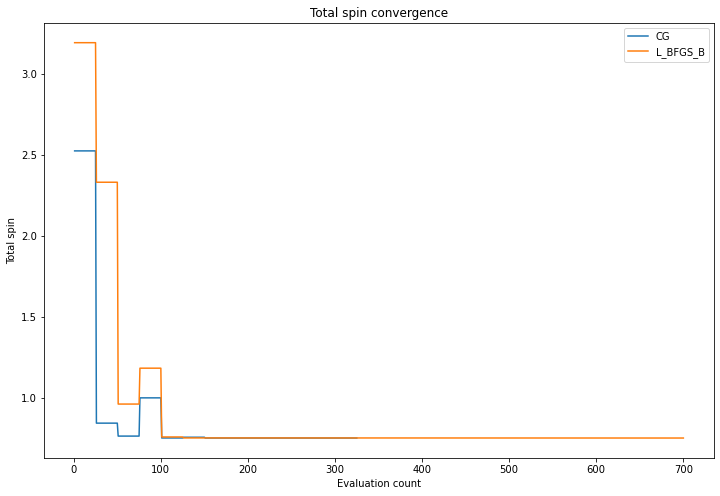

In [23]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [25]:
lab_list2=[(1,1.5,-0.5),(1,1.5,0.5)]
cost_conv3=[]
for l in lab_list2:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)       # To use with so4
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv3.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-03 11:07:37,189:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

### Cost function value and best states in the case of SO4 with depth $2$ and initial state $|\psi_1 \rangle = | 0 \rangle^{\otimes 5}$

In [26]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
   
    best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  (6.791171055734115e-13-3.674230668579951e-24j)
| (1, 1.5, -0.5) >= (0.012+0.464j) |000⟩ + (0.004+0.165j) |100⟩ + (0.004+0.165j) |010⟩ + (-0.007-0.251j) |110⟩ + (0.004+0.165j) |001⟩ + (-0.007-0.251j) |101⟩ + (-0.007-0.252j) |011⟩ + (-0.019-0.716j) |111⟩
<optimal|optimal> =  0.000672151412489046
< ideal | optimal > =  -0.011285080366110822 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  7.156508990622558e-13
| (1, 1.5, 0.5) >= (0.462-0.058j) |000⟩ + (0.465-0.058j) |100⟩ + (0.465-0.058j) |010⟩ + (-0.107+0.013j) |110⟩ + (0.465-0.058j) |001⟩ + (-0.107+0.013j) |101⟩ + (-0.106+0.013j) |011⟩ + (-0.299+0.037j) |111⟩
<optimal|optimal> =  0.9846406980784929
< ideal | optimal > =  0.8049083260311705 



We are going to consider the previous states using as coefficients the square of the absolute value of the previous complex coefficients.

In [27]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
    best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4 
    best_psi=CircuitStateFn(best_circ).to_matrix()
    
    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))
    
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi_rot))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi_rot))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  (6.791171055734115e-13-3.674230668579951e-24j)
| (1, 1.5, -0.5) >= (0.464) |000⟩ + (0.165) |100⟩ + (0.165) |010⟩ + (-0.251) |110⟩ + (0.165) |001⟩ + (-0.251) |101⟩ + (-0.252) |011⟩ + (-0.716) |111⟩
<optimal|optimal> =  1.0000000000000004
< ideal | optimal > =  -0.4352823909445629 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  7.156508990622558e-13
| (1, 1.5, 0.5) >= (0.465) |000⟩ + (0.469) |100⟩ + (0.468) |010⟩ + (-0.108) |110⟩ + (0.468) |001⟩ + (-0.107) |101⟩ + (-0.107) |011⟩ + (-0.301) |111⟩
<optimal|optimal> =  1.0
< ideal | optimal > =  0.8111618715192821 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.435$ |  
|$(1,3/2,1/2)$ | $0.811$ | 


The results show the most accurate result in the case of $|s_L=1,s=3/2,s_z=1/2 \rangle$, but no improvement for the value of $|s_L=1,s=3/2,s_z=-1/2 \rangle$.

So, until now the best way to find the state $|s_L=1,s=3/2,s_z=1/2 \rangle$ and the $|s_L=1,s=3/2,s_z=-1/2 \rangle$ are the **SO4** variational form (with depth fixed to $2$ and initial state $|0\rangle^{\otimes 3}$) and the **RY** variational form (with depth equal to $3$ and initial state with a singlet state on the first two qubits), respectively.

### Depth $2$ and initial state $\frac{|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}}|\uparrow_2\rangle$

In [78]:
var_form  = so4(num_qubits=3,reps=2,connections=[(0,1),(1,2)],initial_state=psi_custom) # Ansatz SO(4)
print("Number of parameters in so4: ", var_form.num_parameters)

Number of parameters in so4:  24


In [79]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-03 14:41:24,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fb78f2cc8b0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fb7929f0520>>
-- initial_point: Random seed
-- var_form: <__main__.so4 object at 0x7fb7932224c0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]', 'θ[17]', 'θ[18]', 'θ[19]', '

Optimizer: CG        

2021-03-03 14:41:24,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.02891 (ms)
2021-03-03 14:41:24,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8417145] - 52.74105 (ms), eval count: 1
2021-03-03 14:41:24,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28898 (ms)
2021-03-03 14:41:24,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.8417145] - 32.87292 (ms), eval count: 2
2021-03-03 14:41:24,341:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.71895 (ms)
2021-03-03 14:41:24,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.84171449] - 22.89104 (ms), eval count: 3
2021-03-03 14:41:24,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.11601 (ms)
2021-03-03 14:41:24,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation

2021-03-03 14:41:24,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33432308] - 9.41181 (ms), eval count: 32
2021-03-03 14:41:24,767:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09522 (ms)
2021-03-03 14:41:24,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33432307] - 8.49104 (ms), eval count: 33
2021-03-03 14:41:24,778:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03626 (ms)
2021-03-03 14:41:24,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33432308] - 6.46210 (ms), eval count: 34
2021-03-03 14:41:24,786:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60513 (ms)
2021-03-03 14:41:24,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33432308] - 8.90493 (ms), eval count: 35
2021-03-03 14:41:24,795:qiskit.aqua.operators.converters.c

2021-03-03 14:41:25,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84688 (ms)
2021-03-03 14:41:25,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93349984] - 14.02211 (ms), eval count: 64
2021-03-03 14:41:25,192:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72100 (ms)
2021-03-03 14:41:25,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93349984] - 13.18908 (ms), eval count: 65
2021-03-03 14:41:25,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.43294 (ms)
2021-03-03 14:41:25,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.93349984] - 18.69297 (ms), eval count: 66
2021-03-03 14:41:25,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27308 (ms)
2021-03-03 14:41:25,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 14:41:25,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62594 (ms)
2021-03-03 14:41:25,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.43400131] - 11.13081 (ms), eval count: 95
2021-03-03 14:41:25,776:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.15890 (ms)
2021-03-03 14:41:25,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.43400129] - 17.17877 (ms), eval count: 96
2021-03-03 14:41:25,793:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92485 (ms)
2021-03-03 14:41:25,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.43400129] - 10.45513 (ms), eval count: 97
2021-03-03 14:41:25,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93207 (ms)
2021-03-03 14:41:25,810:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 14:41:26,167:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96116 (ms)
2021-03-03 14:41:26,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33901954] - 7.47585 (ms), eval count: 126
2021-03-03 14:41:26,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72799 (ms)
2021-03-03 14:41:26,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33901954] - 23.93818 (ms), eval count: 127
2021-03-03 14:41:26,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31194 (ms)
2021-03-03 14:41:26,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33901953] - 8.71086 (ms), eval count: 128
2021-03-03 14:41:26,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19107 (ms)
2021-03-03 14:41:26,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 14:41:26,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.38309 (ms)
2021-03-03 14:41:26,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76283112] - 11.61695 (ms), eval count: 157
2021-03-03 14:41:26,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54695 (ms)
2021-03-03 14:41:26,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76283112] - 11.08885 (ms), eval count: 158
2021-03-03 14:41:26,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.72324 (ms)
2021-03-03 14:41:26,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76283112] - 14.55688 (ms), eval count: 159
2021-03-03 14:41:26,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85697 (ms)
2021-03-03 14:41:26,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-03 14:41:27,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50611 (ms)
2021-03-03 14:41:27,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75187743] - 12.69984 (ms), eval count: 188
2021-03-03 14:41:27,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90775 (ms)
2021-03-03 14:41:27,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75187743] - 15.98835 (ms), eval count: 189
2021-03-03 14:41:27,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03476 (ms)
2021-03-03 14:41:27,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75187742] - 23.59986 (ms), eval count: 190
2021-03-03 14:41:27,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05288 (ms)
2021-03-03 14:41:27,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-03 14:41:27,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78306 (ms)
2021-03-03 14:41:27,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81705743] - 12.02989 (ms), eval count: 219
2021-03-03 14:41:27,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.21517 (ms)
2021-03-03 14:41:27,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81705743] - 13.61179 (ms), eval count: 220
2021-03-03 14:41:27,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61879 (ms)
2021-03-03 14:41:27,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81705743] - 9.17697 (ms), eval count: 221
2021-03-03 14:41:27,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48790 (ms)
2021-03-03 14:41:27,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-03 14:41:28,196:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.16629 (ms)
2021-03-03 14:41:28,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75127449] - 17.35497 (ms), eval count: 250
2021-03-03 14:41:28,219:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.59594 (ms)
2021-03-03 14:41:28,228:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75051908] - 17.65203 (ms), eval count: 251
2021-03-03 14:41:28,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.60386 (ms)
2021-03-03 14:41:28,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75051908] - 13.64279 (ms), eval count: 252
2021-03-03 14:41:28,260:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.41990 (ms)
2021-03-03 14:41:28,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-03 14:41:28,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68698 (ms)
2021-03-03 14:41:28,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7507018] - 8.96311 (ms), eval count: 281
2021-03-03 14:41:28,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89194 (ms)
2021-03-03 14:41:28,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7507018] - 10.16808 (ms), eval count: 282
2021-03-03 14:41:28,762:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.58204 (ms)
2021-03-03 14:41:28,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7507018] - 17.56907 (ms), eval count: 283
2021-03-03 14:41:28,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.78625 (ms)
2021-03-03 14:41:28,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-03-03 14:41:29,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42877 (ms)
2021-03-03 14:41:29,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017821] - 9.54771 (ms), eval count: 312
2021-03-03 14:41:29,208:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14100 (ms)
2021-03-03 14:41:29,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017821] - 8.57019 (ms), eval count: 313
2021-03-03 14:41:29,223:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11191 (ms)
2021-03-03 14:41:29,230:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75017821] - 8.59809 (ms), eval count: 314
2021-03-03 14:41:29,235:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55275 (ms)
2021-03-03 14:41:29,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 14:41:29,703:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78521 (ms)
2021-03-03 14:41:29,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75042024] - 8.32200 (ms), eval count: 343
2021-03-03 14:41:29,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13504 (ms)
2021-03-03 14:41:29,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75042024] - 9.98592 (ms), eval count: 344
2021-03-03 14:41:29,727:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14085 (ms)
2021-03-03 14:41:29,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75042024] - 8.92282 (ms), eval count: 345
2021-03-03 14:41:29,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33412 (ms)
2021-03-03 14:41:29,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-03 14:41:30,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.11192 (ms)
2021-03-03 14:41:30,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005061] - 40.04025 (ms), eval count: 374
2021-03-03 14:41:30,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.07808 (ms)
2021-03-03 14:41:30,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005061] - 29.29115 (ms), eval count: 375
2021-03-03 14:41:30,199:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56493 (ms)
2021-03-03 14:41:30,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75012195] - 22.12715 (ms), eval count: 376
2021-03-03 14:41:30,226:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.84206 (ms)
2021-03-03 14:41:30,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-03-03 14:41:30,635:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28381 (ms)
2021-03-03 14:41:30,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 7.21169 (ms), eval count: 405
2021-03-03 14:41:30,646:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.86889 (ms)
2021-03-03 14:41:30,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 6.55794 (ms), eval count: 406
2021-03-03 14:41:30,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13575 (ms)
2021-03-03 14:41:30,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000005] - 16.13903 (ms), eval count: 407
2021-03-03 14:41:30,678:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58105 (ms)
2021-03-03 14:41:30,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-03 14:41:31,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.74789 (ms)
2021-03-03 14:41:31,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000107] - 16.23988 (ms), eval count: 436
2021-03-03 14:41:31,147:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.80597 (ms)
2021-03-03 14:41:31,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000107] - 14.80198 (ms), eval count: 437
2021-03-03 14:41:31,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.13921 (ms)
2021-03-03 14:41:31,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000107] - 21.47007 (ms), eval count: 438
2021-03-03 14:41:31,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.99618 (ms)
2021-03-03 14:41:31,216:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-03 14:41:31,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 12.49504 (ms), eval count: 467
2021-03-03 14:41:31,570:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07202 (ms)
2021-03-03 14:41:31,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.50003 (ms), eval count: 468
2021-03-03 14:41:31,580:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49290 (ms)
2021-03-03 14:41:31,585:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.25889 (ms), eval count: 469
2021-03-03 14:41:31,591:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02308 (ms)
2021-03-03 14:41:31,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.98004 (ms), eval count: 470
2021-03-03 14:41:31,616:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2021-03-03 14:41:32,069:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50602 (ms)
2021-03-03 14:41:32,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 7.43794 (ms), eval count: 499
2021-03-03 14:41:32,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94518 (ms)
2021-03-03 14:41:32,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 8.42595 (ms), eval count: 500
2021-03-03 14:41:32,088:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80309 (ms)
2021-03-03 14:41:32,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.78620 (ms), eval count: 501
2021-03-03 14:41:32,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92015 (ms)
2021-03-03 14:41:32,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation 

2021-03-03 14:41:32,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.46109 (ms)
2021-03-03 14:41:32,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 18.75520 (ms), eval count: 531
2021-03-03 14:41:32,558:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.51402 (ms)
2021-03-03 14:41:32,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 45.87007 (ms), eval count: 532
2021-03-03 14:41:32,606:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.29609 (ms)
2021-03-03 14:41:32,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 26.96705 (ms), eval count: 533
2021-03-03 14:41:32,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.32204 (ms)
2021-03-03 14:41:32,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation return

2021-03-03 14:41:33,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15006 (ms)
2021-03-03 14:41:33,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.56695 (ms), eval count: 563
2021-03-03 14:41:33,215:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95870 (ms)
2021-03-03 14:41:33,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.64699 (ms), eval count: 564
2021-03-03 14:41:33,226:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68316 (ms)
2021-03-03 14:41:33,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 19.86814 (ms), eval count: 565
2021-03-03 14:41:33,265:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.98215 (ms)
2021-03-03 14:41:33,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned

2021-03-03 14:41:33,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18320 (ms)
2021-03-03 14:41:33,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.40275 (ms), eval count: 595
2021-03-03 14:41:33,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58980 (ms)
2021-03-03 14:41:33,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 16.63613 (ms), eval count: 596
2021-03-03 14:41:33,691:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46906 (ms)
2021-03-03 14:41:33,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.26297 (ms), eval count: 597
2021-03-03 14:41:33,704:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22421 (ms)
2021-03-03 14:41:33,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-03-03 14:41:34,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15507 (ms)
2021-03-03 14:41:34,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.21893 (ms), eval count: 627
2021-03-03 14:41:34,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.53091 (ms)
2021-03-03 14:41:34,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 14.15586 (ms), eval count: 628
2021-03-03 14:41:34,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05312 (ms)
2021-03-03 14:41:34,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.70619 (ms), eval count: 629
2021-03-03 14:41:34,196:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88415 (ms)
2021-03-03 14:41:34,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-03-03 14:41:34,530:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47622 (ms)
2021-03-03 14:41:34,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.36094 (ms), eval count: 659
2021-03-03 14:41:34,543:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39515 (ms)
2021-03-03 14:41:34,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.58014 (ms), eval count: 660
2021-03-03 14:41:34,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.63882 (ms)
2021-03-03 14:41:34,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.37302 (ms), eval count: 661
2021-03-03 14:41:34,564:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66600 (ms)
2021-03-03 14:41:34,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-03 14:41:35,101:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-03 14:41:35,103:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 43 operations with depth 27
op_counts: OrderedDict([('cx', 9), ('s', 8), ('h', 8), ('u3', 8), ('sdg', 8), ('u', 2)])

2021-03-03 14:41:35,108:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-03-03 14:41:35,113:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 43 operations with depth 27
op_counts: OrderedDict([('cx', 9), ('s', 8), ('h', 8), ('u3', 8), ('sdg', 8), ('u', 2)])

2021-03-03 14:41:35,137:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 17.75193 (ms)
2021-03-03 14:41:35,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.86932949] - 65.05799 (ms), eval count: 1
2021-03-03 14:41:35,163:qiskit.aqua.operators.converters.circuit_sa

optimal_parameters {Parameter(θ[0]): -2.323230865474845, Parameter(θ[1]): -2.850682017908145, Parameter(θ[2]): -1.7572066938820852, Parameter(θ[3]): -2.441737124736846, Parameter(θ[4]): 1.7767942716017329, Parameter(θ[5]): -2.8645115810297956, Parameter(θ[6]): 0.9210052094662362, Parameter(θ[7]): 1.7592525781457302, Parameter(θ[8]): 1.1353454286249982, Parameter(θ[9]): -1.8044249616134642, Parameter(θ[10]): -0.4937504459523315, Parameter(θ[11]): 1.804039464775535, Parameter(θ[12]): -0.1807683948963652, Parameter(θ[13]): -2.5350942678594044, Parameter(θ[14]): -1.1947389603310843, Parameter(θ[15]): -0.33064711888124276, Parameter(θ[16]): -1.2279890091120476, Parameter(θ[17]): 2.783398328832701, Parameter(θ[18]): 0.8283391298515211, Parameter(θ[19]): 0.5287167295104711, Parameter(θ[20]): 2.852366037194186, Parameter(θ[21]): 1.6157645911517047, Parameter(θ[22]): -0.5428118486221433, Parameter(θ[23]): 0.6331582319472492}
optimal_point [-2.32323087 -2.85068202 -1.75720669 -2.44173712  1.7767

2021-03-03 14:41:35,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.86932949] - 11.24787 (ms), eval count: 7
2021-03-03 14:41:35,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46780 (ms)
2021-03-03 14:41:35,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.86932949] - 13.73219 (ms), eval count: 8
2021-03-03 14:41:35,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05312 (ms)
2021-03-03 14:41:35,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.86932949] - 11.11817 (ms), eval count: 9
2021-03-03 14:41:35,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65512 (ms)
2021-03-03 14:41:35,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.86932949] - 12.29191 (ms), eval count: 10
2021-03-03 14:41:35,302:qiskit.aqua.operators.converters.

2021-03-03 14:41:35,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61993 (ms)
2021-03-03 14:41:35,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.3980245] - 38.33771 (ms), eval count: 39
2021-03-03 14:41:35,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57492 (ms)
2021-03-03 14:41:35,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.3980245] - 9.80592 (ms), eval count: 40
2021-03-03 14:41:35,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36702 (ms)
2021-03-03 14:41:35,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.3980245] - 7.54094 (ms), eval count: 41
2021-03-03 14:41:35,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69198 (ms)
2021-03-03 14:41:35,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation

2021-03-03 14:41:36,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78579375] - 9.57918 (ms), eval count: 70
2021-03-03 14:41:36,145:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.64522 (ms)
2021-03-03 14:41:36,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78579375] - 17.01808 (ms), eval count: 71
2021-03-03 14:41:36,158:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14808 (ms)
2021-03-03 14:41:36,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78579375] - 8.93617 (ms), eval count: 72
2021-03-03 14:41:36,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.30195 (ms)
2021-03-03 14:41:36,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78579375] - 11.99937 (ms), eval count: 73
2021-03-03 14:41:36,183:qiskit.aqua.operators.converters

2021-03-03 14:41:36,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75049866] - 11.64603 (ms), eval count: 101
2021-03-03 14:41:36,634:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.17702 (ms)
2021-03-03 14:41:36,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75049866] - 15.91396 (ms), eval count: 102
2021-03-03 14:41:36,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89194 (ms)
2021-03-03 14:41:36,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75049866] - 22.62902 (ms), eval count: 103
2021-03-03 14:41:36,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93303 (ms)
2021-03-03 14:41:36,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75049866] - 11.06787 (ms), eval count: 104
2021-03-03 14:41:36,694:qiskit.aqua.operators.conv

2021-03-03 14:41:37,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500818] - 14.39810 (ms), eval count: 132
2021-03-03 14:41:37,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28500 (ms)
2021-03-03 14:41:37,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500818] - 7.49898 (ms), eval count: 133
2021-03-03 14:41:37,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54011 (ms)
2021-03-03 14:41:37,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500818] - 11.78908 (ms), eval count: 134
2021-03-03 14:41:37,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52604 (ms)
2021-03-03 14:41:37,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500818] - 9.90009 (ms), eval count: 135
2021-03-03 14:41:37,138:qiskit.aqua.operators.converters

2021-03-03 14:41:37,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000079] - 7.25317 (ms), eval count: 163
2021-03-03 14:41:37,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12901 (ms)
2021-03-03 14:41:37,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000079] - 11.96909 (ms), eval count: 164
2021-03-03 14:41:37,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.95100 (ms)
2021-03-03 14:41:37,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000079] - 13.33189 (ms), eval count: 165
2021-03-03 14:41:37,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.22082 (ms)
2021-03-03 14:41:37,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000079] - 13.97824 (ms), eval count: 166
2021-03-03 14:41:37,597:qiskit.aqua.operators.conve

2021-03-03 14:41:38,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.03098 (ms), eval count: 194
2021-03-03 14:41:38,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09427 (ms)
2021-03-03 14:41:38,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.33003 (ms), eval count: 195
2021-03-03 14:41:38,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57509 (ms)
2021-03-03 14:41:38,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.12676 (ms), eval count: 196
2021-03-03 14:41:38,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60711 (ms)
2021-03-03 14:41:38,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.43167 (ms), eval count: 197
2021-03-03 14:41:38,103:qiskit.aqua.operators.conver

2021-03-03 14:41:38,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.93109 (ms), eval count: 225
2021-03-03 14:41:38,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21691 (ms)
2021-03-03 14:41:38,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 11.99293 (ms), eval count: 226
2021-03-03 14:41:38,492:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39491 (ms)
2021-03-03 14:41:38,501:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 11.43789 (ms), eval count: 227
2021-03-03 14:41:38,510:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55990 (ms)
2021-03-03 14:41:38,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 10.72097 (ms), eval count: 228
2021-03-03 14:41:38,522:qiskit.aqua.operators.conve

2021-03-03 14:41:38,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.70585 (ms), eval count: 256
2021-03-03 14:41:38,907:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10404 (ms)
2021-03-03 14:41:38,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.86686 (ms), eval count: 257
2021-03-03 14:41:38,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.92167 (ms)
2021-03-03 14:41:38,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.94770 (ms), eval count: 258
2021-03-03 14:41:38,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.80103 (ms)
2021-03-03 14:41:38,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 19.00697 (ms), eval count: 259
2021-03-03 14:41:38,953:qiskit.aqua.operators.conver

2021-03-03 14:41:39,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 21.54708 (ms), eval count: 287
2021-03-03 14:41:39,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26998 (ms)
2021-03-03 14:41:39,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.97608 (ms), eval count: 288
2021-03-03 14:41:39,370:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23899 (ms)
2021-03-03 14:41:39,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.46900 (ms), eval count: 289
2021-03-03 14:41:39,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22588 (ms)
2021-03-03 14:41:39,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.66406 (ms), eval count: 290
2021-03-03 14:41:39,399:qiskit.aqua.operators.conve

2021-03-03 14:41:39,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 14.66084 (ms), eval count: 318
2021-03-03 14:41:39,796:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55895 (ms)
2021-03-03 14:41:39,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.04608 (ms), eval count: 319
2021-03-03 14:41:39,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30901 (ms)
2021-03-03 14:41:39,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.09901 (ms), eval count: 320
2021-03-03 14:41:39,818:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10905 (ms)
2021-03-03 14:41:39,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.59721 (ms), eval count: 321
2021-03-03 14:41:39,828:qiskit.aqua.operators.convert

2021-03-03 14:41:40,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.88014 (ms), eval count: 349
2021-03-03 14:41:40,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43115 (ms)
2021-03-03 14:41:40,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.33018 (ms), eval count: 350
2021-03-03 14:41:40,175:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48003 (ms)
2021-03-03 14:41:40,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.92909 (ms), eval count: 351
2021-03-03 14:41:40,188:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55713 (ms)
2021-03-03 14:41:40,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.69717 (ms), eval count: 352
2021-03-03 14:41:40,206:qiskit.aqua.operators.convert

2021-03-03 14:41:40,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.66795 (ms), eval count: 380
2021-03-03 14:41:40,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12502 (ms)
2021-03-03 14:41:40,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.99902 (ms), eval count: 381
2021-03-03 14:41:40,569:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.98111 (ms)
2021-03-03 14:41:40,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.92498 (ms), eval count: 382
2021-03-03 14:41:40,585:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.01609 (ms)
2021-03-03 14:41:40,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.57220 (ms), eval count: 383
2021-03-03 14:41:40,594:qiskit.aqua.operators.conver

2021-03-03 14:41:40,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.36260 (ms), eval count: 411
2021-03-03 14:41:40,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16794 (ms)
2021-03-03 14:41:40,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.59802 (ms), eval count: 412
2021-03-03 14:41:40,958:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82488 (ms)
2021-03-03 14:41:40,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.23297 (ms), eval count: 413
2021-03-03 14:41:40,976:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.67698 (ms)
2021-03-03 14:41:40,983:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.76398 (ms), eval count: 414
2021-03-03 14:41:40,986:qiskit.aqua.operators.conver

2021-03-03 14:41:41,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.15725 (ms), eval count: 442
2021-03-03 14:41:41,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03674 (ms)
2021-03-03 14:41:41,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.45702 (ms), eval count: 443
2021-03-03 14:41:41,332:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26896 (ms)
2021-03-03 14:41:41,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.68392 (ms), eval count: 444
2021-03-03 14:41:41,342:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26998 (ms)
2021-03-03 14:41:41,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.86085 (ms), eval count: 445
2021-03-03 14:41:41,356:qiskit.aqua.operators.convert

2021-03-03 14:41:41,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 18.03493 (ms), eval count: 473
2021-03-03 14:41:41,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37784 (ms)
2021-03-03 14:41:41,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.64262 (ms), eval count: 474
2021-03-03 14:41:41,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10969 (ms)
2021-03-03 14:41:41,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.61478 (ms), eval count: 475
2021-03-03 14:41:41,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.45714 (ms)
2021-03-03 14:41:41,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.54700 (ms), eval count: 476
2021-03-03 14:41:41,756:qiskit.aqua.operators.conver

2021-03-03 14:41:42,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.51195 (ms), eval count: 504
2021-03-03 14:41:42,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24781 (ms)
2021-03-03 14:41:42,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.48112 (ms), eval count: 505
2021-03-03 14:41:42,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46391 (ms)
2021-03-03 14:41:42,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.05483 (ms), eval count: 506
2021-03-03 14:41:42,200:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09293 (ms)
2021-03-03 14:41:42,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 17.35091 (ms), eval count: 507
2021-03-03 14:41:42,224:qiskit.aqua.operators.conve

2021-03-03 14:41:42,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.05714 (ms), eval count: 535
2021-03-03 14:41:42,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77901 (ms)
2021-03-03 14:41:42,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.28395 (ms), eval count: 536
2021-03-03 14:41:42,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91181 (ms)
2021-03-03 14:41:42,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.62193 (ms), eval count: 537
2021-03-03 14:41:42,644:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84212 (ms)
2021-03-03 14:41:42,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.95216 (ms), eval count: 538
2021-03-03 14:41:42,655:qiskit.aqua.operators.conve

2021-03-03 14:41:43,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.59286 (ms), eval count: 566
2021-03-03 14:41:43,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45016 (ms)
2021-03-03 14:41:43,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.00690 (ms), eval count: 567
2021-03-03 14:41:43,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12097 (ms)
2021-03-03 14:41:43,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.13301 (ms), eval count: 568
2021-03-03 14:41:43,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56603 (ms)
2021-03-03 14:41:43,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.53994 (ms), eval count: 569
2021-03-03 14:41:43,188:qiskit.aqua.operators.conve

2021-03-03 14:41:43,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.55694 (ms), eval count: 597
2021-03-03 14:41:43,645:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.43618 (ms)
2021-03-03 14:41:43,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 13.83591 (ms), eval count: 598
2021-03-03 14:41:43,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16794 (ms)
2021-03-03 14:41:43,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.72095 (ms), eval count: 599
2021-03-03 14:41:43,669:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39182 (ms)
2021-03-03 14:41:43,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.58290 (ms), eval count: 600
2021-03-03 14:41:43,681:qiskit.aqua.operators.conver

optimal_parameters {Parameter(θ[0]): -2.2610260195098584, Parameter(θ[1]): 0.3380307262651917, Parameter(θ[2]): 2.1682787711360083, Parameter(θ[3]): -0.7117045119989618, Parameter(θ[4]): 0.30498972431705607, Parameter(θ[5]): -2.9076489044271163, Parameter(θ[6]): 1.3217625061406109, Parameter(θ[7]): 1.503496161021413, Parameter(θ[8]): 2.4932562401409415, Parameter(θ[9]): -0.04244246638023703, Parameter(θ[10]): -1.3643604425837303, Parameter(θ[11]): 2.040280940675845, Parameter(θ[12]): 1.9972957663744408, Parameter(θ[13]): 0.9297591638791689, Parameter(θ[14]): 1.4707415981655982, Parameter(θ[15]): 2.1413032586646703, Parameter(θ[16]): -2.773905726013346, Parameter(θ[17]): -0.7998733705739325, Parameter(θ[18]): 2.9353805903519246, Parameter(θ[19]): -0.8623867552421602, Parameter(θ[20]): 1.3806722872002142, Parameter(θ[21]): -2.638465961898654, Parameter(θ[22]): 1.0981245732942528, Parameter(θ[23]): -0.5138342395620656}
optimal_point [-2.26102602  0.33803073  2.16827877 -0.71170451  0.3049

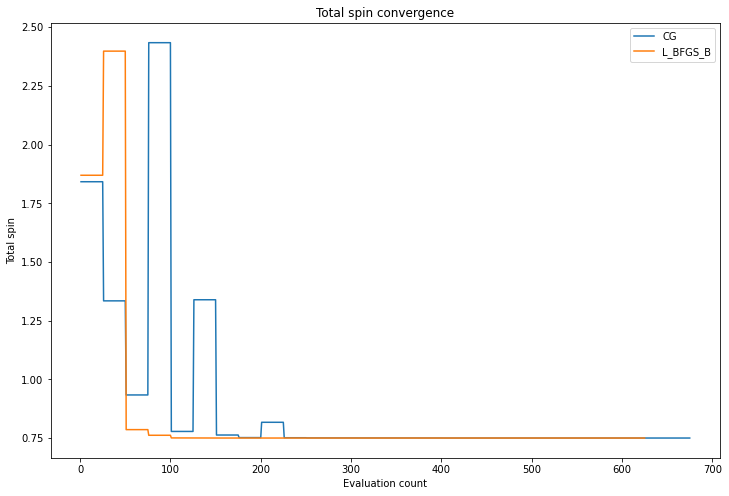

In [80]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [81]:
lab_list2=[(1,1.5,-0.5),(1,1.5,0.5)]
cost_conv3=[]
for l in lab_list2:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv3.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-03 14:41:44,466:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

### Cost function value and best states in the case of *SO4* with depth $2$ and initial state $\frac{|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}}|\uparrow_2\rangle$

In [82]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
   
    best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  1.7519626799404956e-13
| (1, 1.5, -0.5) >= (-0.277+0.345j) |000⟩ + (0.018-0.022j) |100⟩ + (0.018-0.022j) |010⟩ + (0.231-0.287j) |110⟩ + (0.018-0.022j) |001⟩ + (0.231-0.288j) |101⟩ + (0.231-0.287j) |011⟩ + (-0.393+0.490j) |111⟩
<optimal|optimal> =  0.3916140464634701
< ideal | optimal > =  0.39954391981258514 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  2.8284425863603496e-13
| (1, 1.5, 0.5) >= (-0.476-0.497j) |000⟩ + (0.120+0.125j) |100⟩ + (0.120+0.125j) |010⟩ + (-0.252-0.263j) |110⟩ + (0.120+0.125j) |001⟩ + (-0.252-0.262j) |101⟩ + (-0.252-0.263j) |011⟩ + (0.136+0.142j) |111⟩
<optimal|optimal> =  0.47880842547365815
< ideal | optimal > =  0.20808406481236802 



We are going to consider the previous states using as coefficients the square of the absolute value of the previous complex coefficients.

In [83]:
for i,el in enumerate(cost_conv3):
    print("State label: ",lab_list2[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    #best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
    best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4 
    best_psi=CircuitStateFn(best_circ).to_matrix()
    
    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))
    
    # The best state
    print("|",lab_list2[i],">=",to_ket(best_psi_rot))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi_rot))),"\n")

State label:  (1, 1.5, -0.5)  , C(s_L,s,s_z) =  1.7519626799404956e-13
| (1, 1.5, -0.5) >= (-0.443) |000⟩ + (0.028) |100⟩ + (0.028) |010⟩ + (0.368) |110⟩ + (0.029) |001⟩ + (0.369) |101⟩ + (0.369) |011⟩ + (-0.628) |111⟩
<optimal|optimal> =  1.0000000000000002
< ideal | optimal > =  0.6384625022643526 

State label:  (1, 1.5, 0.5)  , C(s_L,s,s_z) =  2.8284425863603496e-13
| (1, 1.5, 0.5) >= (-0.689) |000⟩ + (0.173) |100⟩ + (0.174) |010⟩ + (-0.364) |110⟩ + (0.174) |001⟩ + (-0.364) |101⟩ + (-0.364) |011⟩ + (0.196) |111⟩
<optimal|optimal> =  1.0000000000000002
< ideal | optimal > =  0.30071696597382114 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.638$ |  
|$(1,3/2,1/2)$ | $0.301$ | 


The first of the two states is more accurate than the optimal state of **SO4** variational form initialized with $|0\rangle^{\otimes 3}$, but the other is not.

# RotGate Variational Quantum Eigensolver

We use the custom gate of the bow-tie lattice. This time we don't fix the angle of rotation to $120°$ because we are not looking at the frustrated configuration. 

The main idea is to rotate each qubit on a different axis (indicated using spherical angles of the unitary vector) of rotation with a different angle.

In [22]:
qr = QuantumRegister(3,'q')                 #1 qubit register
qc = QuantumCircuit(qr)

th1=Parameter("th1")
th2=Parameter("th2")
th3=Parameter("th3")
ph1=Parameter("ph1")
ph2=Parameter("ph2")
ph3=Parameter("ph3")
ang1=Parameter("ang1")
ang2=Parameter("ang2")
ang3=Parameter("ang3")

qc.rz(ph1,[0])
qc.rx(th1,[0])
qc.rz(ang1,[0])
qc.rx(-th1,[0])
qc.rz(-ph1,[0])

qc.rz(ph2,[1])
qc.rx(th2,[1])
qc.rz(ang2,[1])
qc.rx(-th2,[1])
qc.rz(-ph2,[1])

qc.rz(ph3,[2])
qc.rx(th3,[2])
qc.rz(ang3,[2])
qc.rx(-th3,[2])
qc.rz(-ph3,[2])
print(qc.draw())

     ┌─────────┐┌─────────┐┌──────────┐┌──────────────┐┌──────────────┐
q_0: ┤ RZ(ph1) ├┤ RX(th1) ├┤ RZ(ang1) ├┤ RX(-1.0*th1) ├┤ RZ(-1.0*ph1) ├
     ├─────────┤├─────────┤├──────────┤├──────────────┤├──────────────┤
q_1: ┤ RZ(ph2) ├┤ RX(th2) ├┤ RZ(ang2) ├┤ RX(-1.0*th2) ├┤ RZ(-1.0*ph2) ├
     ├─────────┤├─────────┤├──────────┤├──────────────┤├──────────────┤
q_2: ┤ RZ(ph3) ├┤ RX(th3) ├┤ RZ(ang3) ├┤ RX(-1.0*th3) ├┤ RZ(-1.0*ph3) ├
     └─────────┘└─────────┘└──────────┘└──────────────┘└──────────────┘


We start with the initial state $|\psi_1 \rangle = | 0 \rangle^{\otimes 5}$ and depth of the circuit equal to $1$.

In [23]:
var_form  = TwoLocal(3,qc,['cx'],[(0,1),(1,2)],initial_state=psi_1,reps=1)
print("The custom variational form")
print(var_form.draw())
print("Number of parameters: ",var_form.num_parameters)
#print("Ordered parameters: ",var_form.ordered_parameters)

The custom variational form
     ┌──────────┐┌──────────┐┌──────────┐┌───────────────┐┌───────────────┐»
q_0: ┤ RZ(θ[8]) ├┤ RX(θ[2]) ├┤ RZ(θ[6]) ├┤ RX(-1.0*θ[2]) ├┤ RZ(-1.0*θ[8]) ├»
     ├──────────┤├──────────┤├──────────┤├───────────────┤├───────────────┤»
q_1: ┤ RZ(θ[5]) ├┤ RX(θ[7]) ├┤ RZ(θ[1]) ├┤ RX(-1.0*θ[7]) ├┤ RZ(-1.0*θ[5]) ├»
     ├──────────┤├──────────┤├──────────┤├───────────────┤├───────────────┤»
q_2: ┤ RZ(θ[0]) ├┤ RX(θ[4]) ├┤ RZ(θ[3]) ├┤ RX(-1.0*θ[4]) ├┤ RZ(-1.0*θ[0]) ├»
     └──────────┘└──────────┘└──────────┘└───────────────┘└───────────────┘»
«          ┌───────────┐┌───────────┐┌───────────┐┌────────────────┐»
«q_0: ──■──┤ RZ(θ[17]) ├┤ RX(θ[11]) ├┤ RZ(θ[15]) ├┤ RX(-1.0*θ[11]) ├»
«     ┌─┴─┐└───────────┘├───────────┤├───────────┤└─┬───────────┬──┘»
«q_1: ┤ X ├──────■──────┤ RZ(θ[14]) ├┤ RX(θ[16]) ├──┤ RZ(θ[10]) ├───»
«     └───┘    ┌─┴─┐    └┬──────────┤├───────────┤  ├───────────┤   »
«q_2: ─────────┤ X ├─────┤ RZ(θ[9]) ├┤ RX(θ[13]) ├──┤ RZ(θ[12]) ├───»
«            

In [24]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-04 09:46:33,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fe7b981d100>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fe7b9443250>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐┌──────────┐┌──────────┐┌───────────────┐┌───────────────┐»
q_0: ┤ RZ(θ[8]) ├┤ RX(θ[2]) ├┤ RZ(θ[6]) ├┤ RX(-1.0*θ[2]) ├┤ RZ(-1.0*θ[8]) ├»
     ├──────────┤├──────────┤├──────────┤├───────────────┤├───────────────┤»
q_1:

2021-03-04 09:46:33,472:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 0.69588587  5.63809804  3.62965926 -0.08746578  3.59736158 -0.65376679
 -6.25362955  3.35613336 -5.80595684  5.16481927  3.78867405 -5.30187612
  3.30431623 -3.87834062  5.70781756  0.28725822  2.58419341  3.62795747]
2021-03-04 09:46:33,489:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-04 09:46:33,490:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 32 operations with depth 12
op_counts: OrderedDict([('rz', 18), ('rx', 12), ('cx', 2)])

2021-03-04 09:46:33,491:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-03-04 09:46:33,493:qis

Optimizer: CG        

2021-03-04 09:46:33,666:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82788 (ms)
2021-03-04 09:46:33,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.68759405] - 8.91590 (ms), eval count: 17
2021-03-04 09:46:33,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13687 (ms)
2021-03-04 09:46:33,681:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.68759405] - 7.73883 (ms), eval count: 18
2021-03-04 09:46:33,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02577 (ms)
2021-03-04 09:46:33,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.68759405] - 7.61914 (ms), eval count: 19
2021-03-04 09:46:33,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.98209 (ms)
2021-03-04 09:46:33,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 09:46:34,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88503 (ms)
2021-03-04 09:46:34,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.80686334] - 9.25994 (ms), eval count: 48
2021-03-04 09:46:34,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06797 (ms)
2021-03-04 09:46:34,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.80686335] - 8.50391 (ms), eval count: 49
2021-03-04 09:46:34,113:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11828 (ms)
2021-03-04 09:46:34,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.80686334] - 9.36794 (ms), eval count: 50
2021-03-04 09:46:34,123:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77305 (ms)
2021-03-04 09:46:34,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 09:46:34,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50506 (ms)
2021-03-04 09:46:34,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.25720038] - 7.39503 (ms), eval count: 79
2021-03-04 09:46:34,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09610 (ms)
2021-03-04 09:46:34,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.25720039] - 9.13501 (ms), eval count: 80
2021-03-04 09:46:34,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51007 (ms)
2021-03-04 09:46:34,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.2572004] - 7.28917 (ms), eval count: 81
2021-03-04 09:46:34,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81811 (ms)
2021-03-04 09:46:34,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluatio

2021-03-04 09:46:34,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78497 (ms)
2021-03-04 09:46:34,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.88124491] - 7.80296 (ms), eval count: 110
2021-03-04 09:46:34,975:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31085 (ms)
2021-03-04 09:46:34,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.88124491] - 14.51087 (ms), eval count: 111
2021-03-04 09:46:34,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.20785 (ms)
2021-03-04 09:46:35,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.8812449] - 15.07711 (ms), eval count: 112
2021-03-04 09:46:35,013:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.69971 (ms)
2021-03-04 09:46:35,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:35,368:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55680 (ms)
2021-03-04 09:46:35,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.14856886] - 13.67688 (ms), eval count: 141
2021-03-04 09:46:35,385:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.43912 (ms)
2021-03-04 09:46:35,393:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.14856884] - 12.12478 (ms), eval count: 142
2021-03-04 09:46:35,399:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.78101 (ms)
2021-03-04 09:46:35,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.14856885] - 11.77382 (ms), eval count: 143
2021-03-04 09:46:35,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59082 (ms)
2021-03-04 09:46:35,420:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-04 09:46:35,776:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.70869 (ms)
2021-03-04 09:46:35,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.90158801] - 10.57410 (ms), eval count: 172
2021-03-04 09:46:35,787:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.86317 (ms)
2021-03-04 09:46:35,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.90158801] - 7.61008 (ms), eval count: 173
2021-03-04 09:46:35,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79975 (ms)
2021-03-04 09:46:35,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.90158801] - 8.75497 (ms), eval count: 174
2021-03-04 09:46:35,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20888 (ms)
2021-03-04 09:46:35,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:36,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81286 (ms)
2021-03-04 09:46:36,195:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.84987747] - 28.76806 (ms), eval count: 203
2021-03-04 09:46:36,205:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.48942 (ms)
2021-03-04 09:46:36,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.84987749] - 14.35900 (ms), eval count: 204
2021-03-04 09:46:36,219:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92587 (ms)
2021-03-04 09:46:36,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.84987747] - 9.31406 (ms), eval count: 205
2021-03-04 09:46:36,230:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92206 (ms)
2021-03-04 09:46:36,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:36,604:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70002 (ms)
2021-03-04 09:46:36,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.62396286] - 11.76214 (ms), eval count: 234
2021-03-04 09:46:36,618:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94518 (ms)
2021-03-04 09:46:36,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.62396285] - 6.41513 (ms), eval count: 235
2021-03-04 09:46:36,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73991 (ms)
2021-03-04 09:46:36,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.62396285] - 7.85685 (ms), eval count: 236
2021-03-04 09:46:36,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66998 (ms)
2021-03-04 09:46:36,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:37,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08006 (ms)
2021-03-04 09:46:37,006:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.57733045] - 9.93395 (ms), eval count: 265
2021-03-04 09:46:37,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80309 (ms)
2021-03-04 09:46:37,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.57733046] - 7.37405 (ms), eval count: 266
2021-03-04 09:46:37,024:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.83801 (ms)
2021-03-04 09:46:37,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.87806528] - 12.59804 (ms), eval count: 267
2021-03-04 09:46:37,034:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95918 (ms)
2021-03-04 09:46:37,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:37,410:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56991 (ms)
2021-03-04 09:46:37,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.53106685] - 8.71921 (ms), eval count: 296
2021-03-04 09:46:37,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.80186 (ms)
2021-03-04 09:46:37,444:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.53106685] - 20.67876 (ms), eval count: 297
2021-03-04 09:46:37,450:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39079 (ms)
2021-03-04 09:46:37,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.53106685] - 9.19414 (ms), eval count: 298
2021-03-04 09:46:37,460:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99597 (ms)
2021-03-04 09:46:37,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:37,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24607 (ms)
2021-03-04 09:46:37,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35877785] - 9.86910 (ms), eval count: 327
2021-03-04 09:46:37,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64287 (ms)
2021-03-04 09:46:37,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35877785] - 7.60293 (ms), eval count: 328
2021-03-04 09:46:37,873:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.18198 (ms)
2021-03-04 09:46:37,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35877785] - 19.63782 (ms), eval count: 329
2021-03-04 09:46:37,888:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31783 (ms)
2021-03-04 09:46:37,894:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:38,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.70390 (ms)
2021-03-04 09:46:38,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.19659208] - 22.14193 (ms), eval count: 358
2021-03-04 09:46:38,291:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.03700 (ms)
2021-03-04 09:46:38,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.19659208] - 14.35399 (ms), eval count: 359
2021-03-04 09:46:38,314:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56278 (ms)
2021-03-04 09:46:38,321:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.19659208] - 12.61020 (ms), eval count: 360
2021-03-04 09:46:38,327:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90379 (ms)
2021-03-04 09:46:38,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-03-04 09:46:38,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85792 (ms)
2021-03-04 09:46:38,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06227826] - 13.80396 (ms), eval count: 389
2021-03-04 09:46:38,827:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.26604 (ms)
2021-03-04 09:46:38,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06227826] - 11.30795 (ms), eval count: 390
2021-03-04 09:46:38,838:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.59599 (ms)
2021-03-04 09:46:38,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06227826] - 13.98396 (ms), eval count: 391
2021-03-04 09:46:38,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.97937 (ms)
2021-03-04 09:46:38,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-04 09:46:39,296:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69573 (ms)
2021-03-04 09:46:39,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.98511724] - 8.86106 (ms), eval count: 420
2021-03-04 09:46:39,306:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73490 (ms)
2021-03-04 09:46:39,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.98511723] - 8.37111 (ms), eval count: 421
2021-03-04 09:46:39,316:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48973 (ms)
2021-03-04 09:46:39,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.98511724] - 11.05285 (ms), eval count: 422
2021-03-04 09:46:39,329:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56317 (ms)
2021-03-04 09:46:39,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:39,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12209 (ms)
2021-03-04 09:46:39,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.8641605] - 9.31883 (ms), eval count: 451
2021-03-04 09:46:39,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82900 (ms)
2021-03-04 09:46:39,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.8641605] - 10.20384 (ms), eval count: 452
2021-03-04 09:46:39,720:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52008 (ms)
2021-03-04 09:46:39,726:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.86416051] - 8.34894 (ms), eval count: 453
2021-03-04 09:46:39,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83790 (ms)
2021-03-04 09:46:39,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-03-04 09:46:40,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58605 (ms)
2021-03-04 09:46:40,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78921067] - 8.02994 (ms), eval count: 482
2021-03-04 09:46:40,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.24895 (ms)
2021-03-04 09:46:40,123:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78921067] - 11.11770 (ms), eval count: 483
2021-03-04 09:46:40,128:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55411 (ms)
2021-03-04 09:46:40,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.78921067] - 12.90989 (ms), eval count: 484
2021-03-04 09:46:40,144:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65298 (ms)
2021-03-04 09:46:40,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:40,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54505 (ms)
2021-03-04 09:46:40,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75979058] - 11.10077 (ms), eval count: 513
2021-03-04 09:46:40,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.04486 (ms)
2021-03-04 09:46:40,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76028584] - 13.95893 (ms), eval count: 514
2021-03-04 09:46:40,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88892 (ms)
2021-03-04 09:46:40,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76028584] - 9.03988 (ms), eval count: 515
2021-03-04 09:46:40,521:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56109 (ms)
2021-03-04 09:46:40,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:40,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16613 (ms)
2021-03-04 09:46:40,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75277813] - 9.95708 (ms), eval count: 544
2021-03-04 09:46:40,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81191 (ms)
2021-03-04 09:46:40,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75277813] - 9.19890 (ms), eval count: 545
2021-03-04 09:46:40,901:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49784 (ms)
2021-03-04 09:46:40,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75277813] - 9.19175 (ms), eval count: 546
2021-03-04 09:46:40,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14617 (ms)
2021-03-04 09:46:40,916:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-04 09:46:41,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69508 (ms)
2021-03-04 09:46:41,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75092861] - 6.02698 (ms), eval count: 575
2021-03-04 09:46:41,302:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34311 (ms)
2021-03-04 09:46:41,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75092861] - 9.90582 (ms), eval count: 576
2021-03-04 09:46:41,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84314 (ms)
2021-03-04 09:46:41,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75092861] - 9.09615 (ms), eval count: 577
2021-03-04 09:46:41,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57897 (ms)
2021-03-04 09:46:41,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-04 09:46:41,687:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08204 (ms)
2021-03-04 09:46:41,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75070268] - 8.51297 (ms), eval count: 606
2021-03-04 09:46:41,697:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92468 (ms)
2021-03-04 09:46:41,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75070268] - 7.63488 (ms), eval count: 607
2021-03-04 09:46:41,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81501 (ms)
2021-03-04 09:46:41,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75070268] - 9.11307 (ms), eval count: 608
2021-03-04 09:46:41,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.42636 (ms)
2021-03-04 09:46:41,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-04 09:46:42,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56183 (ms)
2021-03-04 09:46:42,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75022654] - 13.68070 (ms), eval count: 637
2021-03-04 09:46:42,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57597 (ms)
2021-03-04 09:46:42,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75022654] - 10.89001 (ms), eval count: 638
2021-03-04 09:46:42,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94678 (ms)
2021-03-04 09:46:42,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75022654] - 9.78613 (ms), eval count: 639
2021-03-04 09:46:42,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11415 (ms)
2021-03-04 09:46:42,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:42,470:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77877 (ms)
2021-03-04 09:46:42,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7502521] - 8.96001 (ms), eval count: 668
2021-03-04 09:46:42,483:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.44000 (ms)
2021-03-04 09:46:42,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7502521] - 12.80618 (ms), eval count: 669
2021-03-04 09:46:42,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.18830 (ms)
2021-03-04 09:46:42,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7502521] - 15.49077 (ms), eval count: 670
2021-03-04 09:46:42,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07488 (ms)
2021-03-04 09:46:42,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-03-04 09:46:42,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.20317 (ms)
2021-03-04 09:46:42,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002646] - 13.61203 (ms), eval count: 699
2021-03-04 09:46:42,890:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56205 (ms)
2021-03-04 09:46:42,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002646] - 9.73320 (ms), eval count: 700
2021-03-04 09:46:42,901:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21794 (ms)
2021-03-04 09:46:42,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002646] - 8.76379 (ms), eval count: 701
2021-03-04 09:46:42,913:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09293 (ms)
2021-03-04 09:46:42,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:43,275:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38292 (ms)
2021-03-04 09:46:43,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000153] - 8.39710 (ms), eval count: 730
2021-03-04 09:46:43,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09181 (ms)
2021-03-04 09:46:43,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000153] - 9.13167 (ms), eval count: 731
2021-03-04 09:46:43,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.04393 (ms)
2021-03-04 09:46:43,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000153] - 14.47201 (ms), eval count: 732
2021-03-04 09:46:43,317:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11892 (ms)
2021-03-04 09:46:43,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:43,660:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.40583 (ms)
2021-03-04 09:46:43,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000081] - 13.66901 (ms), eval count: 761
2021-03-04 09:46:43,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92301 (ms)
2021-03-04 09:46:43,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000081] - 7.47919 (ms), eval count: 762
2021-03-04 09:46:43,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11708 (ms)
2021-03-04 09:46:43,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000081] - 8.87799 (ms), eval count: 763
2021-03-04 09:46:43,697:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12686 (ms)
2021-03-04 09:46:43,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:44,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.46782 (ms)
2021-03-04 09:46:44,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500004] - 16.71696 (ms), eval count: 792
2021-03-04 09:46:44,071:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56293 (ms)
2021-03-04 09:46:44,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500004] - 7.77388 (ms), eval count: 793
2021-03-04 09:46:44,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36687 (ms)
2021-03-04 09:46:44,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500004] - 9.44996 (ms), eval count: 794
2021-03-04 09:46:44,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28875 (ms)
2021-03-04 09:46:44,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-03-04 09:46:44,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45914 (ms)
2021-03-04 09:46:44,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000037] - 16.10684 (ms), eval count: 823
2021-03-04 09:46:44,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67110 (ms)
2021-03-04 09:46:44,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000037] - 11.28602 (ms), eval count: 824
2021-03-04 09:46:44,484:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41582 (ms)
2021-03-04 09:46:44,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000037] - 8.20875 (ms), eval count: 825
2021-03-04 09:46:44,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88391 (ms)
2021-03-04 09:46:44,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:44,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.54697 (ms)
2021-03-04 09:46:44,972:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000018] - 16.74390 (ms), eval count: 854
2021-03-04 09:46:44,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.66399 (ms)
2021-03-04 09:46:44,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000018] - 22.56584 (ms), eval count: 855
2021-03-04 09:46:45,025:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 17.81607 (ms)
2021-03-04 09:46:45,032:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000004] - 24.53303 (ms), eval count: 856
2021-03-04 09:46:45,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77409 (ms)
2021-03-04 09:46:45,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-03-04 09:46:45,478:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61111 (ms)
2021-03-04 09:46:45,491:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 19.78111 (ms), eval count: 885
2021-03-04 09:46:45,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.33295 (ms)
2021-03-04 09:46:45,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 12.54606 (ms), eval count: 886
2021-03-04 09:46:45,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81207 (ms)
2021-03-04 09:46:45,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 9.55296 (ms), eval count: 887
2021-03-04 09:46:45,521:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.98302 (ms)
2021-03-04 09:46:45,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-03-04 09:46:46,001:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.63886 (ms)
2021-03-04 09:46:46,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 18.04423 (ms), eval count: 916
2021-03-04 09:46:46,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.12600 (ms)
2021-03-04 09:46:46,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 14.44316 (ms), eval count: 917
2021-03-04 09:46:46,035:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.52511 (ms)
2021-03-04 09:46:46,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 21.70801 (ms), eval count: 918
2021-03-04 09:46:46,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90403 (ms)
2021-03-04 09:46:46,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-03-04 09:46:46,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99120 (ms)
2021-03-04 09:46:46,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.56321 (ms), eval count: 947
2021-03-04 09:46:46,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.13983 (ms)
2021-03-04 09:46:46,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 12.06207 (ms), eval count: 948
2021-03-04 09:46:46,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80809 (ms)
2021-03-04 09:46:46,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.30691 (ms), eval count: 949
2021-03-04 09:46:46,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.24194 (ms)
2021-03-04 09:46:46,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-03-04 09:46:47,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.98018 (ms), eval count: 978
2021-03-04 09:46:47,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03118 (ms)
2021-03-04 09:46:47,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.14486 (ms), eval count: 979
2021-03-04 09:46:47,075:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54607 (ms)
2021-03-04 09:46:47,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.83284 (ms), eval count: 980
2021-03-04 09:46:47,084:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89607 (ms)
2021-03-04 09:46:47,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.70712 (ms), eval count: 981
2021-03-04 09:46:47,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2021-03-04 09:46:47,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78878 (ms)
2021-03-04 09:46:47,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.67303 (ms), eval count: 1010
2021-03-04 09:46:47,474:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84314 (ms)
2021-03-04 09:46:47,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.06093 (ms), eval count: 1011
2021-03-04 09:46:47,485:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58923 (ms)
2021-03-04 09:46:47,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 12.81309 (ms), eval count: 1012
2021-03-04 09:46:47,510:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.76830 (ms)
2021-03-04 09:46:47,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned

2021-03-04 09:46:47,873:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.18513 (ms)
2021-03-04 09:46:47,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 14.21905 (ms), eval count: 1042
2021-03-04 09:46:47,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42822 (ms)
2021-03-04 09:46:47,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.54485 (ms), eval count: 1043
2021-03-04 09:46:47,904:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.27692 (ms)
2021-03-04 09:46:47,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.49678 (ms), eval count: 1044
2021-03-04 09:46:47,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82686 (ms)
2021-03-04 09:46:47,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returne

2021-03-04 09:46:48,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.77397 (ms), eval count: 1073
2021-03-04 09:46:48,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33786 (ms)
2021-03-04 09:46:48,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.41300 (ms), eval count: 1074
2021-03-04 09:46:48,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93708 (ms)
2021-03-04 09:46:48,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.46426 (ms), eval count: 1075
2021-03-04 09:46:48,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97403 (ms)
2021-03-04 09:46:48,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 15.27810 (ms), eval count: 1076
2021-03-04 09:46:48,394:qiskit.aqua.operators.converters.circuit_sampler:

2021-03-04 09:46:49,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04596 (ms)
2021-03-04 09:46:49,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 13.02314 (ms), eval count: 1105
2021-03-04 09:46:49,108:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18217 (ms)
2021-03-04 09:46:49,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.21512 (ms), eval count: 1106
2021-03-04 09:46:49,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29709 (ms)
2021-03-04 09:46:49,138:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 22.56417 (ms), eval count: 1107
2021-03-04 09:46:49,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05574 (ms)
2021-03-04 09:46:49,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returne

2021-03-04 09:46:49,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.61502 (ms), eval count: 1136
2021-03-04 09:46:49,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46010 (ms)
2021-03-04 09:46:49,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.13207 (ms), eval count: 1137
2021-03-04 09:46:49,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09372 (ms)
2021-03-04 09:46:49,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.32121 (ms), eval count: 1138
2021-03-04 09:46:49,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82368 (ms)
2021-03-04 09:46:49,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.34062 (ms), eval count: 1139
2021-03-04 09:46:49,734:qiskit.aqua.operators.converters.circuit_sampler

2021-03-04 09:46:50,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29590 (ms)
2021-03-04 09:46:50,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.37510 (ms), eval count: 1168
2021-03-04 09:46:50,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82805 (ms)
2021-03-04 09:46:50,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.19890 (ms), eval count: 1169
2021-03-04 09:46:50,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46630 (ms)
2021-03-04 09:46:50,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.82888 (ms), eval count: 1170
2021-03-04 09:46:50,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.33597 (ms)
2021-03-04 09:46:50,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2021-03-04 09:46:50,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.21614 (ms), eval count: 1199
2021-03-04 09:46:50,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90298 (ms)
2021-03-04 09:46:50,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 9.83214 (ms), eval count: 1200
2021-03-04 09:46:50,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29804 (ms)
2021-03-04 09:46:50,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.93211 (ms), eval count: 1201
2021-03-04 09:46:50,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70104 (ms)
2021-03-04 09:46:50,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.34973 (ms), eval count: 1202
2021-03-04 09:46:50,743:qiskit.aqua.operators.converters.circuit_sampler:D

2021-03-04 09:46:51,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.50127 (ms)
2021-03-04 09:46:51,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.70087 (ms), eval count: 1231
2021-03-04 09:46:51,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.35271 (ms)
2021-03-04 09:46:51,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 26.15809 (ms), eval count: 1232
2021-03-04 09:46:51,209:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83735 (ms)
2021-03-04 09:46:51,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 14.60409 (ms), eval count: 1233
2021-03-04 09:46:51,226:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40414 (ms)
2021-03-04 09:46:51,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation retur

2021-03-04 09:46:51,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.14517 (ms), eval count: 1262
2021-03-04 09:46:51,933:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.13196 (ms)
2021-03-04 09:46:51,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.38687 (ms), eval count: 1263
2021-03-04 09:46:51,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.02920 (ms)
2021-03-04 09:46:51,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.97894 (ms), eval count: 1264
2021-03-04 09:46:51,958:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50110 (ms)
2021-03-04 09:46:51,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.92591 (ms), eval count: 1265
2021-03-04 09:46:51,969:qiskit.aqua.operators.converters.circuit_sampler

2021-03-04 09:46:52,443:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71885 (ms)
2021-03-04 09:46:52,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.25596 (ms), eval count: 1294
2021-03-04 09:46:52,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82693 (ms)
2021-03-04 09:46:52,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 11.82818 (ms), eval count: 1295
2021-03-04 09:46:52,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.37109 (ms)
2021-03-04 09:46:52,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 12.85911 (ms), eval count: 1296
2021-03-04 09:46:52,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12328 (ms)
2021-03-04 09:46:52,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returne

2021-03-04 09:46:52,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 14.62078 (ms), eval count: 1325
2021-03-04 09:46:52,956:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16327 (ms)
2021-03-04 09:46:52,967:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 15.06519 (ms), eval count: 1326
2021-03-04 09:46:52,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95322 (ms)
2021-03-04 09:46:52,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 10.77294 (ms), eval count: 1327
2021-03-04 09:46:52,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89583 (ms)
2021-03-04 09:46:52,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.99601 (ms), eval count: 1328
2021-03-04 09:46:52,996:qiskit.aqua.operators.converters.circuit_sample

2021-03-04 09:46:53,428:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 5.95436632  2.91149094 -4.1841645  -2.25438562 -3.38733245 -6.27449789
  1.51136961  1.14344091 -1.46254196  1.48920947  4.23726315 -4.37739534
 -2.25614994  0.16773147 -4.85240506 -0.83826925 -5.83056269 -1.12961103]
2021-03-04 09:46:53,464:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-04 09:46:53,468:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 32 operations with depth 12
op_counts: OrderedDict([('rz', 18), ('rx', 12), ('cx', 2)])

2021-03-04 09:46:53,481:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-03-04 09:46:53,483:qis

optimal_parameters {Parameter(θ[0]): 1.1740577867370934, Parameter(θ[10]): 4.851016721604984, Parameter(θ[11]): 3.4711983306675886, Parameter(θ[12]): -2.8607941519308633, Parameter(θ[13]): 4.217962901051939, Parameter(θ[14]): -0.45761658492691537, Parameter(θ[15]): -7.776985873814723, Parameter(θ[16]): 6.662068310334048, Parameter(θ[17]): -6.167788995797303, Parameter(θ[1]): -1.6599032951608996, Parameter(θ[2]): 4.200520391226953, Parameter(θ[3]): -4.656999812050236, Parameter(θ[4]): 5.53149546643354, Parameter(θ[5]): -4.488620141850669, Parameter(θ[6]): 5.2977163584511135, Parameter(θ[7]): 8.143888049035636, Parameter(θ[8]): 3.0627497526398417, Parameter(θ[9]): 2.950376280679411}
optimal_point [ 1.17405779  4.85101672  3.47119833 -2.86079415  4.2179629  -0.45761658
 -7.77698587  6.66206831 -6.167789   -1.6599033   4.20052039 -4.65699981
  5.53149547 -4.48862014  5.29771636  8.14388805  3.06274975  2.95037628]
optimal_value 0.7500000000000215
optimizer_evals 1349
optimizer_time 19.8416

2021-03-04 09:46:53,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99590 (ms)
2021-03-04 09:46:53,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.67824568] - 11.53278 (ms), eval count: 4
2021-03-04 09:46:53,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.47998 (ms)
2021-03-04 09:46:53,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.67824568] - 13.49306 (ms), eval count: 5
2021-03-04 09:46:53,600:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.02477 (ms)
2021-03-04 09:46:53,614:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.67824568] - 20.55407 (ms), eval count: 6
2021-03-04 09:46:53,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.23624 (ms)
2021-03-04 09:46:53,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 09:46:54,108:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.76289 (ms)
2021-03-04 09:46:54,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.04446155] - 17.04788 (ms), eval count: 35
2021-03-04 09:46:54,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84998 (ms)
2021-03-04 09:46:54,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.04446155] - 15.32602 (ms), eval count: 36
2021-03-04 09:46:54,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11685 (ms)
2021-03-04 09:46:54,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.04446155] - 10.70189 (ms), eval count: 37
2021-03-04 09:46:54,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.70569 (ms)
2021-03-04 09:46:54,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-04 09:46:54,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.27794 (ms)
2021-03-04 09:46:54,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77705072] - 16.91699 (ms), eval count: 66
2021-03-04 09:46:54,778:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2021-03-04 09:46:54,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77705072] - 9.48405 (ms), eval count: 67
2021-03-04 09:46:54,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06511 (ms)
2021-03-04 09:46:54,796:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.77705072] - 9.92465 (ms), eval count: 68
2021-03-04 09:46:54,800:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15285 (ms)
2021-03-04 09:46:54,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-03-04 09:46:55,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75760025] - 29.99783 (ms), eval count: 97
2021-03-04 09:46:55,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.09004 (ms)
2021-03-04 09:46:55,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75760025] - 22.84217 (ms), eval count: 98
2021-03-04 09:46:55,262:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.80201 (ms)
2021-03-04 09:46:55,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75760025] - 19.30690 (ms), eval count: 99
2021-03-04 09:46:55,285:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.34084 (ms)
2021-03-04 09:46:55,293:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75760025] - 16.85810 (ms), eval count: 100
2021-03-04 09:46:55,307:qiskit.aqua.operators.conver

2021-03-04 09:46:55,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76543579] - 25.29788 (ms), eval count: 128
2021-03-04 09:46:55,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.09213 (ms)
2021-03-04 09:46:55,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76543579] - 23.44823 (ms), eval count: 129
2021-03-04 09:46:55,755:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.86176 (ms)
2021-03-04 09:46:55,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76543579] - 17.98820 (ms), eval count: 130
2021-03-04 09:46:55,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.88298 (ms)
2021-03-04 09:46:55,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76543579] - 14.62197 (ms), eval count: 131
2021-03-04 09:46:55,797:qiskit.aqua.operators.con

2021-03-04 09:46:56,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75091898] - 12.12382 (ms), eval count: 159
2021-03-04 09:46:56,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37403 (ms)
2021-03-04 09:46:56,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75091898] - 11.04903 (ms), eval count: 160
2021-03-04 09:46:56,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39198 (ms)
2021-03-04 09:46:56,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75091898] - 7.84802 (ms), eval count: 161
2021-03-04 09:46:56,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.75216 (ms)
2021-03-04 09:46:56,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75091898] - 10.58483 (ms), eval count: 162
2021-03-04 09:46:56,261:qiskit.aqua.operators.conve

2021-03-04 09:46:56,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75050075] - 10.99515 (ms), eval count: 190
2021-03-04 09:46:56,762:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.19016 (ms)
2021-03-04 09:46:56,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75013554] - 14.00185 (ms), eval count: 191
2021-03-04 09:46:56,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.73501 (ms)
2021-03-04 09:46:56,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75013554] - 16.97803 (ms), eval count: 192
2021-03-04 09:46:56,794:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54393 (ms)
2021-03-04 09:46:56,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75013554] - 8.50105 (ms), eval count: 193
2021-03-04 09:46:56,809:qiskit.aqua.operators.conve

2021-03-04 09:46:57,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002265] - 8.10695 (ms), eval count: 221
2021-03-04 09:46:57,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.74072 (ms)
2021-03-04 09:46:57,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002265] - 12.88295 (ms), eval count: 222
2021-03-04 09:46:57,186:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85792 (ms)
2021-03-04 09:46:57,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002265] - 8.73303 (ms), eval count: 223
2021-03-04 09:46:57,196:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42107 (ms)
2021-03-04 09:46:57,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75002265] - 9.44090 (ms), eval count: 224
2021-03-04 09:46:57,208:qiskit.aqua.operators.convert

2021-03-04 09:46:57,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 17.66109 (ms), eval count: 252
2021-03-04 09:46:57,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.94594 (ms)
2021-03-04 09:46:57,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 14.51802 (ms), eval count: 253
2021-03-04 09:46:57,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.71928 (ms)
2021-03-04 09:46:57,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 15.28192 (ms), eval count: 254
2021-03-04 09:46:57,752:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.43771 (ms)
2021-03-04 09:46:57,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 13.20291 (ms), eval count: 255
2021-03-04 09:46:57,767:qiskit.aqua.operators.conv

2021-03-04 09:46:58,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 13.42607 (ms), eval count: 283
2021-03-04 09:46:58,426:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99709 (ms)
2021-03-04 09:46:58,430:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 8.20422 (ms), eval count: 284
2021-03-04 09:46:58,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.31714 (ms)
2021-03-04 09:46:58,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000138] - 14.98127 (ms), eval count: 285
2021-03-04 09:46:58,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.89186 (ms)
2021-03-04 09:46:58,481:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000119] - 24.19782 (ms), eval count: 286
2021-03-04 09:46:58,490:qiskit.aqua.operators.conv

2021-03-04 09:46:59,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000038] - 21.30079 (ms), eval count: 314
2021-03-04 09:46:59,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.62684 (ms)
2021-03-04 09:46:59,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000038] - 12.13789 (ms), eval count: 315
2021-03-04 09:46:59,123:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.81200 (ms)
2021-03-04 09:46:59,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000038] - 11.05714 (ms), eval count: 316
2021-03-04 09:46:59,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.94902 (ms)
2021-03-04 09:46:59,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000038] - 14.46414 (ms), eval count: 317
2021-03-04 09:46:59,153:qiskit.aqua.operators.conv

2021-03-04 09:46:59,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000121] - 10.09727 (ms), eval count: 345
2021-03-04 09:46:59,615:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.25274 (ms)
2021-03-04 09:46:59,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000121] - 23.08679 (ms), eval count: 346
2021-03-04 09:46:59,638:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.44818 (ms)
2021-03-04 09:46:59,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000121] - 21.49510 (ms), eval count: 347
2021-03-04 09:46:59,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.49097 (ms)
2021-03-04 09:46:59,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000121] - 30.19404 (ms), eval count: 348
2021-03-04 09:46:59,704:qiskit.aqua.operators.con

2021-03-04 09:47:00,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 11.13224 (ms), eval count: 376
2021-03-04 09:47:00,343:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72386 (ms)
2021-03-04 09:47:00,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 9.41706 (ms), eval count: 377
2021-03-04 09:47:00,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41511 (ms)
2021-03-04 09:47:00,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 10.12897 (ms), eval count: 378
2021-03-04 09:47:00,365:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47686 (ms)
2021-03-04 09:47:00,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 9.89008 (ms), eval count: 379
2021-03-04 09:47:00,378:qiskit.aqua.operators.conver

2021-03-04 09:47:00,983:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000017] - 14.39810 (ms), eval count: 407
2021-03-04 09:47:01,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.16028 (ms)
2021-03-04 09:47:01,030:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000017] - 34.34110 (ms), eval count: 408
2021-03-04 09:47:01,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.36000 (ms)
2021-03-04 09:47:01,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000017] - 30.41625 (ms), eval count: 409
2021-03-04 09:47:01,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.58505 (ms)
2021-03-04 09:47:01,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000017] - 14.77623 (ms), eval count: 410
2021-03-04 09:47:01,113:qiskit.aqua.operators.con

2021-03-04 09:47:01,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 26.87812 (ms), eval count: 438
2021-03-04 09:47:01,609:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.34384 (ms)
2021-03-04 09:47:01,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 25.19822 (ms), eval count: 439
2021-03-04 09:47:01,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.05702 (ms)
2021-03-04 09:47:01,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 14.92906 (ms), eval count: 440
2021-03-04 09:47:01,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.87406 (ms)
2021-03-04 09:47:01,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 13.92794 (ms), eval count: 441
2021-03-04 09:47:01,675:qiskit.aqua.operators.conv

2021-03-04 09:47:02,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 8.08001 (ms), eval count: 469
2021-03-04 09:47:02,029:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07894 (ms)
2021-03-04 09:47:02,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 7.72691 (ms), eval count: 470
2021-03-04 09:47:02,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13210 (ms)
2021-03-04 09:47:02,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 9.88221 (ms), eval count: 471
2021-03-04 09:47:02,050:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60997 (ms)
2021-03-04 09:47:02,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 9.64594 (ms), eval count: 472
2021-03-04 09:47:02,062:qiskit.aqua.operators.converte

2021-03-04 09:47:02,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000027] - 8.25000 (ms), eval count: 500
2021-03-04 09:47:02,525:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22366 (ms)
2021-03-04 09:47:02,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000027] - 8.13890 (ms), eval count: 501
2021-03-04 09:47:02,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06916 (ms)
2021-03-04 09:47:02,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000027] - 7.85303 (ms), eval count: 502
2021-03-04 09:47:02,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82216 (ms)
2021-03-04 09:47:02,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000027] - 7.49207 (ms), eval count: 503
2021-03-04 09:47:02,556:qiskit.aqua.operators.converte

2021-03-04 09:47:02,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000009] - 10.73694 (ms), eval count: 531
2021-03-04 09:47:02,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90315 (ms)
2021-03-04 09:47:02,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000009] - 10.50806 (ms), eval count: 532
2021-03-04 09:47:02,971:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 17.36712 (ms)
2021-03-04 09:47:02,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 31.90923 (ms), eval count: 533
2021-03-04 09:47:03,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.98215 (ms)
2021-03-04 09:47:03,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 27.13490 (ms), eval count: 534
2021-03-04 09:47:03,027:qiskit.aqua.operators.co

2021-03-04 09:47:03,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003674] - 8.20398 (ms), eval count: 562
2021-03-04 09:47:03,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.43721 (ms)
2021-03-04 09:47:03,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003674] - 9.14502 (ms), eval count: 563
2021-03-04 09:47:03,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15595 (ms)
2021-03-04 09:47:03,412:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003674] - 7.84111 (ms), eval count: 564
2021-03-04 09:47:03,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00805 (ms)
2021-03-04 09:47:03,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75003674] - 9.52291 (ms), eval count: 565
2021-03-04 09:47:03,428:qiskit.aqua.operators.converte

2021-03-04 09:47:03,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 12.32481 (ms), eval count: 593
2021-03-04 09:47:03,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02291 (ms)
2021-03-04 09:47:03,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 9.95088 (ms), eval count: 594
2021-03-04 09:47:03,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.53401 (ms)
2021-03-04 09:47:03,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 8.99982 (ms), eval count: 595
2021-03-04 09:47:03,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10104 (ms)
2021-03-04 09:47:03,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 10.67710 (ms), eval count: 596
2021-03-04 09:47:03,832:qiskit.aqua.operators.conver

2021-03-04 09:47:04,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 8.16894 (ms), eval count: 624
2021-03-04 09:47:04,237:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32069 (ms)
2021-03-04 09:47:04,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.05228 (ms), eval count: 625
2021-03-04 09:47:04,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.69487 (ms)
2021-03-04 09:47:04,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 14.97388 (ms), eval count: 626
2021-03-04 09:47:04,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37784 (ms)
2021-03-04 09:47:04,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.93299 (ms), eval count: 627
2021-03-04 09:47:04,285:qiskit.aqua.operators.convert

2021-03-04 09:47:04,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.08272 (ms), eval count: 655
2021-03-04 09:47:04,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.78992 (ms)
2021-03-04 09:47:04,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 14.62698 (ms), eval count: 656
2021-03-04 09:47:04,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.11789 (ms)
2021-03-04 09:47:04,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.52403 (ms), eval count: 657
2021-03-04 09:47:04,775:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.11003 (ms)
2021-03-04 09:47:04,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.68902 (ms), eval count: 658
2021-03-04 09:47:04,785:qiskit.aqua.operators.conv

2021-03-04 09:47:05,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 7.66635 (ms), eval count: 686
2021-03-04 09:47:05,140:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56681 (ms)
2021-03-04 09:47:05,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 8.35991 (ms), eval count: 687
2021-03-04 09:47:05,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.49014 (ms)
2021-03-04 09:47:05,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 26.47400 (ms), eval count: 688
2021-03-04 09:47:05,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55704 (ms)
2021-03-04 09:47:05,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 11.06977 (ms), eval count: 689
2021-03-04 09:47:05,198:qiskit.aqua.operators.conver

2021-03-04 09:47:05,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.70912 (ms), eval count: 717
2021-03-04 09:47:05,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98619 (ms)
2021-03-04 09:47:05,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 7.44009 (ms), eval count: 718
2021-03-04 09:47:05,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27396 (ms)
2021-03-04 09:47:05,644:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 15.95902 (ms), eval count: 719
2021-03-04 09:47:05,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.01919 (ms)
2021-03-04 09:47:05,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 15.90586 (ms), eval count: 720
2021-03-04 09:47:05,671:qiskit.aqua.operators.conver

2021-03-04 09:47:06,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 17.92121 (ms), eval count: 748
2021-03-04 09:47:06,143:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.51288 (ms)
2021-03-04 09:47:06,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.26106 (ms), eval count: 749
2021-03-04 09:47:06,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.93383 (ms)
2021-03-04 09:47:06,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 13.20887 (ms), eval count: 750
2021-03-04 09:47:06,172:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.75121 (ms)
2021-03-04 09:47:06,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 15.19895 (ms), eval count: 751
2021-03-04 09:47:06,189:qiskit.aqua.operators.conv

2021-03-04 09:47:06,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.34887 (ms), eval count: 779
2021-03-04 09:47:06,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.58584 (ms)
2021-03-04 09:47:06,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 21.73114 (ms), eval count: 780
2021-03-04 09:47:06,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45700 (ms)
2021-03-04 09:47:06,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 11.52730 (ms), eval count: 781
2021-03-04 09:47:06,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.74491 (ms)
2021-03-04 09:47:06,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.37383 (ms), eval count: 782
2021-03-04 09:47:06,580:qiskit.aqua.operators.conve

2021-03-04 09:47:06,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 16.46996 (ms), eval count: 810
2021-03-04 09:47:06,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.73015 (ms)
2021-03-04 09:47:06,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 19.58561 (ms), eval count: 811
2021-03-04 09:47:06,989:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.16319 (ms)
2021-03-04 09:47:06,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 11.19184 (ms), eval count: 812
2021-03-04 09:47:07,005:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.98509 (ms)
2021-03-04 09:47:07,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 12.43091 (ms), eval count: 813
2021-03-04 09:47:07,020:qiskit.aqua.operators.conv

2021-03-04 09:47:07,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 7.56216 (ms), eval count: 841
2021-03-04 09:47:07,458:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67928 (ms)
2021-03-04 09:47:07,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.57489 (ms), eval count: 842
2021-03-04 09:47:07,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06201 (ms)
2021-03-04 09:47:07,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 8.89707 (ms), eval count: 843
2021-03-04 09:47:07,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.37109 (ms)
2021-03-04 09:47:07,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 19.38105 (ms), eval count: 844
2021-03-04 09:47:07,502:qiskit.aqua.operators.convert

2021-03-04 09:47:07,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.55408 (ms), eval count: 872
2021-03-04 09:47:07,904:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14419 (ms)
2021-03-04 09:47:07,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 11.46698 (ms), eval count: 873
2021-03-04 09:47:07,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.19307 (ms)
2021-03-04 09:47:07,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.57005 (ms), eval count: 874
2021-03-04 09:47:07,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.52790 (ms)
2021-03-04 09:47:07,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 13.51285 (ms), eval count: 875
2021-03-04 09:47:07,947:qiskit.aqua.operators.conv

2021-03-04 09:47:08,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 12.31980 (ms), eval count: 903
2021-03-04 09:47:08,349:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.34582 (ms)
2021-03-04 09:47:08,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.04219 (ms), eval count: 904
2021-03-04 09:47:08,359:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65789 (ms)
2021-03-04 09:47:08,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 10.21695 (ms), eval count: 905
2021-03-04 09:47:08,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.96101 (ms)
2021-03-04 09:47:08,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 16.06178 (ms), eval count: 906
2021-03-04 09:47:08,392:qiskit.aqua.operators.conv

2021-03-04 09:47:08,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000209] - 9.82571 (ms), eval count: 934
2021-03-04 09:47:08,773:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95496 (ms)
2021-03-04 09:47:08,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000209] - 9.00698 (ms), eval count: 935
2021-03-04 09:47:08,787:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.86310 (ms)
2021-03-04 09:47:08,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000209] - 11.67417 (ms), eval count: 936
2021-03-04 09:47:08,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35400 (ms)
2021-03-04 09:47:08,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000209] - 15.08832 (ms), eval count: 937
2021-03-04 09:47:08,822:qiskit.aqua.operators.conver

2021-03-04 09:47:09,245:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.83286 (ms), eval count: 965
2021-03-04 09:47:09,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61776 (ms)
2021-03-04 09:47:09,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 9.32789 (ms), eval count: 966
2021-03-04 09:47:09,262:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.81677 (ms)
2021-03-04 09:47:09,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 11.56783 (ms), eval count: 967
2021-03-04 09:47:09,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18575 (ms)
2021-03-04 09:47:09,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000007] - 12.59279 (ms), eval count: 968
2021-03-04 09:47:09,290:qiskit.aqua.operators.conver

2021-03-04 09:47:09,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.79202 (ms), eval count: 996
2021-03-04 09:47:09,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.29377 (ms)
2021-03-04 09:47:09,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 16.98089 (ms), eval count: 997
2021-03-04 09:47:09,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45294 (ms)
2021-03-04 09:47:09,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 16.13784 (ms), eval count: 998
2021-03-04 09:47:09,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85499 (ms)
2021-03-04 09:47:09,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 13.59701 (ms), eval count: 999
2021-03-04 09:47:09,768:qiskit.aqua.operators.conv

optimal_parameters {Parameter(θ[0]): 6.788827618546201, Parameter(θ[10]): 3.089794508931295, Parameter(θ[11]): -4.2431880267517155, Parameter(θ[12]): -2.357527830450451, Parameter(θ[13]): -3.224983635322823, Parameter(θ[14]): -5.871286166217152, Parameter(θ[15]): 1.607159725454486, Parameter(θ[16]): 1.3124774175600908, Parameter(θ[17]): -1.6257278183765456, Parameter(θ[1]): 1.6565917453828483, Parameter(θ[2]): 3.876012076344222, Parameter(θ[3]): -4.121540077107361, Parameter(θ[4]): -2.872030849998369, Parameter(θ[5]): 0.2973977751996544, Parameter(θ[6]): -5.154094859444547, Parameter(θ[7]): -1.28595595007834, Parameter(θ[8]): -5.728917351265843, Parameter(θ[9]): -1.0227301053371474}
optimal_point [ 6.78882762  3.08979451 -4.24318803 -2.35752783 -3.22498364 -5.87128617
  1.60715973  1.31247742 -1.62572782  1.65659175  3.87601208 -4.12154008
 -2.87203085  0.29739778 -5.15409486 -1.28595595 -5.72891735 -1.02273011]
optimal_value 0.7500000227855544
optimizer_evals 1007
optimizer_time 16.42

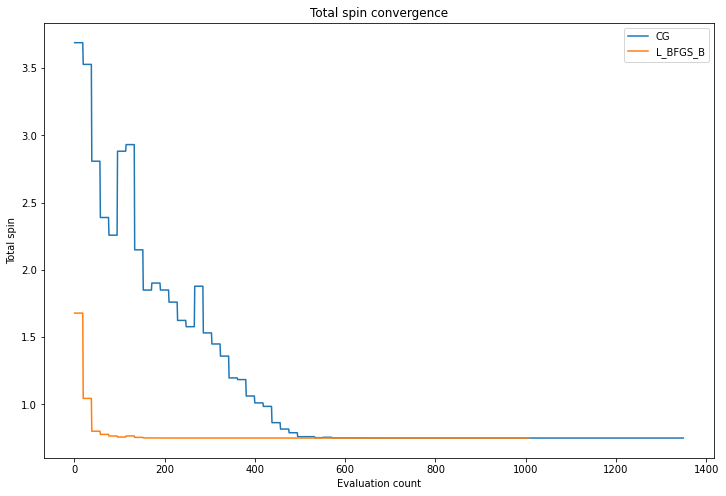

In [25]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Total spin")
plt.title("Total spin convergence")
plt.legend(loc='upper right')

In [28]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

cost_conv4=[]
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2])
        return val

    cost_conv4.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-03-04 09:48:25,354:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 4.25091748  0.06317865  3.54724111 -4.39934047  4.07529116  2.52918039
  1.26837222  1.55669904 -3.72060657 -4.56957117 -4.67756382 -2.32710555
 -5.43717754 -2.41064314  2.86846718  4.22622542  0.05967907  3.02999782]
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, der

### Cost function value and best states in the case of *RotGate* with depth $1$ and initial state $|\psi_1 \rangle = | 0 \rangle^{\otimes 5}$

In [29]:
for i,el in enumerate(cost_conv4):
    print("State label: ",lab_list[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(el['optimal_point']))     # To use with RealAmplitudes or TwoLocal
    #best_circ=var_form.construct_circuit(np.real(el['optimal_point']))        # To use with so4
    
    best_psi=CircuitStateFn(best_circ).to_matrix()
    # The best state
    print("|",lab_list[i],">=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi))),"\n")

State label:  (0, 0.5, -0.5)  , C(s_L,s,s_z) =  3.5572534851615413e-14
| (0, 0.5, -0.5) >=  + (-0.685+0.174j) |101⟩ + (0.685-0.174j) |011⟩
<optimal|optimal> =  0.939499009134989
< ideal | optimal > =  0.969277553678815 

State label:  (0, 0.5, 0.5)  , C(s_L,s,s_z) =  6.54712732753415e-12
| (0, 0.5, 0.5) >=  + (-0.061-0.704j) |100⟩ + (0.061+0.705j) |010⟩ + (-0.000-0.001j) |110⟩
<optimal|optimal> =  0.007493482406771258
< ideal | optimal > =  0.0865623803791434 

State label:  (1, 0.5, -0.5)  , C(s_L,s,s_z) =  0.04872346841897172
| (1, 0.5, -0.5) >= (-0.122-0.094j) |000⟩ + (0.002+0.003j) |100⟩ + (-0.001-0.003j) |010⟩ + (0.363-0.756j) |110⟩ + (0.004+0.017j) |001⟩ + (-0.223+0.463j) |101⟩ + (-0.041+0.085j) |011⟩ + (0.002+0.001j) |111⟩
<optimal|optimal> =  0.19811283587549988
< ideal | optimal > =  -0.40430177552380536 

State label:  (1, 0.5, 0.5)  , C(s_L,s,s_z) =  0.04906625714391121
| (1, 0.5, 0.5) >= (-0.006+0.012j) |000⟩ + (-0.073-0.058j) |100⟩ + (-0.407-0.314j) |010⟩ + (0.024-0.049j) 

We are going to consider the previous states using as coefficients the square of the absolute value of the previous complex coefficients.

In [30]:
for i,el in enumerate(cost_conv4):
    print("State label: ",lab_list[i],' , C(s_L,s,s_z) = ',el['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(el['optimal_point']))        # To use with RealAmplitudes or TwoLocal                  
    #best_circ=var_form.construct_circuit(np.real(el['optimal_point']))     # To use with so4 
    best_psi=CircuitStateFn(best_circ).to_matrix()
    
    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))
    
    # The best state
    print("|",lab_list[i],">=",to_ket(best_psi_rot))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[i]),to_state(np.real(best_psi_rot))),"\n")

State label:  (0, 0.5, -0.5)  , C(s_L,s,s_z) =  3.5572534851615413e-14
| (0, 0.5, -0.5) >=  + (-0.707) |101⟩ + (0.707) |011⟩
<optimal|optimal> =  1.0000000000000007
< ideal | optimal > =  0.9999999597628239 

State label:  (0, 0.5, 0.5)  , C(s_L,s,s_z) =  6.54712732753415e-12
| (0, 0.5, 0.5) >=  + (-0.707) |100⟩ + (0.707) |010⟩ + (-0.001) |110⟩
<optimal|optimal> =  1.0000000000000002
< ideal | optimal > =  0.9999993767054896 

State label:  (1, 0.5, -0.5)  , C(s_L,s,s_z) =  0.04872346841897172
| (1, 0.5, -0.5) >= (-0.154) |000⟩ + (0.003) |100⟩ + (-0.003) |010⟩ + (0.838) |110⟩ + (0.018) |001⟩ + (-0.514) |101⟩ + (-0.095) |011⟩ + (0.002) |111⟩
<optimal|optimal> =  1.0
< ideal | optimal > =  -0.9329259928429484 

State label:  (1, 0.5, 0.5)  , C(s_L,s,s_z) =  0.04906625714391121
| (1, 0.5, 0.5) >= (-0.013) |000⟩ + (-0.093) |100⟩ + (-0.514) |010⟩ + (0.054) |110⟩ + (0.837) |001⟩ + (-0.028) |101⟩ + (-0.004) |011⟩ + (-0.152) |111⟩
<optimal|optimal> =  0.9999999999999999
< ideal | optimal > =  

#### Analysis of the worst cases

| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,1/2,-1/2)$ | $0.933$ |  
|$(1,1/2,-1/2)$ | $0.931$ |  
|$(1,3/2,-1/2)$ | $0.034$ |  
|$(1,3/2,1/2)$ | $0.664$ | 

We see that the variational form is not shallow ($18$ gate parameters) and the results are not as good as seen in the other variational forms. We are going to discard this method.

# Galli's idea  
## Case $|s_L=1,s=1/2,s_z=-1/2\rangle$ and $|s_L=1,s=1/2,s_z=1/2\rangle$

We use the same **RY** circuit above initialized with $| \psi_1 \rangle = |0 \rangle^{\otimes 3}$, but this time we try by minimizing the cost function "step by step". Instead of using the complete cost function defined above:

$$C(s_L,s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

we start by optimizing the function

$$C(s)=\biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2$$

and then we add the other terms.


## RY with depth $4$ and initial state $|0 \rangle^{\otimes 3}$

In [13]:
psi_1=Zero(3)

#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,entanglement='linear',initial_state=psi_1,insert_barriers=True,reps=4)
print("Number of parameters: "+str(var_form.num_parameters))
print(var_form.draw())

Number of parameters: 15
     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├─░─┤ X ├──■───░─┤ RY(θ[7]) ├─░─»
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ »
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├─░─┤ RY(θ[8]) ├─░─»
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘ ░ »
«                ░  ┌──────────┐ ░            ░ ┌───────────┐
«q_0: ──■────────░──┤ RY(θ[9]) ├─░───■────────░─┤ RY(θ[12]) ├
«     ┌─┴─┐      ░ ┌┴──────────┤ ░ ┌─┴─┐      ░ ├───────────┤
«q_1: ┤ X ├──■───░─┤ RY(θ[10]) ├─░─┤ X ├──■───░─┤ RY(θ[13]) ├
«     └───┘┌─┴─┐ ░ ├───────────┤ ░ └───┘┌─┴─┐ ░ ├───────────┤
«q_2: ─────┤ X ├─░─┤ RY(θ[11]) ├─░──────┤ X ├─░─┤ RY(θ[14]) ├
«          └───┘ ░ └───────────┘ ░      └───┘ ░ └────────

In [14]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-04 09:31:39,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fe7b9366400>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fe7b936f6a0>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q

2021-03-04 09:31:39,331:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.82196451  1.46611586  0.68143639  0.4264002  -0.95662982 -1.97966717
  2.57480589 -2.45141151  2.75984632 -2.51021699 -1.10671061 -2.29348175
  1.51125962  2.77910638 -2.54586115]
2021-03-04 09:31:39,335:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does n

Optimizer: CG        

2021-03-04 09:31:39,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06133327] - 7.54523 (ms), eval count: 21
2021-03-04 09:31:39,538:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69699 (ms)
2021-03-04 09:31:39,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06133327] - 24.63293 (ms), eval count: 22
2021-03-04 09:31:39,575:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73800 (ms)
2021-03-04 09:31:39,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06133327] - 11.45506 (ms), eval count: 23
2021-03-04 09:31:39,587:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44219 (ms)
2021-03-04 09:31:39,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.06133327] - 11.12103 (ms), eval count: 24
2021-03-04 09:31:39,604:qiskit.aqua.operators.converter

2021-03-04 09:31:39,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63507 (ms)
2021-03-04 09:31:39,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.11502262] - 6.27303 (ms), eval count: 53
2021-03-04 09:31:39,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50704 (ms)
2021-03-04 09:31:39,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.11502262] - 5.74613 (ms), eval count: 54
2021-03-04 09:31:39,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08306 (ms)
2021-03-04 09:31:39,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.11502262] - 6.11424 (ms), eval count: 55
2021-03-04 09:31:39,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10476 (ms)
2021-03-04 09:31:39,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 09:31:40,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76025177] - 7.10106 (ms), eval count: 84
2021-03-04 09:31:40,235:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55592 (ms)
2021-03-04 09:31:40,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76025177] - 6.38890 (ms), eval count: 85
2021-03-04 09:31:40,243:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26498 (ms)
2021-03-04 09:31:40,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76025177] - 6.54387 (ms), eval count: 86
2021-03-04 09:31:40,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40786 (ms)
2021-03-04 09:31:40,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.76025177] - 6.09422 (ms), eval count: 87
2021-03-04 09:31:40,257:qiskit.aqua.operators.converters.c

2021-03-04 09:31:40,611:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75285052] - 8.31294 (ms), eval count: 115
2021-03-04 09:31:40,615:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79093 (ms)
2021-03-04 09:31:40,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75285052] - 7.65395 (ms), eval count: 116
2021-03-04 09:31:40,623:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75166 (ms)
2021-03-04 09:31:40,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75285052] - 7.24006 (ms), eval count: 117
2021-03-04 09:31:40,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61688 (ms)
2021-03-04 09:31:40,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75285052] - 7.09987 (ms), eval count: 118
2021-03-04 09:31:40,639:qiskit.aqua.operators.converte

2021-03-04 09:31:40,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001177] - 6.57010 (ms), eval count: 146
2021-03-04 09:31:40,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80817 (ms)
2021-03-04 09:31:40,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001177] - 6.48189 (ms), eval count: 147
2021-03-04 09:31:40,974:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39689 (ms)
2021-03-04 09:31:40,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001177] - 7.36880 (ms), eval count: 148
2021-03-04 09:31:40,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40810 (ms)
2021-03-04 09:31:40,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75001177] - 6.12807 (ms), eval count: 149
2021-03-04 09:31:40,992:qiskit.aqua.operators.converte

2021-03-04 09:31:41,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 8.96525 (ms), eval count: 177
2021-03-04 09:31:41,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48392 (ms)
2021-03-04 09:31:41,355:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 8.30221 (ms), eval count: 178
2021-03-04 09:31:41,357:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39070 (ms)
2021-03-04 09:31:41,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 6.06203 (ms), eval count: 179
2021-03-04 09:31:41,366:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47486 (ms)
2021-03-04 09:31:41,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000012] - 6.86312 (ms), eval count: 180
2021-03-04 09:31:41,390:qiskit.aqua.operators.converte

2021-03-04 09:31:41,672:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05016 (ms)
2021-03-04 09:31:41,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.98478 (ms), eval count: 209
2021-03-04 09:31:41,680:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12400 (ms)
2021-03-04 09:31:41,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.20105 (ms), eval count: 210
2021-03-04 09:31:41,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62768 (ms)
2021-03-04 09:31:41,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.15399 (ms), eval count: 211
2021-03-04 09:31:41,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63603 (ms)
2021-03-04 09:31:41,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-03-04 09:31:42,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.16424 (ms), eval count: 240
2021-03-04 09:31:42,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65098 (ms)
2021-03-04 09:31:42,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.18117 (ms), eval count: 241
2021-03-04 09:31:42,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55997 (ms)
2021-03-04 09:31:42,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.80184 (ms), eval count: 242
2021-03-04 09:31:42,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01123 (ms)
2021-03-04 09:31:42,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 19.67001 (ms), eval count: 243
2021-03-04 09:31:42,090:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2021-03-04 09:31:42,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.51693 (ms), eval count: 272
2021-03-04 09:31:42,387:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87325 (ms)
2021-03-04 09:31:42,393:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.41665 (ms), eval count: 273
2021-03-04 09:31:42,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55895 (ms)
2021-03-04 09:31:42,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 27.52376 (ms), eval count: 274
2021-03-04 09:31:42,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38109 (ms)
2021-03-04 09:31:42,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 15.60283 (ms), eval count: 275
2021-03-04 09:31:42,448:qiskit.aqua.operators.converters.circuit_sampler:DEB

2021-03-04 09:31:42,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.32772 (ms), eval count: 304
2021-03-04 09:31:42,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 3.433202028274536 seconds.
Found opt_params [ 2.39019051  1.21340029  0.99508276  0.39344639 -1.00003722 -1.90330593
  2.54469268 -2.37110306  2.29210487 -2.49797914 -1.09170179 -2.42764853
  1.44472824  2.80475197 -2.33930289] in 304 evals
2021-03-04 09:31:42,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiski

2021-03-04 09:31:42,791:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.74792686 -3.11281291  2.23355705 -3.08262291 -0.86261863  0.41555197
 -2.12892562  0.33988022 -2.98847258  2.20413853  0.16119422 -1.65634922
 -0.0461618   1.8154624   0.88391052]
2021-03-04 09:31:42,808:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-

optimal_parameters {Parameter(θ[0]): 2.3901905073065235, Parameter(θ[10]): 1.2134002915421325, Parameter(θ[11]): 0.9950827581483337, Parameter(θ[12]): 0.39344639214584204, Parameter(θ[13]): -1.0000372155277746, Parameter(θ[14]): -1.9033059334566078, Parameter(θ[1]): 2.5446926775734995, Parameter(θ[2]): -2.3711030592982993, Parameter(θ[3]): 2.292104870680412, Parameter(θ[4]): -2.497979136565413, Parameter(θ[5]): -1.0917017905843163, Parameter(θ[6]): -2.427648531638082, Parameter(θ[7]): 1.4447282394734944, Parameter(θ[8]): 2.8047519668020104, Parameter(θ[9]): -2.339302890919056}
optimal_point [ 2.39019051  1.21340029  0.99508276  0.39344639 -1.00003722 -1.90330593
  2.54469268 -2.37110306  2.29210487 -2.49797914 -1.09170179 -2.42764853
  1.44472824  2.80475197 -2.33930289]
optimal_value 0.7500000000000018
optimizer_evals 304
optimizer_time 3.433202028274536
eigenvalue (0.7500000000000018+0j)
eigenstate [-9.92675035e-09+0.j  4.50051946e-01+0.j -6.96234093e-01+0.j
  2.80406055e-01+0.j  2.4

2021-03-04 09:31:42,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64604 (ms)
2021-03-04 09:31:42,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.16245841] - 7.36284 (ms), eval count: 14
2021-03-04 09:31:42,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59597 (ms)
2021-03-04 09:31:42,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.16245841] - 6.28519 (ms), eval count: 15
2021-03-04 09:31:42,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18511 (ms)
2021-03-04 09:31:43,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.16245841] - 7.26914 (ms), eval count: 16
2021-03-04 09:31:43,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85990 (ms)
2021-03-04 09:31:43,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 09:31:43,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.88890691] - 6.41632 (ms), eval count: 45
2021-03-04 09:31:43,340:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60909 (ms)
2021-03-04 09:31:43,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.88890691] - 13.57627 (ms), eval count: 46
2021-03-04 09:31:43,361:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77178 (ms)
2021-03-04 09:31:43,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.88890691] - 13.24892 (ms), eval count: 47
2021-03-04 09:31:43,375:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65415 (ms)
2021-03-04 09:31:43,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.88890691] - 4.97890 (ms), eval count: 48
2021-03-04 09:31:43,384:qiskit.aqua.operators.converters

2021-03-04 09:31:43,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75998662] - 14.42313 (ms), eval count: 76
2021-03-04 09:31:43,727:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.91898 (ms)
2021-03-04 09:31:43,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75998662] - 14.12296 (ms), eval count: 77
2021-03-04 09:31:43,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88415 (ms)
2021-03-04 09:31:43,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75998662] - 15.43808 (ms), eval count: 78
2021-03-04 09:31:43,762:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42305 (ms)
2021-03-04 09:31:43,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75998662] - 8.29315 (ms), eval count: 79
2021-03-04 09:31:43,772:qiskit.aqua.operators.converter

2021-03-04 09:31:44,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005688] - 7.48992 (ms), eval count: 107
2021-03-04 09:31:44,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90108 (ms)
2021-03-04 09:31:44,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005688] - 9.22871 (ms), eval count: 108
2021-03-04 09:31:44,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53003 (ms)
2021-03-04 09:31:44,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005688] - 13.00931 (ms), eval count: 109
2021-03-04 09:31:44,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50864 (ms)
2021-03-04 09:31:44,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75005688] - 10.47802 (ms), eval count: 110
2021-03-04 09:31:44,143:qiskit.aqua.operators.conver

2021-03-04 09:31:44,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 14.11676 (ms), eval count: 138
2021-03-04 09:31:44,573:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24519 (ms)
2021-03-04 09:31:44,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 7.09701 (ms), eval count: 139
2021-03-04 09:31:44,586:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77798 (ms)
2021-03-04 09:31:44,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 15.07092 (ms), eval count: 140
2021-03-04 09:31:44,603:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65074 (ms)
2021-03-04 09:31:44,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000003] - 16.63828 (ms), eval count: 141
2021-03-04 09:31:44,621:qiskit.aqua.operators.conve

2021-03-04 09:31:44,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.60000 (ms), eval count: 169
2021-03-04 09:31:44,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81293 (ms)
2021-03-04 09:31:44,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.27701 (ms), eval count: 170
2021-03-04 09:31:44,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36399 (ms)
2021-03-04 09:31:44,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.82600 (ms), eval count: 171
2021-03-04 09:31:44,968:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80078 (ms)
2021-03-04 09:31:44,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 7.81322 (ms), eval count: 172
2021-03-04 09:31:44,979:qiskit.aqua.operators.converte

2021-03-04 09:31:45,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.750002] - 7.92599 (ms), eval count: 200
2021-03-04 09:31:45,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47192 (ms)
2021-03-04 09:31:45,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.750002] - 8.66318 (ms), eval count: 201
2021-03-04 09:31:45,330:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99208 (ms)
2021-03-04 09:31:45,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.750002] - 8.48627 (ms), eval count: 202
2021-03-04 09:31:45,340:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44005 (ms)
2021-03-04 09:31:45,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.750002] - 8.34274 (ms), eval count: 203
2021-03-04 09:31:45,352:qiskit.aqua.operators.converters.circu

2021-03-04 09:31:45,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.19113 (ms), eval count: 231
2021-03-04 09:31:45,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40691 (ms)
2021-03-04 09:31:45,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.11403 (ms), eval count: 232
2021-03-04 09:31:45,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69611 (ms)
2021-03-04 09:31:45,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.22804 (ms), eval count: 233
2021-03-04 09:31:45,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50704 (ms)
2021-03-04 09:31:45,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.87885 (ms), eval count: 234
2021-03-04 09:31:45,790:qiskit.aqua.operators.convert

2021-03-04 09:31:46,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.66089 (ms), eval count: 262
2021-03-04 09:31:46,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96290 (ms)
2021-03-04 09:31:46,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.91605 (ms), eval count: 263
2021-03-04 09:31:46,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42694 (ms)
2021-03-04 09:31:46,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.67813 (ms), eval count: 264
2021-03-04 09:31:46,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72202 (ms)
2021-03-04 09:31:46,144:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 24.67608 (ms), eval count: 265
2021-03-04 09:31:46,153:qiskit.aqua.operators.conver

2021-03-04 09:31:46,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 38.97691 (ms), eval count: 293
2021-03-04 09:31:46,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12097 (ms)
2021-03-04 09:31:46,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.32693 (ms), eval count: 294
2021-03-04 09:31:46,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56507 (ms)
2021-03-04 09:31:46,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.90215 (ms), eval count: 295
2021-03-04 09:31:46,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72973 (ms)
2021-03-04 09:31:46,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.13713 (ms), eval count: 296
2021-03-04 09:31:46,541:qiskit.aqua.operators.convert

2021-03-04 09:31:46,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.28321 (ms), eval count: 324
2021-03-04 09:31:46,895:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16191 (ms)
2021-03-04 09:31:46,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.45132 (ms), eval count: 325
2021-03-04 09:31:46,907:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34907 (ms)
2021-03-04 09:31:46,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.40497 (ms), eval count: 326
2021-03-04 09:31:46,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19321 (ms)
2021-03-04 09:31:46,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.23602 (ms), eval count: 327
2021-03-04 09:31:46,933:qiskit.aqua.operators.conver

2021-03-04 09:31:47,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.31301 (ms), eval count: 355
2021-03-04 09:31:47,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65296 (ms)
2021-03-04 09:31:47,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.37500 (ms), eval count: 356
2021-03-04 09:31:47,345:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67418 (ms)
2021-03-04 09:31:47,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.90198 (ms), eval count: 357
2021-03-04 09:31:47,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61600 (ms)
2021-03-04 09:31:47,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.14216 (ms), eval count: 358
2021-03-04 09:31:47,369:qiskit.aqua.operators.converte

2021-03-04 09:31:47,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.82902 (ms), eval count: 386
2021-03-04 09:31:47,717:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11906 (ms)
2021-03-04 09:31:47,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.54897 (ms), eval count: 387
2021-03-04 09:31:47,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53885 (ms)
2021-03-04 09:31:47,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.15701 (ms), eval count: 388
2021-03-04 09:31:47,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72005 (ms)
2021-03-04 09:31:47,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.94508 (ms), eval count: 389
2021-03-04 09:31:47,751:qiskit.aqua.operators.convert

2021-03-04 09:31:48,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 20.23983 (ms), eval count: 417
2021-03-04 09:31:48,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72114 (ms)
2021-03-04 09:31:48,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.96502 (ms), eval count: 418
2021-03-04 09:31:48,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17819 (ms)
2021-03-04 09:31:48,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.84826 (ms), eval count: 419
2021-03-04 09:31:48,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72410 (ms)
2021-03-04 09:31:48,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.19700 (ms), eval count: 420
2021-03-04 09:31:48,170:qiskit.aqua.operators.convert

2021-03-04 09:31:48,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 38.37109 (ms), eval count: 448
2021-03-04 09:31:48,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50983 (ms)
2021-03-04 09:31:48,549:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.30207 (ms), eval count: 449
2021-03-04 09:31:48,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88303 (ms)
2021-03-04 09:31:48,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 48.10596 (ms), eval count: 450
2021-03-04 09:31:48,623:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40295 (ms)
2021-03-04 09:31:48,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 15.19704 (ms), eval count: 451
2021-03-04 09:31:48,642:qiskit.aqua.operators.conv

2021-03-04 09:31:49,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.45616 (ms), eval count: 479
2021-03-04 09:31:49,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40500 (ms)
2021-03-04 09:31:49,138:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 4.56905 (ms), eval count: 480
2021-03-04 09:31:49,143:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13504 (ms)
2021-03-04 09:31:49,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 23.15211 (ms), eval count: 481
2021-03-04 09:31:49,178:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60608 (ms)
2021-03-04 09:31:49,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 22.91727 (ms), eval count: 482
2021-03-04 09:31:49,209:qiskit.aqua.operators.conver

2021-03-04 09:31:49,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.42285 (ms), eval count: 510
2021-03-04 09:31:49,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49918 (ms)
2021-03-04 09:31:49,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.52599 (ms), eval count: 511
2021-03-04 09:31:49,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47462 (ms)
2021-03-04 09:31:49,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 16.44206 (ms), eval count: 512
2021-03-04 09:31:49,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 6.77928614616394 seconds.
Found opt_params [-0.22110263 -3.14156299  2.02692527 -3.12137576 -0.36396093  0.01839779
 -1.90650404 -0.28701556 -3.13823391  2.40182093  0.9450928  -1.54669112
 -0.34738099  1.26737188 

optimal_parameters {Parameter(θ[0]): -0.22110263228341373, Parameter(θ[10]): -3.141562987804794, Parameter(θ[11]): 2.026925270189416, Parameter(θ[12]): -3.1213757636529853, Parameter(θ[13]): -0.36396093010888336, Parameter(θ[14]): 0.018397794944197396, Parameter(θ[1]): -1.9065040360016594, Parameter(θ[2]): -0.2870155581222186, Parameter(θ[3]): -3.1382339099152157, Parameter(θ[4]): 2.4018209264548527, Parameter(θ[5]): 0.9450927980087125, Parameter(θ[6]): -1.5466911186800008, Parameter(θ[7]): -0.3473809926020005, Parameter(θ[8]): 1.2673718846706539, Parameter(θ[9]): 1.3625839905700887}
optimal_point [-0.22110263 -3.14156299  2.02692527 -3.12137576 -0.36396093  0.01839779
 -1.90650404 -0.28701556 -3.13823391  2.40182093  0.9450928  -1.54669112
 -0.34738099  1.26737188  1.36258399]
optimal_value 0.7500000055708513
optimizer_evals 512
optimizer_time 6.77928614616394
eigenvalue (0.7500000055708513+0j)
eigenstate [ 9.53100484e-06+0.j -1.50074018e-01+0.j -5.82009447e-01+0.j
 -1.55807607e-01+0.

In the following function we select the order of the added terms. We start from the term with $s$ and then add $s_z$ and $s_L$$.

In [15]:
# count is used to know the terms to add
# Warning - Order is important
def spin_cost2(count,v,l,J,M):
    l2=l*(l+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    if count==0:
        return op2
    elif count==1:
        return op2+op3
    elif count==2:
        return op1+op2+op3

In [16]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
lab_list2=[(1,1.5,-0.5),(1,1.5,0.5)]
min_val=[]

for l in lab_list2:
    for c in range(3):
        
        def VQE_spin_cost2(x):
            # Here we convert the circuit corresponding to the variational state into a vector
            #circ=var_form.construct_circuit(x)       # To use with so4
            circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
            circ_v=CircuitStateFn(circ).to_matrix()
            #print(circ_v)

            val=spin_cost2(c,circ_v,l[0],l[1],l[2])
            return val
        
        if c==0:
            step_val=algo.find_minimum(cost_fn=VQE_spin_cost2,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
        else:
            step_val=algo.find_minimum(initial_point=step_opt_point,cost_fn=VQE_spin_cost2,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
    min_val.append(step_val)

2021-03-04 09:31:49,618:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.22896398 -2.05021081  2.80021146  2.20383614 -0.26182831  2.64133742
  1.94659189  0.03579089 -2.82083042 -0.04422029  0.51001293  1.38528183
 -2.87292061 -1.40331463  1.88661031]
2021-03-04 09:31:49,621:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does n

2021-03-04 09:32:54,226:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-03-04 09:33:10,974:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793,

### RY cost function with depth $4$ and initial state $|0\rangle^{\otimes 3}$

In [21]:
print('SPIN LABELS REMINDER: (s_L, s, s_z)',"\n")

for i,l in enumerate(lab_list2):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # The best state
    print("|optimal state)=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

SPIN LABELS REMINDER: (s_L, s, s_z) 

State label:  (1, 1.5, -0.5)
Optimal cost:  5.640454882417343e-13
|optimal state)= (0.190+0.000j) |000⟩ + (-0.325+0.000j) |100⟩ + (-0.325+0.000j) |010⟩ + (-0.292+0.000j) |110⟩ + (-0.326+0.000j) |001⟩ + (-0.292+0.000j) |101⟩ + (-0.293+0.000j) |011⟩ + (0.624+0.000j) |111⟩
<optimal|optimal> =  1.0000000000000004
< ideal | optimal > =  -0.5064861665715419 

State label:  (1, 1.5, 0.5)
Optimal cost:  (1.7245346957859998e-14+0j)
|optimal state)= (0.680+0.000j) |000⟩ + (0.273+0.000j) |100⟩ + (0.273+0.000j) |010⟩ + (0.234+0.000j) |110⟩ + (0.273+0.000j) |001⟩ + (0.235+0.000j) |101⟩ + (0.234+0.000j) |011⟩ + (-0.386+0.000j) |111⟩
<optimal|optimal> =  1.0000000000000004
< ideal | optimal > =  0.472776030041156 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|
|$(1,3/2,-1/2)$ | $0.506$ |  
|$(1,3/2,1/2)$ | $0.473$ | 

Even if the depth of the circuit is high ($4$), we can see that the state $|s_L=1,s=1/2,s_z=-1/2\rangle$ doesn't reach accuracy $|\langle \psi_{ideal}|\psi_{optimal} \rangle| = 0.93$ as before and $|s_L=1,s=1/2,s_z=1/2\rangle$ doesn't reach accuracy $|\langle \psi_{ideal}|\psi_{optimal} \rangle| = 0.81$.

Initializing the state to $\frac{|\uparrow_0 \downarrow_1 \rangle + |\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}}|\uparrow_2\rangle$, we don't find any improvement. 

# RY with cost function based on spin operators and spin-spin correlations

# Case of $|s_L=1,s=1/2,s_z=-1/2\rangle$ and $|s_L=1,s=1/2,s_z=1/2\rangle$

### Cost function with spin-spin correlation

We start from creating the spin operators and the spin-spin correlation functions.

In [37]:
spins = generate_spin_operators(3)
print("Spin Operators:")
mat_spin=[]
for name_s,s in spins:
    print(name_s+' '+str(s))
    mat_spin.append(s.to_matrix())
    
mat_spinspin=[]
spin_spin=generate_spinspin_operators(3)
#print("Spin-spin operators number: "+str(len(spin_spin)))
for name_s,s in spin_spin:
    #print(name_s+' '+str(s))
    mat_spinspin.append(s.to_matrix())

Spin Operators:
0x IIX
0y IIY
0z IIZ
1x IXI
1y IYI
1z IZI
2x XII
2y YII
2z ZII


Now we use the exact eigenstates of total spin to evaluate the following quantity:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value.

Eigenstate:  (0, 0.5, -0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2+0j)
     Spin-spin  0-1  0j
     Spin-spin  0-2  0j
     Spin-spin  1-0  0j
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-3+0j)
     Spin-spin  2-0  0j
     Spin-spin  2-1  (-3+0j)
     Spin-spin  2-2  (3+0j)


<ipython-input-36-018936f1c633>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


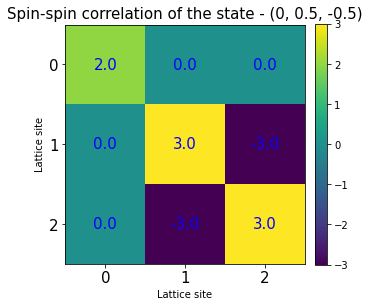

Eigenstate:  (0, 0.5, 0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2+0j)
     Spin-spin  0-1  0j
     Spin-spin  0-2  0j
     Spin-spin  1-0  0j
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-3+0j)
     Spin-spin  2-0  0j
     Spin-spin  2-1  (-3+0j)
     Spin-spin  2-2  (3+0j)


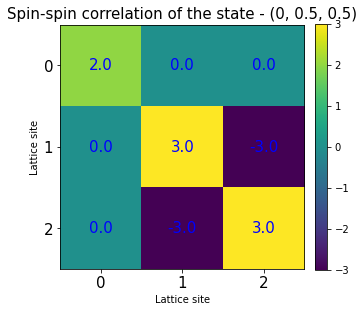

Eigenstate:  (1, 0.5, -0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-2.222222+0j)
     Spin-spin  0-2  (-2.222222+0j)
     Spin-spin  1-0  (-2.222222+0j)
     Spin-spin  1-1  (2.555556+0j)
     Spin-spin  1-2  (0.555556+0j)
     Spin-spin  2-0  (-2.222222+0j)
     Spin-spin  2-1  (0.555556+0j)
     Spin-spin  2-2  (2.555556+0j)


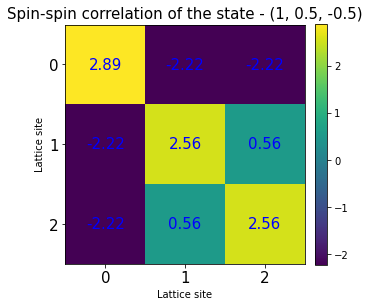

Eigenstate:  (1, 0.5, 0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-2.222222+0j)
     Spin-spin  0-2  (-2.222222+0j)
     Spin-spin  1-0  (-2.222222+0j)
     Spin-spin  1-1  (2.555556+0j)
     Spin-spin  1-2  (0.555556+0j)
     Spin-spin  2-0  (-2.222222+0j)
     Spin-spin  2-1  (0.555556+0j)
     Spin-spin  2-2  (2.555556+0j)


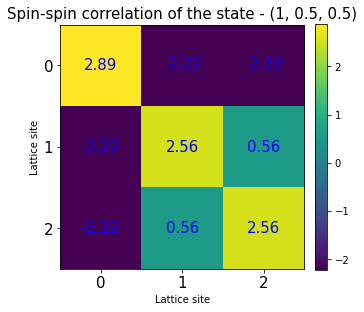

Eigenstate:  (1, 1.5, -1.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2+0j)
     Spin-spin  0-1  0j
     Spin-spin  0-2  0j
     Spin-spin  1-0  0j
     Spin-spin  1-1  (2+0j)
     Spin-spin  1-2  0j
     Spin-spin  2-0  0j
     Spin-spin  2-1  0j
     Spin-spin  2-2  (2+0j)


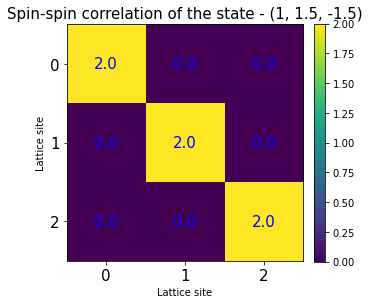

Eigenstate:  (1, 1.5, -0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (0.888889+0j)
     Spin-spin  0-2  (0.888889+0j)
     Spin-spin  1-0  (0.888889+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (0.888889+0j)
     Spin-spin  2-0  (0.888889+0j)
     Spin-spin  2-1  (0.888889+0j)
     Spin-spin  2-2  (2.888889+0j)


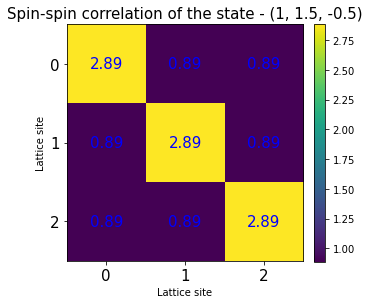

Eigenstate:  (1, 1.5, 0.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (0.888889+0j)
     Spin-spin  0-2  (0.888889+0j)
     Spin-spin  1-0  (0.888889+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (0.888889+0j)
     Spin-spin  2-0  (0.888889+0j)
     Spin-spin  2-1  (0.888889+0j)
     Spin-spin  2-2  (2.888889+0j)


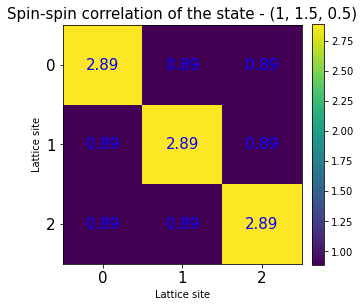

Eigenstate:  (1, 1.5, 1.5)
Spin-spin correlation values:
     Spin-spin  0-0  (2+0j)
     Spin-spin  0-1  0j
     Spin-spin  0-2  0j
     Spin-spin  1-0  0j
     Spin-spin  1-1  (2+0j)
     Spin-spin  1-2  0j
     Spin-spin  2-0  0j
     Spin-spin  2-1  0j
     Spin-spin  2-2  (2+0j)


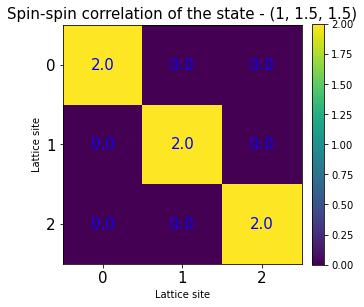

In [36]:
eig_3spins=[]
for v in psi_LC.values():
    eig_3spins.append(np.concatenate(np.concatenate(v)))

matrices=[]
    
for i,eig in enumerate(eig_3spins):
        print("Eigenstate: ",lab_list[i])
        print("Spin-spin correlation values:")
        
        ss=[0]*(3*3)
        s=[0]*(3*3)
        M=np.zeros((3,3))
        
        n=0
        p=0
        for j in range(3):
            for k in range(3):
                sj=0
                sk=0
                for l in range(3): # This 3 refers to {x,y,z}
                    ss[p] += np.dot(np.conjugate(eig),np.dot(mat_spinspin[n],eig))
                    sj+=np.dot(np.conjugate(eig),np.dot(mat_spin[3*j+l],eig))**2
                    sk+=np.dot(np.conjugate(eig),np.dot(mat_spin[3*k+l],eig))**2
                    n += 1
                
                s[p]=pow(sj,0.5)*pow(sk,0.5)
                M[j,k]=ss[p]-s[p]
                print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
                p+=1
        
        # We store the spin-spin correlation values
        matrices.append(M)
        
        #Here we create a visual representation of the spin-spin correlation values
        fig, ax = plt.subplots(figsize=(5,10))
        im = ax.imshow(M)
        
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(np.arange(3), fontsize=15)
        ax.set_yticklabels(np.arange(3), fontsize=15)

        ax.set_xlabel("Lattice site")
        ax.set_ylabel("Lattice site")
        
        fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

        for ii in range(3):
            for jj in range(3):
                text = ax.text(jj, ii, round(M[ii, jj],2),
                               ha="center", va="center", color="b", fontsize=15)

        ax.set_title("Spin-spin correlation of the state - "+str(lab_list[i]), fontsize=15)
        fig.tight_layout()
        plt.show()

We want to use the **find_minimum** algorithm of **VQE** function to find the eigenstates of total spin $\hat{S}$ by using the following cost function:

$$C(\{s_{ij}^C\}) = \sum_{i,j} \biggl(\langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle - s_{ij}^C\biggr)$$

where $\{s_{ij}^C\}$ are the expected correlation values for each couple of spins in sites $i,j$ and the expectation values refer to the variational state which is created step by step during the optimization.


**Question -** Is there a better way to use correlation functions? As we can see from the correlation values above some states have the same value, e.g. $| s_L=0,s=1/2,s_z=-1/2\rangle$ and $| s_L=0,s=1/2,s_z=1/2\rangle$. Among the $8$ states we have $4$ couples of spin-spin correlation values.

**Answer -** We could use this correlation function in addition to the spin cost function used before.  

In [37]:
spinspin_val=[[] for i in range(len(matrices))]
for iel,el in enumerate(matrices):
    v=np.concatenate(el)
    for iv in v:
        spinspin_val[iel].append(iv)
    
#print(spinspin_val)

### Cost function for Galli's idea

We use the same **RY** circuit above initialized with $| \psi_1 \rangle = |0 \rangle^{\otimes 3}$ and, again, we start minimizing the cost function "step by step". The cost function is:

$$C(s_L,s,s_z,\{s_{ij}^C\}) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2 + \underbrace{\sum_{i,j} \biggl(\langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle - s_{ij}^C\biggr)}_{9 \, \text{terms}}$$

We start by optimizing the function

$$C(\{s_{ij}^C\})=\sum_{i,j} \biggl(\langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle - s_{ij}^C\biggr)$$

and then we add the total spin term, the left-spin term and the $z$-component term. Each time the algorithm starts from the optimal state of the previous optimization.

### RY with depth $3$ and initial state $|0 \rangle^{\otimes 3}$

In [32]:
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,entanglement='linear',initial_state=psi_1,insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■───░─┤ RY(θ[4]) ├─░─┤ X ├──■───░─┤ RY(θ[7]) ├─░─»
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ »
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├─░─┤ RY(θ[5]) ├─░──────┤ X ├─░─┤ RY(θ[8]) ├─░─»
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘ ░ »
«                ░  ┌──────────┐
«q_0: ──■────────░──┤ RY(θ[9]) ├
«     ┌─┴─┐      ░ ┌┴──────────┤
«q_1: ┤ X ├──■───░─┤ RY(θ[10]) ├
«     └───┘┌─┴─┐ ░ ├───────────┤
«q_2: ─────┤ X ├─░─┤ RY(θ[11]) ├
«          └───┘ ░ └───────────┘


In [33]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(s2, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-03-04 10:10:34,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fe7b981b430>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fe7b933a280>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐ ░ »
q_0: ┤ RY(θ[0]) ├─░───■────────░─┤ RY(θ[3]) ├─░───■────────░─┤ RY(θ[6]) ├─░─»
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ »
q

2021-03-04 10:10:34,771:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-03-04 10:10:34,786:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-04 10:10:34,787:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 18 operations with depth 10
op_counts: OrderedDict([('ry', 12), ('barrier', 6), ('cx', 6)])

2021-03-04 10:10:34,788:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-03-04 10:10:34,789:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 18 operations with depth 10
op_counts: OrderedDict([('ry', 12), ('barrier', 6), ('cx', 6)])

2021-03-04 10:10:34,796:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.16908 (ms)
2021-03-04 10:10:34,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.85438169] - 21.66486 (ms), 

Optimizer: CG        

2021-03-04 10:10:34,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60901 (ms)
2021-03-04 10:10:35,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.8730599] - 15.97905 (ms), eval count: 22
2021-03-04 10:10:35,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82907 (ms)
2021-03-04 10:10:35,032:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.8730599] - 16.65306 (ms), eval count: 23
2021-03-04 10:10:35,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40898 (ms)
2021-03-04 10:10:35,044:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.87305991] - 7.27916 (ms), eval count: 24
2021-03-04 10:10:35,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07822 (ms)
2021-03-04 10:10:35,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-03-04 10:10:35,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81261973] - 8.59690 (ms), eval count: 53
2021-03-04 10:10:35,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13511 (ms)
2021-03-04 10:10:35,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81261972] - 7.27296 (ms), eval count: 54
2021-03-04 10:10:35,345:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47319 (ms)
2021-03-04 10:10:35,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81261973] - 5.36394 (ms), eval count: 55
2021-03-04 10:10:35,354:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78003 (ms)
2021-03-04 10:10:35,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.81261973] - 9.49287 (ms), eval count: 56
2021-03-04 10:10:35,367:qiskit.aqua.operators.converters.c

2021-03-04 10:10:35,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75563056] - 7.34496 (ms), eval count: 84
2021-03-04 10:10:35,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35684 (ms)
2021-03-04 10:10:35,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75563056] - 7.13706 (ms), eval count: 85
2021-03-04 10:10:35,790:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32394 (ms)
2021-03-04 10:10:35,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75563056] - 9.31025 (ms), eval count: 86
2021-03-04 10:10:35,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49488 (ms)
2021-03-04 10:10:35,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75563056] - 6.45566 (ms), eval count: 87
2021-03-04 10:10:35,811:qiskit.aqua.operators.converters.c

2021-03-04 10:10:36,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75014076] - 6.51503 (ms), eval count: 115
2021-03-04 10:10:36,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85101 (ms)
2021-03-04 10:10:36,123:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75014076] - 8.01086 (ms), eval count: 116
2021-03-04 10:10:36,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12312 (ms)
2021-03-04 10:10:36,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75014076] - 7.02190 (ms), eval count: 117
2021-03-04 10:10:36,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33300 (ms)
2021-03-04 10:10:36,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75059671] - 5.71179 (ms), eval count: 118
2021-03-04 10:10:36,144:qiskit.aqua.operators.converte

2021-03-04 10:10:36,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000992] - 9.73392 (ms), eval count: 146
2021-03-04 10:10:36,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16897 (ms)
2021-03-04 10:10:36,482:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000992] - 6.25420 (ms), eval count: 147
2021-03-04 10:10:36,489:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11310 (ms)
2021-03-04 10:10:36,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000992] - 5.68914 (ms), eval count: 148
2021-03-04 10:10:36,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63293 (ms)
2021-03-04 10:10:36,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000992] - 6.23894 (ms), eval count: 149
2021-03-04 10:10:36,508:qiskit.aqua.operators.converte

2021-03-04 10:10:36,808:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000563] - 7.75504 (ms), eval count: 177
2021-03-04 10:10:36,810:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48177 (ms)
2021-03-04 10:10:36,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000563] - 6.52909 (ms), eval count: 178
2021-03-04 10:10:36,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38211 (ms)
2021-03-04 10:10:36,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000563] - 7.27868 (ms), eval count: 179
2021-03-04 10:10:36,834:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35875 (ms)
2021-03-04 10:10:36,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000563] - 7.81226 (ms), eval count: 180
2021-03-04 10:10:36,844:qiskit.aqua.operators.converte

2021-03-04 10:10:37,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000112] - 9.31001 (ms), eval count: 208
2021-03-04 10:10:37,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95694 (ms)
2021-03-04 10:10:37,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000083] - 11.77907 (ms), eval count: 209
2021-03-04 10:10:37,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90911 (ms)
2021-03-04 10:10:37,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000083] - 16.09182 (ms), eval count: 210
2021-03-04 10:10:37,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55013 (ms)
2021-03-04 10:10:37,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000083] - 23.20576 (ms), eval count: 211
2021-03-04 10:10:37,365:qiskit.aqua.operators.conve

2021-03-04 10:10:37,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000051] - 18.04399 (ms), eval count: 239
2021-03-04 10:10:37,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18995 (ms)
2021-03-04 10:10:37,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000051] - 12.07089 (ms), eval count: 240
2021-03-04 10:10:37,805:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19393 (ms)
2021-03-04 10:10:37,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000051] - 10.62775 (ms), eval count: 241
2021-03-04 10:10:37,818:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62690 (ms)
2021-03-04 10:10:37,827:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000051] - 11.80696 (ms), eval count: 242
2021-03-04 10:10:37,836:qiskit.aqua.operators.conv

2021-03-04 10:10:38,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 13.71598 (ms), eval count: 270
2021-03-04 10:10:38,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02529 (ms)
2021-03-04 10:10:38,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 13.48901 (ms), eval count: 271
2021-03-04 10:10:38,327:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09188 (ms)
2021-03-04 10:10:38,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 9.09901 (ms), eval count: 272
2021-03-04 10:10:38,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71185 (ms)
2021-03-04 10:10:38,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000008] - 6.26922 (ms), eval count: 273
2021-03-04 10:10:38,355:qiskit.aqua.operators.conver

2021-03-04 10:10:38,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16198 (ms)
2021-03-04 10:10:38,676:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.05004 (ms), eval count: 302
2021-03-04 10:10:38,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18303 (ms)
2021-03-04 10:10:38,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.99885 (ms), eval count: 303
2021-03-04 10:10:38,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25790 (ms)
2021-03-04 10:10:38,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.29704 (ms), eval count: 304
2021-03-04 10:10:38,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38092 (ms)
2021-03-04 10:10:38,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-04 10:10:39,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35589 (ms)
2021-03-04 10:10:39,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.09612 (ms), eval count: 334
2021-03-04 10:10:39,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76001 (ms)
2021-03-04 10:10:39,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.63400 (ms), eval count: 335
2021-03-04 10:10:39,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.42903 (ms)
2021-03-04 10:10:39,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 27.93288 (ms), eval count: 336
2021-03-04 10:10:39,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23279 (ms)
2021-03-04 10:10:39,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0

2021-03-04 10:10:39,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28024 (ms)
2021-03-04 10:10:39,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 5.30005 (ms), eval count: 366
2021-03-04 10:10:39,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55807 (ms)
2021-03-04 10:10:39,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.07293 (ms), eval count: 367
2021-03-04 10:10:39,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21992 (ms)
2021-03-04 10:10:39,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.39996 (ms), eval count: 368
2021-03-04 10:10:39,472:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36495 (ms)
2021-03-04 10:10:39,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-04 10:10:39,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97577 (ms)
2021-03-04 10:10:39,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 7.36475 (ms), eval count: 398
2021-03-04 10:10:39,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51706 (ms)
2021-03-04 10:10:39,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 6.27208 (ms), eval count: 399
2021-03-04 10:10:39,805:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16889 (ms)
2021-03-04 10:10:39,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75] - 8.30913 (ms), eval count: 400
2021-03-04 10:10:39,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90418 (ms)
2021-03-04 10:10:39,826:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.

2021-03-04 10:10:39,900:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.25286905  1.0766892  -0.96799823  2.59015433  2.20596437 -0.83622721
  1.69685137  1.08736262  0.38633635  2.55962912 -2.32975236 -1.71017932]
2021-03-04 10:10:39,913:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-03-04 10:10:39,916:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 3 qubits, 0 classical bits and 18 operations with depth 10
op_counts

optimal_parameters {Parameter(θ[0]): -0.5793484309531969, Parameter(θ[10]): 0.3097940146042036, Parameter(θ[11]): -0.1666884155452359, Parameter(θ[1]): 0.4034596219131305, Parameter(θ[2]): 0.1941916614877372, Parameter(θ[3]): -0.39818167871262955, Parameter(θ[4]): -0.6991548634754252, Parameter(θ[5]): 0.7154990533547911, Parameter(θ[6]): 1.5419327449347437, Parameter(θ[7]): -0.9340097560575532, Parameter(θ[8]): 1.796283382075783, Parameter(θ[9]): -1.322691570281321}
optimal_point [-0.57934843  0.30979401 -0.16668842  0.40345962  0.19419166 -0.39818168
 -0.69915486  0.71549905  1.54193274 -0.93400976  1.79628338 -1.32269157]
optimal_value 0.7500000000000006
optimizer_evals 403
optimizer_time 5.105103969573975
eigenvalue (0.7500000000000006+0j)
eigenstate [ 1.17839432e-08+0.j -1.13558632e-01+0.j  4.98957675e-02+0.j
  4.34448249e-01+0.j  6.36628640e-02+0.j -8.07750995e-01+0.j
  3.73302744e-01+0.j  6.58751645e-09+0.j]
cost_function_evals 403
Optimizer: L_BFGS_B        

2021-03-04 10:10:40,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35174991] - 7.23290 (ms), eval count: 16
2021-03-04 10:10:40,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37679 (ms)
2021-03-04 10:10:40,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35174991] - 9.72986 (ms), eval count: 17
2021-03-04 10:10:40,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19209 (ms)
2021-03-04 10:10:40,121:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35174991] - 5.89013 (ms), eval count: 18
2021-03-04 10:10:40,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79665 (ms)
2021-03-04 10:10:40,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35174991] - 7.68304 (ms), eval count: 19
2021-03-04 10:10:40,136:qiskit.aqua.operators.converters.c

2021-03-04 10:10:40,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17707 (ms)
2021-03-04 10:10:40,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84181417] - 6.40011 (ms), eval count: 48
2021-03-04 10:10:40,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34890 (ms)
2021-03-04 10:10:40,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84181417] - 6.80900 (ms), eval count: 49
2021-03-04 10:10:40,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15983 (ms)
2021-03-04 10:10:40,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.84181417] - 12.10117 (ms), eval count: 50
2021-03-04 10:10:40,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36988 (ms)
2021-03-04 10:10:40,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-03-04 10:10:40,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75189894] - 7.01499 (ms), eval count: 79
2021-03-04 10:10:40,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16293 (ms)
2021-03-04 10:10:40,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75189894] - 7.24721 (ms), eval count: 80
2021-03-04 10:10:40,770:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54805 (ms)
2021-03-04 10:10:40,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75189894] - 5.78833 (ms), eval count: 81
2021-03-04 10:10:40,786:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08895 (ms)
2021-03-04 10:10:40,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75189894] - 14.02378 (ms), eval count: 82
2021-03-04 10:10:40,799:qiskit.aqua.operators.converters.

2021-03-04 10:10:41,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500025] - 14.67490 (ms), eval count: 110
2021-03-04 10:10:41,158:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83201 (ms)
2021-03-04 10:10:41,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500025] - 7.82108 (ms), eval count: 111
2021-03-04 10:10:41,168:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48511 (ms)
2021-03-04 10:10:41,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500025] - 6.88577 (ms), eval count: 112
2021-03-04 10:10:41,179:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47407 (ms)
2021-03-04 10:10:41,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.7500025] - 9.39083 (ms), eval count: 113
2021-03-04 10:10:41,188:qiskit.aqua.operators.converters.

2021-03-04 10:10:41,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000013] - 16.05868 (ms), eval count: 141
2021-03-04 10:10:41,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11494 (ms)
2021-03-04 10:10:41,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000013] - 12.20679 (ms), eval count: 142
2021-03-04 10:10:41,626:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53017 (ms)
2021-03-04 10:10:41,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000013] - 6.13594 (ms), eval count: 143
2021-03-04 10:10:41,634:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88589 (ms)
2021-03-04 10:10:41,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 6.78301 (ms), eval count: 144
2021-03-04 10:10:41,642:qiskit.aqua.operators.conver

2021-03-04 10:10:41,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.78215 (ms), eval count: 172
2021-03-04 10:10:41,933:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66702 (ms)
2021-03-04 10:10:41,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 5.98693 (ms), eval count: 173
2021-03-04 10:10:41,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18296 (ms)
2021-03-04 10:10:41,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.83818 (ms), eval count: 174
2021-03-04 10:10:41,953:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31893 (ms)
2021-03-04 10:10:41,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.08978 (ms), eval count: 175
2021-03-04 10:10:41,965:qiskit.aqua.operators.converte

2021-03-04 10:10:42,389:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000063] - 13.80992 (ms), eval count: 203
2021-03-04 10:10:42,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.56095 (ms)
2021-03-04 10:10:42,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000063] - 11.79385 (ms), eval count: 204
2021-03-04 10:10:42,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93787 (ms)
2021-03-04 10:10:42,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000063] - 13.58676 (ms), eval count: 205
2021-03-04 10:10:42,425:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41978 (ms)
2021-03-04 10:10:42,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000063] - 8.22210 (ms), eval count: 206
2021-03-04 10:10:42,434:qiskit.aqua.operators.conve

2021-03-04 10:10:42,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.67796 (ms), eval count: 234
2021-03-04 10:10:42,741:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40691 (ms)
2021-03-04 10:10:42,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 8.25405 (ms), eval count: 235
2021-03-04 10:10:42,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82509 (ms)
2021-03-04 10:10:42,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 10.61893 (ms), eval count: 236
2021-03-04 10:10:42,773:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.92096 (ms)
2021-03-04 10:10:42,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000002] - 14.87017 (ms), eval count: 237
2021-03-04 10:10:42,785:qiskit.aqua.operators.conver

2021-03-04 10:10:43,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000211] - 7.68900 (ms), eval count: 265
2021-03-04 10:10:43,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35605 (ms)
2021-03-04 10:10:43,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000211] - 8.49891 (ms), eval count: 266
2021-03-04 10:10:43,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29390 (ms)
2021-03-04 10:10:43,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000211] - 7.26795 (ms), eval count: 267
2021-03-04 10:10:43,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92571 (ms)
2021-03-04 10:10:43,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000211] - 8.47483 (ms), eval count: 268
2021-03-04 10:10:43,202:qiskit.aqua.operators.converte

2021-03-04 10:10:43,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.43992 (ms), eval count: 296
2021-03-04 10:10:43,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18399 (ms)
2021-03-04 10:10:43,539:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.85120 (ms), eval count: 297
2021-03-04 10:10:43,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70891 (ms)
2021-03-04 10:10:43,549:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.24418 (ms), eval count: 298
2021-03-04 10:10:43,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33810 (ms)
2021-03-04 10:10:43,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.98895 (ms), eval count: 299
2021-03-04 10:10:43,567:qiskit.aqua.operators.convert

2021-03-04 10:10:43,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.03104 (ms), eval count: 327
2021-03-04 10:10:43,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48885 (ms)
2021-03-04 10:10:43,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 13.59105 (ms), eval count: 328
2021-03-04 10:10:43,975:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64001 (ms)
2021-03-04 10:10:43,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.41205 (ms), eval count: 329
2021-03-04 10:10:43,985:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48106 (ms)
2021-03-04 10:10:43,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.88601 (ms), eval count: 330
2021-03-04 10:10:43,994:qiskit.aqua.operators.convert

2021-03-04 10:10:44,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.09517 (ms), eval count: 358
2021-03-04 10:10:44,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42694 (ms)
2021-03-04 10:10:44,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.63979 (ms), eval count: 359
2021-03-04 10:10:44,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02799 (ms)
2021-03-04 10:10:44,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.10614 (ms), eval count: 360
2021-03-04 10:10:44,302:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90091 (ms)
2021-03-04 10:10:44,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.77013 (ms), eval count: 361
2021-03-04 10:10:44,311:qiskit.aqua.operators.converte

2021-03-04 10:10:44,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.58298 (ms), eval count: 389
2021-03-04 10:10:44,594:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30630 (ms)
2021-03-04 10:10:44,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.10995 (ms), eval count: 390
2021-03-04 10:10:44,602:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05493 (ms)
2021-03-04 10:10:44,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000023] - 7.57313 (ms), eval count: 391
2021-03-04 10:10:44,619:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44570 (ms)
2021-03-04 10:10:44,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000023] - 13.14998 (ms), eval count: 392
2021-03-04 10:10:44,637:qiskit.aqua.operators.convert

2021-03-04 10:10:44,930:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.16884 (ms), eval count: 420
2021-03-04 10:10:44,933:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90067 (ms)
2021-03-04 10:10:44,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 6.51717 (ms), eval count: 421
2021-03-04 10:10:44,941:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29692 (ms)
2021-03-04 10:10:44,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.51591 (ms), eval count: 422
2021-03-04 10:10:44,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08101 (ms)
2021-03-04 10:10:44,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 14.34016 (ms), eval count: 423
2021-03-04 10:10:44,975:qiskit.aqua.operators.convert

2021-03-04 10:10:45,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.59811 (ms), eval count: 451
2021-03-04 10:10:45,332:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37806 (ms)
2021-03-04 10:10:45,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.23276 (ms), eval count: 452
2021-03-04 10:10:45,343:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87802 (ms)
2021-03-04 10:10:45,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.52101 (ms), eval count: 453
2021-03-04 10:10:45,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45316 (ms)
2021-03-04 10:10:45,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.34799 (ms), eval count: 454
2021-03-04 10:10:45,365:qiskit.aqua.operators.convert

2021-03-04 10:10:45,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.54015 (ms), eval count: 482
2021-03-04 10:10:45,749:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18813 (ms)
2021-03-04 10:10:45,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 19.13095 (ms), eval count: 483
2021-03-04 10:10:45,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22301 (ms)
2021-03-04 10:10:45,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.47087 (ms), eval count: 484
2021-03-04 10:10:45,794:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53708 (ms)
2021-03-04 10:10:45,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 5.49412 (ms), eval count: 485
2021-03-04 10:10:45,805:qiskit.aqua.operators.conver

2021-03-04 10:10:46,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 11.23810 (ms), eval count: 513
2021-03-04 10:10:46,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38116 (ms)
2021-03-04 10:10:46,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 10.13088 (ms), eval count: 514
2021-03-04 10:10:46,159:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23772 (ms)
2021-03-04 10:10:46,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 7.97486 (ms), eval count: 515
2021-03-04 10:10:46,170:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02084 (ms)
2021-03-04 10:10:46,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.74798 (ms), eval count: 516
2021-03-04 10:10:46,180:qiskit.aqua.operators.conver

2021-03-04 10:10:46,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.09805 (ms), eval count: 544
2021-03-04 10:10:46,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15411 (ms)
2021-03-04 10:10:46,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.53801 (ms), eval count: 545
2021-03-04 10:10:46,504:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20497 (ms)
2021-03-04 10:10:46,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 8.56709 (ms), eval count: 546
2021-03-04 10:10:46,514:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33777 (ms)
2021-03-04 10:10:46,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.75000001] - 9.64308 (ms), eval count: 547
2021-03-04 10:10:46,527:qiskit.aqua.operators.converte

optimal_parameters {Parameter(θ[0]): -0.6889427223031274, Parameter(θ[10]): 1.4426561453400635, Parameter(θ[11]): -1.6201694966325602, Parameter(θ[1]): 3.005427005585513, Parameter(θ[2]): 1.8213769489057674, Parameter(θ[3]): -0.8126281302876995, Parameter(θ[4]): 1.645908394289926, Parameter(θ[5]): 0.8348271680478576, Parameter(θ[6]): 0.2040890590458214, Parameter(θ[7]): 2.7578604255244143, Parameter(θ[8]): -2.320091489741268, Parameter(θ[9]): -1.4239079169194162}
optimal_point [-0.68894272  1.44265615 -1.6201695   3.00542701  1.82137695 -0.81262813
  1.64590839  0.83482717  0.20408906  2.75786043 -2.32009149 -1.42390792]
optimal_value 0.750000013167264
optimizer_evals 572
optimizer_time 6.9463019371032715
eigenvalue (0.750000013167264+0j)
eigenstate [-1.15794825e-05+0.j -2.48189635e-01+0.j -5.30885549e-01+0.j
 -3.09659147e-02+0.j  7.79008826e-01+0.j -1.39920225e-01+0.j
  1.70795582e-01+0.j -7.32003282e-06+0.j]
cost_function_evals 572


In the following function we select the order of the added terms. We start from the spin-spin correlation term and then add $s$, $s_L$ and $s_z$.

In [34]:
# count is used to know the terms to add
# Warning - Order of added terms is important
def spin_cost3(count,v,l,J,M,ss_v):
    l2=l*(l+1)
    J2=J*(J+1)
    
    ss=[0]*(3*3)
    s=[0]*(3*3)
    mat=[0]*(3*3)
        
    n=0
    p=0
    for j in range(3):
        for k in range(3):
            sj=0
            sk=0
            for a in range(3): # This 3 possible values refer to {x,y,z}
                ss[p] += np.dot(np.conjugate(v),np.dot(mat_spinspin[n],v))
                sj+=np.dot(np.conjugate(v),np.dot(mat_spin[3*j+a],v))**2
                sk+=np.dot(np.conjugate(v),np.dot(mat_spin[3*k+a],v))**2
                n += 1
                
            s[p]=pow(sj,0.5)*pow(sk,0.5)
            mat[p]=ss[p]-s[p]
            p+=1
    
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    op4=0.
    for idx,val in enumerate(ss_v):
        op4+=(np.real(mat[idx])-val)
    
    if count==0:
        return op4
    elif count==1:
        return op2+op4
    elif count==2:
        return op4+op2+op1
    elif count==3:
        return op1+op2+op3+op4

In [38]:
min_val=[]
for il,l in enumerate(lab_list2):
    for c in range(4):
        def VQE_spin_cost3(x):
            # Here we convert the circuit corresponding to the variational state into a vector
            #circ=var_form.construct_circuit(x)       # To use with so4
            circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
            circ_v=CircuitStateFn(circ).to_matrix()
            #print(circ_v)

            val=spin_cost3(c,circ_v,l[0],l[1],l[2],spinspin_val[5+il])
            return val
        
        if c==0:
            step_val=algo.find_minimum(cost_fn=VQE_spin_cost3,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
        else:
            step_val=algo.find_minimum(initial_point=step_opt_point,cost_fn=VQE_spin_cost3,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
    min_val.append(step_val)

2021-03-04 10:11:40,289:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.29453816 -1.3399277   2.53976649  2.81411454 -3.07914592  1.28007002
  1.77810356  0.00818996  0.82689802 -2.9296693  -0.89693424  1.07169787]
2021-03-04 10:11:40,291:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-03-04 10:11:56,743:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.1415

2021-03-04 10:13:33,931:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-03-04 10:13:52,626:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.52921343  0.43836633  1.62207138 -1.02723947 -0.44019004 -2.40523188
 -2.55188587 -1.62421216 -1.44165563 -0.20389928  2.83125268  2.27525492]
2021-03-04 10:13:52,626:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will b

### Results for RY variational form with depth $3$ and initial state $|0\rangle^{\otimes 3}$

In [39]:
print('SPIN LABELS REMINDER: (s_L, s, s_z)',"\n")

for i,l in enumerate(lab_list2):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # The best state
    print("|optimal state)=",to_ket(best_psi))
    print("<optimal|optimal> = ",np.dot(np.conjugate(to_state(np.real(best_psi))),to_state(np.real(best_psi))))
    print("< ideal | optimal > = ",np.dot(np.conjugate(eig_3spins[5+i]),to_state(np.real(best_psi))),"\n")

SPIN LABELS REMINDER: (s_L, s, s_z) 

State label:  (1, 1.5, -0.5)
Optimal cost:  -11.999565015396852
|optimal state)= (0.059+0.000j) |000⟩ + (0.191+0.000j) |100⟩ + (0.269+0.000j) |010⟩ + (0.872+0.000j) |110⟩ + (-0.023+0.000j) |001⟩ + (-0.073+0.000j) |101⟩ + (-0.105+0.000j) |011⟩ + (-0.331+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999994
< ideal | optimal > =  0.40055995809139106 

State label:  (1, 1.5, 0.5)
Optimal cost:  -11.999831811431896
|optimal state)= (0.284+0.000j) |000⟩ + (-0.071+0.000j) |100⟩ + (-0.056+0.000j) |010⟩ + (0.014+0.000j) |110⟩ + (0.909+0.000j) |001⟩ + (-0.226+0.000j) |101⟩ + (-0.176+0.000j) |011⟩ + (0.044+0.000j) |111⟩
<optimal|optimal> =  0.9999999999999996
< ideal | optimal > =  0.45155617059427694 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{optimal} \rangle|$ | 
| :-: | :-: | 
|<img width=100/>|<img width=150/>|  
|$(1,3/2,-1/2)$ | $0.401$ |  
|$(1,3/2,1/2)$ | $0.452$ |   

The results are not as good as we expected.

# Time evolution with $H=\sum_{i<j} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j$

**Paper reference**: *Sharma, Tulapurkar* - *Quantum state preparation of spin eigenstates including the Dicke states with generalized all-coupled interaction in a spintronic quantum computing architecture*

The paper shows that spin eigenfunction of $n$-qubit system can be prepared from $(n-1)$-qubit system by subjecting the latter system to time evolutions under an Heisenberg Hamiltonian $H$ such that $[H,S]=0$ and **Clebsh-Gordan eigenstates of total spin are eigenstates of $H$**. All the **Heisenberg Hamiltonian** of the following shape satisfy those two conditions:

$$H=J\sum_{i<j} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j$$

In particular, starting from an eigenstate of total spin of the $(n-1)$-qubit system with spin $S$ and $z$-component $M$, we have the following evolution:

$$|\psi(0) \rangle = |n,S,M \rangle \longrightarrow |\psi(t) \rangle = e^{-iHt} |\psi(0) \rangle =c_1(t)|n,S+1/2,M+1/2 \rangle + c_2(t)|n,S-1/2,M+1/2 \rangle$$

We can stop the time evolution at the time $T$ such that the coefficients are exactly what we desire.

In general, the initial state can be described as:

$$|n-1,S,M \rangle \otimes |0\rangle = A | n, S+1/2, M+1/2 \rangle - B | n, S-1/2, M+1/2 \rangle$$

where

$$A=\sqrt{\frac{S+M+1}{2S+1}} \quad B=\sqrt{\frac{S-M}{2S+1}}$$

## $3$-spin system

This could be feasible in the case of $n=3$ (number of qubits) when we take the isotropic Heisenberg Hamiltonian (all spin coupling constants equal).

$$H=\sum_{i<j} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j  = \frac{1}{2} \Bigl( \mathbf{\hat{S}}^2 - \sum_{i=0}^{n-1} \mathbf{\hat{S}}_i^2 \Bigl) \Rightarrow E=\frac{1}{2} \Bigl( s(s+1) - \frac{3}{4}n\Bigr)$$

where $i,j\in \{0,1,2\}$ and $n=3$. We have only two values of $s$ with a $3$-spin system, $s=1/2,3/2$, and therefore only two eigenvalues of $H$.

$$s=\frac{1}{2} \rightarrow E=-\frac{3}{4}\quad, \quad s=\frac{3}{2} \rightarrow E=\frac{3}{4}$$

Our interest is adressed to the **Dicke states**. The Dicke states are the **highly-entangled largest-spin value eigenstates of total spin**. In our case they correspond to: $|s_L=1,s=3/2,s_z=-1/2\rangle$ and $|s_L=1,s=3/2,s_z=1/2\rangle$.

### $3$-spin Dicke states: $|s_L=1,s=3/2,s_z=-1/2\rangle$ and $|s_L=1,s=3/2,s_z=1/2\rangle$


### $|s_L=1,s=3/2,s_z=-1/2\rangle$ case

We start from the initial state $|\psi(0) \rangle = |\downarrow \downarrow \uparrow \rangle = |110 \rangle = |s=1,s_z=-1 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$.

$$|\psi(t) \rangle = c_1(t) |s_L=1,s=3/2,s_z=-1/2 \rangle + c_2(t) |s_L=1,s=1/2,s_z=1/2 \rangle$$

We want to find the first of the two states above, therefore we need $t$  such $c_1(t)=1$ and $c_0(t)=0$. 

$$\begin{cases}
& c_1(t)= e^{-iE_1t} c_1(0) = e^{-iE_1t} A \\
& c_2(t)= e^{-iE_2t} c_2(0) = - e^{-iE_2t} B 
\end{cases}
\Rightarrow
\begin{cases}
& 1 = e^{-i\frac{3}{4}t} \sqrt{\frac{s+s_z+1}{2s+1}} \\
& 0 = e^{i\frac{3}{4}t} \sqrt{\frac{s-s_z}{2s+1}}
\end{cases}
$$



$$t=\frac{4}{3}\arccos{\biggl( \frac{1}{2}\sqrt{\frac{2s+1}{s+s_z+1}} \biggr)}$$

We notiche that $s$ and $s_z$ refer to the initial state on $2$ qubits. In our particular case we will consider $1/3$ instead of $4/3$ before the *arccos* because we don't consider the ratio with $4$ in the operator associated with $H$. 

We start by creating the Heisenberg Hamiltonian $H$ for an equilateral lattice.

In [8]:
from qiskit.extensions import HamiltonianGate

nn_list=[(0,1),(1,2),(0,2)]
H=generate_Heisenberg(3,nn_list)

# We use the gate because we want to create a state which has the same order of Qiskit (right to left)
def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

# Initial states psi(0)
display(Markdown(r"Initial state $\psi(0)$"))
psi0=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
print(psi0)

# Evolution time
t=(4/3)*np.arccos(0.5*np.sqrt(3))
print("Evolution time: ",t)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]
Evolution time:  0.6981317007977319


#### `HamiltonianGate` function

In [9]:
H_ev=HamiltonianGate(H,t)
mat_H_ev=H_ev.to_matrix()
psi_ev=np.dot(mat_H_ev,psi0)
#print(psi_ev)

psit=[]
for el in psi_ev:
    psit.append(np.sqrt(np.real(el)**2+np.imag(el)**2))
print("| psi(t) > = ",to_ket(psit))
#print(to_state(psit))
print("< ideal | psi(t) > = ",np.dot(np.conjugate(eig_3spins[5]),to_state(psit)))

| psi(t) > =   + (0.577) |110⟩ + (0.577) |101⟩ + (0.577) |011⟩
< ideal | psi(t) > =  1.0


#### Associated quantum circuit with `transpile` method 

In [10]:
qr=QuantumRegister(3,'q')
qc=QuantumCircuit(qr)
qc.append(H_ev,[0,1,2])

trans_H_ev=transpile(qc,basis_gates=['u','h','cx'])
trans_H_ev.draw()

global phase: 6.48714272532488
     ┌──────────────────────────┐┌───┐┌────────────────────────────┐┌───┐»
q_0: ┤ U(0,0,-1.09175717519455) ├┤ X ├┤ U(0,0,-0.0797042198470479) ├┤ X ├»
     └──────────────────────────┘└─┬─┘└────────────────────────────┘└─┬─┘»
q_1: ──────────────────────────────■──────────────────────────────────┼──»
                                                                      │  »
q_2: ─────────────────────────────────────────────────────────────────■──»
                                                                         »
«     ┌──────────────────────────┐┌───┐┌──────────────────────────┐┌───┐»
«q_0: ┤ U(0,0,-1.00476562850023) ├┤ X ├┤ U(0,0,-1.39006132919784) ├┤ X ├»
«     └──────────────────────────┘└─┬─┘├──────────────────────────┤└─┬─┘»
«q_1: ──────────────────────────────■──┤ U(0,0,-2.08010350378315) ├──┼──»
«                                      └──────────────────────────┘  │  »
«q_2: ───────────────────────────────────────────────────────────────■──»
«                                                                       »
«     ┌────────────────────────────┐                                  »
«q_0: ┤ U(0.89583,0.43777,-1.7266) ├──────────────────────────────────»
«     └───────────┬───┬────────────┘┌───────────────────────────┐┌───┐»
«q_1: ────────────┤ X ├─────────────┤ U(0,0,-0.873118016115513) ├┤ X ├»
«                 └─┬─┘             └───────────────────────────┘└─┬─┘»
«q_2: ──────────────■──────────────────────────────────────────────■──»
«                                                                     »
«                ┌───┐            ┌────────────────────────────┐┌───┐»
«q_0: ───────────┤ X ├────────────┤ U(0.76227,0.43973,-1.0145) ├┤ X ├»
«                └─┬─┘            └────────────────────────────┘└─┬─┘»
«q_1: ─────────────■──────────────────────────────────────────────┼──»
«     ┌──────────────────────────┐                                │  »
«q_2: ┤ U(0,0,0.580228233017744) ├────────────────────────────────■──»
«     └──────────────────────────┘                                   »
«     ┌──────────────────────────┐┌───┐  ┌────────────────────────┐       »
«q_0: ┤ U(1.7006,-1.9474,2.2281) ├┤ X ├──┤ U(0.92,-1.1923,3.6177) ├────■──»
«     └──────────────────────────┘└─┬─┘┌─┴────────────────────────┴─┐┌─┴─┐»
«q_1: ──────────────────────────────■──┤ U(2.1971,-0.33047,-1.6787) ├┤ X ├»
«                                      └────────────────────────────┘└───┘»
«q_2: ────────────────────────────────────────────────────────────────────»
«                                                                         »
«                                                                       »
«q_0: ───────────────────────────────────────────────────────────────■──»
«     ┌──────────────────────────┐┌───┐┌──────────────────────────┐┌─┴─┐»
«q_1: ┤ U(1.6582,-2.1999,1.8379) ├┤ X ├┤ U(1.4834,-1.3037,2.1999) ├┤ X ├»
«     └──────────────────────────┘└─┬─┘└──────────────────────────┘└───┘»
«q_2: ──────────────────────────────■───────────────────────────────────»
«                                                                       »
«           ┌───────────────┐      ┌───┐┌─────────────────┐┌───┐»
«q_0: ──────┤ U(π/2,0,-π/2) ├──────┤ X ├┤ U(π/2,π/2,-π/2) ├┤ X ├»
«     ┌─────┴───────────────┴─────┐└─┬─┘└─────────────────┘└─┬─┘»
«q_1: ┤ U(0.94445,0.15157,2.8111) ├──■───────────────────────┼──»
«     └───────────────────────────┘                          │  »
«q_2: ───────────────────────────────────────────────────────■──»
«                                                               »
«     ┌─────────────────┐┌───┐    ┌────────────────────┐         »
«q_0: ┤ U(π/2,-π/2,π/2) ├┤ X ├────┤ U(1.5224,-π/2,π/2) ├─────────»
«     └─────────────────┘└─┬─┘┌───┴────────────────────┴───┐┌───┐»
«q_1: ─────────────────────■──┤ U(0.85369,0.35349,-1.7045) ├┤ X ├»
«                             └────────────────────────────┘└─┬─┘»
«q_2: ────────────────────────────────────────────────────────■──»
«          

### Trotter decomposition


We want to decompose our exponential operator into simple gates by using the Trotter decomposition. Given two operators $A$ and $B$, we know that:

$$e^{A+B} = \lim_{N \to \infty} \biggl( e^{\frac{A}{N}} e^{\frac{B}{N}} \biggr)^N$$

For simplicity, we will consider the decomposition with $N=2$. In our case the Heisenberg Hamiltonian can be written as:

$$H = \sum_{i<j}\Bigl( X_iX_j + Y_iY_j + Z_iZ_j \Bigr)$$

We notice that $e^{-iHt}$ can be decomposed into $R_{XX}$, $R_{YY}$ and $R_{ZZ}$ gates. The time will enter the gates as the parameter of the gates and we could work on this to get results more accurate. 

#### - *Qiskit* decomposition

In [11]:
from qiskit.aqua.operators.evolutions import Trotter

# Multiplication of H with the scalar time
Ht=H*t
display(Markdown(r"The term $Ht$ inside $e^{-iHt}$"))
print(Ht)
ev_Trotter=Trotter(2).convert(Ht)
#print(ev_Trotter)
ev_c=ev_Trotter.to_circuit()
ev_c.draw()

The term $Ht$ inside $e^{-iHt}$

0.6981317007977319 * SummedOp([
  IXX,
  IYY,
  IZZ,
  XXI,
  YYI,
  ZZI,
  XIX,
  YIY,
  ZIZ
])


┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
     │              ││              ││              ││              │»
q_1: ┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├»
     │              ││              ││              ││              │»
q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││              ││              │»
«q_1: ┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├»
«     │              ││              ││              ││              │»
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││              ││              │»
«q_1: ┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├»
«     │              ││              ││              ││              │»
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││              ││              │»
«q_1: ┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├┤1 Hamiltonian ├»
«     │              ││              ││              ││              │»
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐
«q_0: ┤0             ├┤0             ├
«     │              ││              │
«q_1: ┤1 Hamiltonian ├┤1 Hamiltonian ├
«     │              ││              │
«q_2: ┤2             ├┤2             ├
«     └──────────────┘└──────────────┘

#### - Manual decomposition

Quantum circuit associate with $e^{-i\frac{t}{N}H}$

     ┌────────────┐┌────────────┐                                       »
q_0: ┤0           ├┤0           ├─■─────────────────────────────────────»
     │  RXX(4π/9) ││  RYY(4π/9) │ │zz(4π/9) ┌────────────┐┌────────────┐»
q_1: ┤1           ├┤1           ├─■─────────┤0           ├┤0           ├»
     └────────────┘└────────────┘           │  RXX(4π/9) ││  RYY(4π/9) │»
q_2: ───────────────────────────────────────┤1           ├┤1           ├»
                                            └────────────┘└────────────┘»
«                ┌────────────┐┌────────────┐           
«q_0: ───────────┤0           ├┤0           ├─■─────────
«                │            ││            │ │         
«q_1: ─■─────────┤  RXX(4π/9) ├┤  RYY(4π/9) ├─┼─────────
«      │zz(4π/9) │            ││            │ │zz(4π/9) 
«q_2: ─■─────────┤1           ├┤1           ├─■─────────
«                └────────────┘└────────────┘           
N= 1  - | psi(t) > =   + (0.030) |110⟩ + (0.985) |101⟩ + (0.171) |011⟩
|< ideal | p

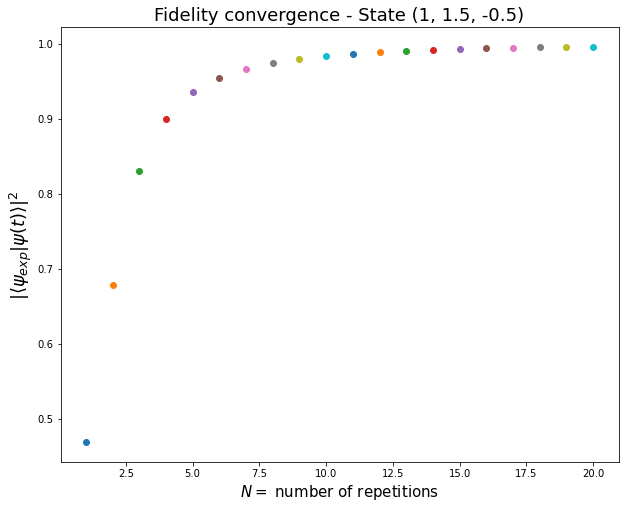

In [12]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
for N in range(1,21):
    # Parameter time/N inside Trotter 
    th=t/N

    qr=QuantumRegister(3,'q')
    Tc=QuantumCircuit(qr)
    # Factor 2 because inside Rxx, Ryy and Rzz the parameter is divided by 2
    Tc.rxx(2*th,0,1)
    Tc.ryy(2*th,0,1)
    Tc.rzz(2*th,0,1)
    Tc.rxx(2*th,1,2)
    Tc.ryy(2*th,1,2)
    Tc.rzz(2*th,1,2)
    Tc.rxx(2*th,0,2)
    Tc.ryy(2*th,0,2)
    Tc.rzz(2*th,0,2)
    TrotterGate=Tc.to_gate(label="Trotter/N")
    if N==1:
        display(Markdown(r"Quantum circuit associate with $e^{-i\frac{t}{N}H}$"))
        print(Tc.draw())
        
    
    qc=QuantumCircuit(qr)
    for i in range(N):
        qc.append(TrotterGate,[0,1,2])
    
    # Algebrical product of the matrix associated with the circuit and initial state 
    psi_ev=np.dot(Operator(qc).data,psi0)
    #print(psi_ev)

    psit=[]
    for el in psi_ev:
        psit.append(np.sqrt(np.real(el)**2+np.imag(el)**2))
    print("N=",N," - | psi(t) > = ",to_ket(psit))
    #print(to_state(psit))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(psit))
    fid=np.conjugate(int_prod)*int_prod
    print("|< ideal | psi(t) >|^2 = ",fid,"\n")
    
    #Plot
    plt.scatter(N,fid)
    plt.title("Fidelity convergence - State "+str(lab_list[5]),fontsize=18)
    plt.xlabel(r"$N =$ number of repetitions",fontsize=15)
    plt.ylabel(r"$|\langle \psi_{exp}|\psi(t) \rangle |^2$",fontsize=18)

By increasing the number of repetitions we see the convergence of the fidelity value to the expected result.

### $|s_L=1,s=3/2,s_z=1/2\rangle$ case

If we follow the same line of reasoning shown above we find that we have to start from:

$$|\psi(0) \rangle = \frac{1}{\sqrt{2}} \Bigl(|\uparrow \downarrow \rangle_{01} + |\downarrow \uparrow  \rangle_{01} \Bigr) |\uparrow \rangle_2 =  |s=1,s_z=0 \rangle_{01} |s=1/2,s_z=1/2 \rangle_2$$

This time the evolved state will be:

$$|\psi(t) \rangle = c_1(t) |s_L=1,s=3/2,s_z=1/2 \rangle + c_2(t) |s_L=1,s=1/2,s_z=1/2 \rangle$$

And again we need $c_1(t)=1$ and $c_2(t)=0$. The desired time will be:

$$t=\frac{4}{3}\arccos{\biggl( \frac{1}{2}\sqrt{\frac{2s+1}{s+s_z+1}} \biggr)}$$

where this time $s=1$ and $s_z=0$.

In [13]:
# Initial states psi(0)
display(Markdown(r"Initial state $\psi(0)$"))
psi0=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
print(psi0)

# Evolution time
t=(4/3)*np.arccos(0.5*np.sqrt(3/2))
print("Evolution time: ",t)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]
Evolution time:  1.2156510546246502


#### `HamiltonianGate` function

In [14]:
H_ev=HamiltonianGate(H,t)
mat_H_ev=H_ev.to_matrix()
psi_ev=np.dot(mat_H_ev,psi0)
#print(psi_ev)

psit=[]
for el in psi_ev:
    psit.append(np.sqrt(np.real(el)**2+np.imag(el)**2))
print("| psi(t) > = ",to_ket(psit))
#print(to_state(psit))
print("< ideal | psi(t) > = ",np.dot(np.conjugate(eig_3spins[6]),to_state(psit)))

| psi(t) > =   + (0.629) |100⟩ + (0.629) |010⟩ + (0.456) |001⟩
< ideal | psi(t) > =  0.9900062956041438


### Trotter decomposition
#### -Manual decomposition

Figure(808.997x204.68)
N= 1 , | psi(t) > =   + (0.365) |100⟩ + (0.536) |010⟩ + (0.761) |001⟩
|< ideal | psi(t) >|^2 =  0.9211811040069966 

N= 2 , | psi(t) > =   + (0.206) |100⟩ + (0.824) |010⟩ + (0.527) |001⟩
|< ideal | psi(t) >|^2 =  0.8089297061447124 

N= 3 , | psi(t) > =   + (0.218) |100⟩ + (0.921) |010⟩ + (0.323) |001⟩
|< ideal | psi(t) >|^2 =  0.7120963210260547 

N= 4 , | psi(t) > =   + (0.264) |100⟩ + (0.925) |010⟩ + (0.274) |001⟩
|< ideal | psi(t) >|^2 =  0.7133824501319598 

N= 5 , | psi(t) > =   + (0.310) |100⟩ + (0.903) |010⟩ + (0.297) |001⟩
|< ideal | psi(t) >|^2 =  0.7605313622402875 

N= 6 , | psi(t) > =   + (0.351) |100⟩ + (0.877) |010⟩ + (0.329) |001⟩
|< ideal | psi(t) >|^2 =  0.8077556184324467 

N= 7 , | psi(t) > =   + (0.385) |100⟩ + (0.852) |010⟩ + (0.355) |001⟩
|< ideal | psi(t) >|^2 =  0.8448095703152507 

N= 8 , | psi(t) > =   + (0.412) |100⟩ + (0.830) |010⟩ + (0.375) |001⟩
|< ideal | psi(t) >|^2 =  0.8724825648323441 

N= 9 , | psi(t) > =   + (0.435) |100⟩ + (

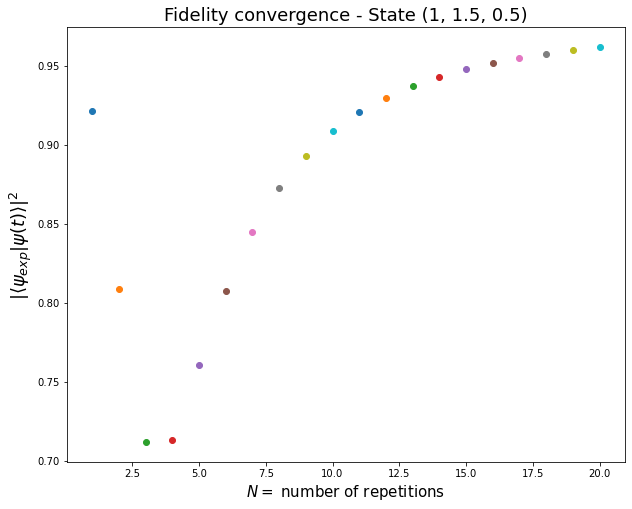

In [15]:
plt.figure(figsize=(10,8))
for N in range(1,21):
    # Parameter time/N inside Trotter 
    th=t/N

    qr=QuantumRegister(3,'q')
    Tc=QuantumCircuit(qr)
    # Factor 2 because inside Rxx, Ryy and Rzz the parameter is divided by 2
    Tc.rxx(2*th,0,1)
    Tc.ryy(2*th,0,1)
    Tc.rzz(2*th,0,1)
    Tc.rxx(2*th,1,2)
    Tc.ryy(2*th,1,2)
    Tc.rzz(2*th,1,2)
    Tc.rxx(2*th,0,2)
    Tc.ryy(2*th,0,2)
    Tc.rzz(2*th,0,2)
    TrotterGate=Tc.to_gate(label="Trotter/N")
    if N==1:
        print(Tc.draw('mpl'))
    
    qc=QuantumCircuit(qr)
    for i in range(N):
        qc.append(TrotterGate,[0,1,2])

    psi_ev=np.dot(Operator(qc).data,psi0)
    #print(psi_ev)

    psit=[]
    for el in psi_ev:
        psit.append(np.sqrt(np.real(el)**2+np.imag(el)**2))
    print("N=",N,", | psi(t) > = ",to_ket(psit))
    #print(to_state(psit))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(psit))
    fid=np.conjugate(int_prod)*int_prod
    print("|< ideal | psi(t) >|^2 = ",fid,"\n")
    
    #Plot
    plt.scatter(N,fid)
    plt.title("Fidelity convergence - State "+str(lab_list[6]),fontsize=18)
    plt.xlabel(r"$N =$ number of repetitions",fontsize=15)
    plt.ylabel(r"$|\langle \psi_{exp}|\psi(t) \rangle |^2$",fontsize=18)

**Question**
- How to transpile the circuit more efficiently?
- Could this idea lead to other ways of finding total spin eigenfunctions? Yes, see next chapter.

# VQE based on time evolution circuit

We start from the idea of the "trotterization" of the circuit used for time evolution method to create a VQE algorithm. 

The ansatz of the algorithm is composed by:
- variational form $\rightarrow$ the circuit associated with $e^{-i H \frac{t}{N}}$ where $N=1$ and $\epsilon = t/N$ is the **variational parameter** 
- initial state $\rightarrow$ the state $|\psi(0) \rangle$ of time evolution of the circuit

By increasing the depth of this circuit we approach the limit of $N \rightarrow +\infty$ of the Trotter theorem.

**Simplification** We can make the following observation:

$$H=\sum_{i<j}^{n-1} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j = \sum_{i<j}^{n-2} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_j + \sum_{i=0}^{n-2} \mathbf{\hat{S}}_i  \cdot\mathbf{\hat{S}}_{n-1} = H_0 + \sum_{i=0}^{n-2} V_i$$

and 

$$e^{-i \epsilon H} \simeq \biggl( \prod_{i=0}^{n-1} e^{-i \epsilon V_i} \biggr) e^{-i \epsilon H_0} .$$

When the depth of the circuit is equal to $1$, we can consider only the terms with $V_i$ inside the circuit because $e^{-i \epsilon H_0}$ is just a phase for the $(n-1)$ qubits. In the case of $3$ spins those terms are:

$$V_0=\mathbf{\hat{S}}_0  \cdot \mathbf{\hat{S}}_2 \quad V_1=\mathbf{\hat{S}}_1  \cdot\mathbf{\hat{S}}_2$$

<img src="Pictures/Time_ev_simpl.jpg" width="700">

#### Definition of the "time evolution" variational form

- `EvolVarForm` $\rightarrow$ **1 parameter overall** (even with more repetitions)
- `EvolVarForm2`  $\rightarrow$ **1 parameter for each repetition**
- `EvolVarForm3`  $\rightarrow$ **1 parameter for each gate**
- `EvolVarForm4`  $\rightarrow$ **1 parameter for the gates with the same connectivity**
- `EvolVarForm5`  $\rightarrow$ **1 parameter for** $R_{xx}$ **gates, 1 for** $R_{yy}$ **gates, 1 for** $R_{zz}$

In [8]:
from  typing import List, Optional, Union
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import InitialState

# 1 parameter overall, besides the repetitions
class EvolVarForm(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        self._num_parameters = 1 
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[0],i,j)
                        circuit.ryy(2*parameters[0],i,j)
                        circuit.rzz(2*parameters[0],i,j)
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[0],i,j)
                    circuit.ryy(2*parameters[0],i,j)
                    circuit.rzz(2*parameters[0],i,j)
        return circuit
    
# 1 parameter for each repetition    
class EvolVarForm2(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        self._num_parameters = self._reps           # <--- Here the difference 
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[l],i,j)
                        circuit.ryy(2*parameters[l],i,j)
                        circuit.rzz(2*parameters[l],i,j)
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[l],i,j)
                    circuit.ryy(2*parameters[l],i,j)
                    circuit.rzz(2*parameters[l],i,j)
        return circuit
    
# 1 parameter for each gate    
class EvolVarForm3(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        if reps==1:
            self._num_parameters = 6  
        else:
            self._num_parameters = 6  + (self._reps-1)*3*len(self._connections)
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c counts blocks of 3 gates
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[3*c+0],i,j)
                        circuit.ryy(2*parameters[3*c+1],i,j)
                        circuit.rzz(2*parameters[3*c+2],i,j)
                        c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[3*c+0],i,j)
                    circuit.ryy(2*parameters[3*c+1],i,j)
                    circuit.rzz(2*parameters[3*c+2],i,j)
                    c+=1
        return circuit
    
# 1 parameter for each block of rotations (gates with the same connectivity)  
class EvolVarForm4(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        if reps==1:
            self._num_parameters = 2  
        else:
            self._num_parameters = 2  + (self._reps-1)*len(self._connections)
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c counts blocks of 3 gates
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[c],i,j)
                        circuit.ryy(2*parameters[c],i,j)
                        circuit.rzz(2*parameters[c],i,j)
                        c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[c],i,j)
                    circuit.ryy(2*parameters[c],i,j)
                    circuit.rzz(2*parameters[c],i,j)
                    c+=1
        return circuit
     
# 1 parameter for R_xx gates, 1 for R_yy and 1 for R_zz 
class EvolVarForm5(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        self._num_parameters = self._reps*3
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c count the repetitions
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[3*c+0],i,j)
                        circuit.ryy(2*parameters[3*c+1],i,j)
                        circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[3*c+0],i,j)
                    circuit.ryy(2*parameters[3*c+1],i,j)
                    circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
        return circuit

In [9]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin


**Remark** In all the following optimization circuits we are going to see how the cost function evolves by increasing the depth of the circuit. In each step of the optimization we will have a fixed number of repetitions and this optimization will start from the optimal parameters of the previous step.

## $| s_L=1,s=3/2,s_z=-1/2 \rangle$ ($1$st Dicke state)

### `EvolVarForm` ($1$ parameter overall)

In [8]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm(num_qubits=3,reps=1,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=1))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of the circuit

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[0]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above. The optimization associated with a specific number of repetitions starts from the best parameters of the previous optimization.

We notice that we use the `Gradient` class with the **parameter shift** method.

In [13]:
from qiskit.aqua.operators.gradients import Gradient


# Definition of the gradient function 
grad = Gradient(grad_method='param_shift')

min_val=[]
for r in range(1,20):
    print("Repetitions: ",r)
    var_form  = EvolVarForm(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,-0.5)
        return val

    # Alternative optimizer: L_BFGS_B(maxiter=10000,epsilon=1e-12)
    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        min_val.append(algo.find_minimum(initial_point=min_val[r-2]["optimal_point"],cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
        

2021-04-20 12:38:48,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea6db091c0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea6db093d0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm object at 0x7fea6db09490>
-- var_form_params: θ, ['θ[0]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 0
Variational For

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-20 12:38:49,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea6aa4f2b0>
-- 

Repetitions:  2


2021-04-20 12:38:50,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea6db13340>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea6db09670>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm object at 0x7fea6db13790>
-- var_form_params: θ, ['θ[0]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 0
Variational For

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, ta

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anac

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-20 12:39:08,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea6da92d60>
-- 

Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 0] = -dc ** 3
/Users/Alecoal/opt/anaconda

Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  10


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  11


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  12


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  13


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  14


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  15


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  16


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  17


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  18


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  19


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

In [16]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,20):
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    #print("Optimal parameter: ",opt_pnt[r-1][0])
    #best_circ=var_form.assign_parameters(opt_pnt[r-1])        # To use with RealAmplitudes or TwoLocal
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  4.000000000613553
| optimal state > =  + (-0.520) |110⟩ + (0.559) |101⟩ + (0.646) |011⟩
|< ideal | optimal >|^2 =  0.15645162919820674 

Depth =  2
Optimal cost:  4.000000000371182
| optimal state > =  + (-0.399) |110⟩ + (0.628) |101⟩ + (0.668) |011⟩
|< ideal | optimal >|^2 =  0.2682363336000901 

Depth =  3
Optimal cost:  (4.000000001617809-4.440892098500631e-16j)
| optimal state > =  + (-0.412) |110⟩ + (0.625) |101⟩ + (0.663) |011⟩
|< ideal | optimal >|^2 =  0.25582782622773653 

Depth =  4
Optimal cost:  4.0000000000000036
| optimal state > =  + (0.991) |110⟩ + (-0.097) |101⟩ + (-0.097) |011⟩
|< ideal | optimal >|^2 =  0.21181513442219685 

Depth =  5
Optimal cost:  4.000000000000014
| optimal state > =  + (0.991) |110⟩ + (-0.097) |101⟩ + (-0.097) |011⟩
|< ideal | optimal >|^2 =  0.21181513030919838 

Depth =  6
Optimal cost:  4.000000000000001
| optimal state > =  + (0.991) |110⟩ + (-0.097) |101⟩ + (-0.097) |011⟩
|< ideal | optimal >|^2 =  0.21180467257724

Number of parameters: 1


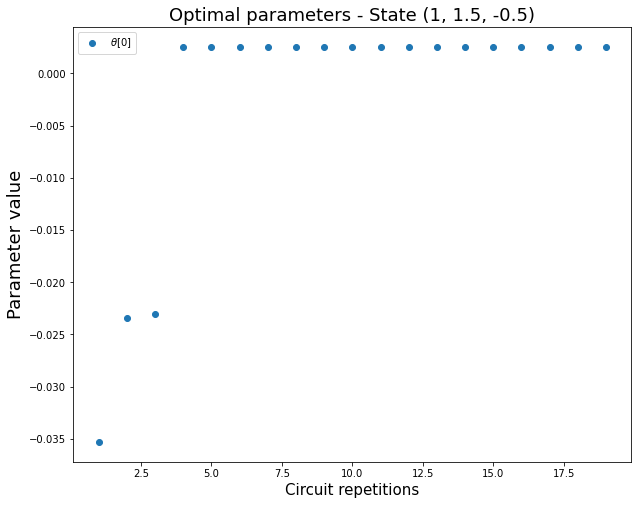

In [20]:
print("Number of parameters:", var_form.num_parameters)
opt_param=[[] for i in range(var_form.num_parameters)]
for el in opt_pnt:
    for i in range(len(el)):
        opt_param[i].append(el[i])

plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_param):
    plt.scatter(np.arange(1,20),el,label=r"$\theta$["+str(iel)+"]")
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

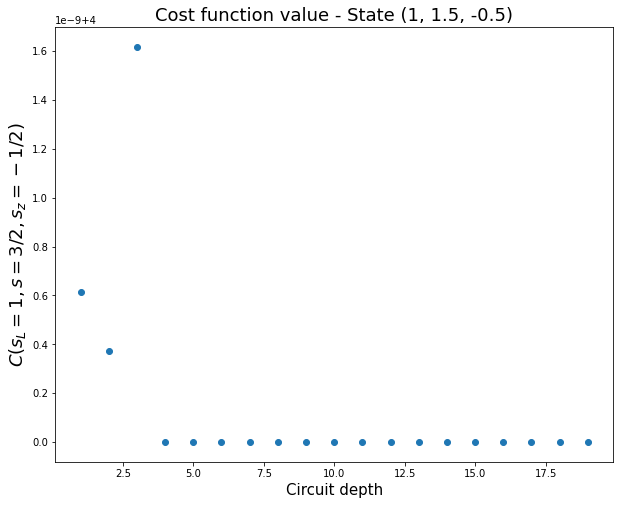

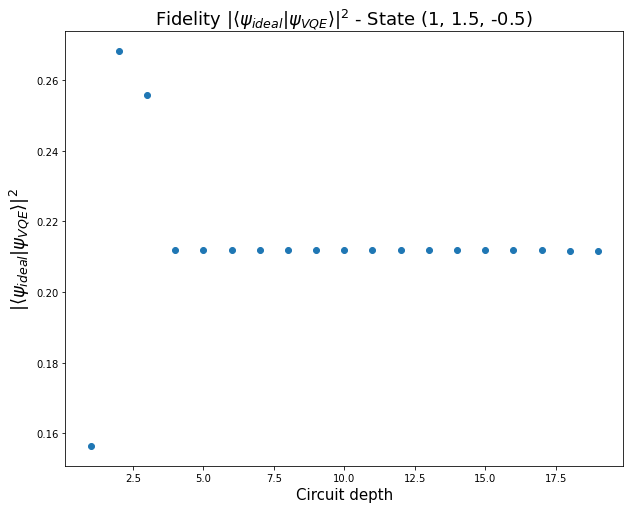

In [21]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,20),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,20),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### `EvolVarForm2`  ($1$ parameter  for each repetition)

In [10]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm2(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=2))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of the circuit

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[0]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above. The optimization associated with a specific number of repetitions starts from the best parameters of the previous optimization.

We notice that we use the `Gradient` class with the **parameter shift** method.

In [11]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the gradient function 
grad = Gradient(grad_method='param_shift')

min_val=[]
for r in range(1,20):
    print("Repetitions: ",r)
    var_form  = EvolVarForm2(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,-0.5)
        return val

    # L_BFGS_B(maxiter=10000,epsilon=1e-12)
    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add one parameter (equal to 0) because EvolVarForm2 has 1 parameter for each repetition
        opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-22 11:10:09,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faacdca2250>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7faacdcec2b0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm2 object at 0x7faacdcec070>
-- var_form_params: θ, ['θ[0]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 0
Variational Fo

Repetitions:  1


NameError: name 'spin_cost' is not defined

In [38]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,20):
    var_form  = EvolVarForm2(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  (4.000000000009753+1.1102230246251575e-16j)
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785886040894779 

Depth =  2
Optimal cost:  4.000000000009751
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785896930288067 

Depth =  3
Optimal cost:  (4.000000000009753+0j)
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785896930288066 

Depth =  4
Optimal cost:  (4.000000000009758+0j)
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785896930288065 

Depth =  5
Optimal cost:  4.0000000000097575
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785900140957326 

Depth =  6
Optimal cost:  4.000000000009765
| optimal state > =  + (0.998) |110⟩ + (-0.042) |101⟩ + (-0.042) |011⟩
|< ideal | optimal >|^2 =  0.2785

No handles with labels found to put in legend.


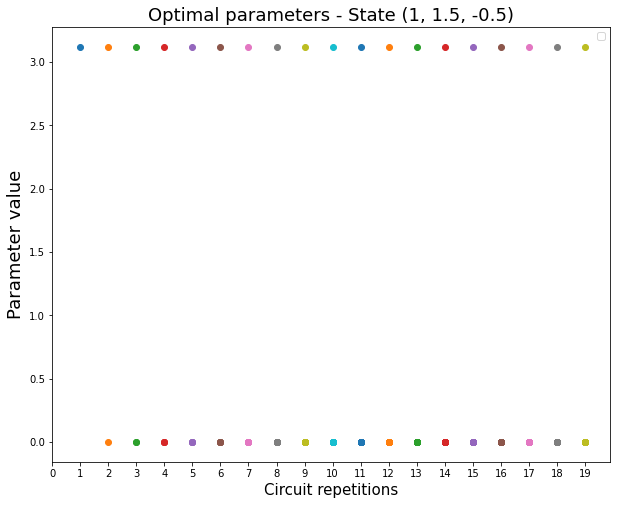

In [43]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(20))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

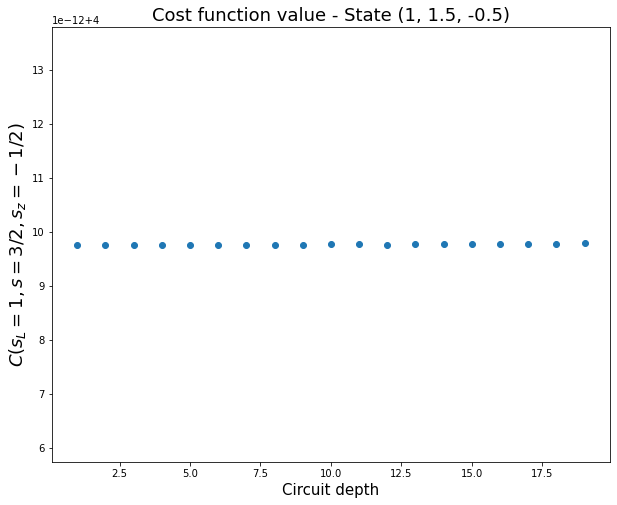

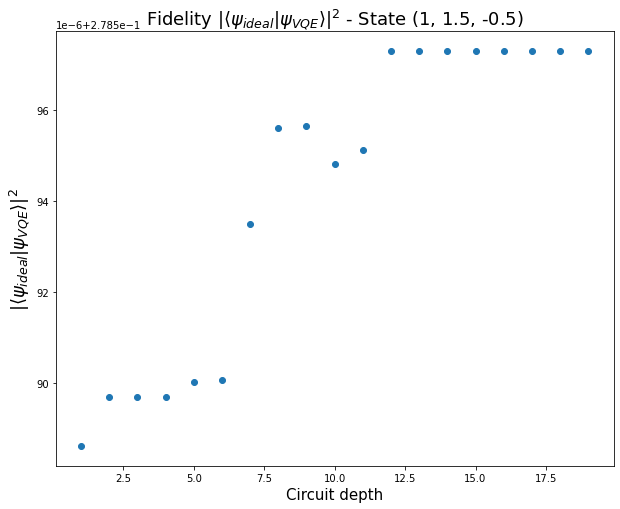

In [44]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,20),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,20),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### `EvolVarForm3`  ($1$ parameter  for each gate)

In [17]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm3(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=15))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of the circuit

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

In [18]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,-0.5)
        return val

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 9 parameters (equal to 0) because EvolVarForm3 has 1 parameter for each gate
        for j in range(9):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-22 11:16:32,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faace197bb0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7faace2dd0a0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm3 object at 0x7faace2ddee0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_opera

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-22 11:17:12,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faacdb76550>
-- 

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-22 11:19:13,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faacde185b0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7faacdb3a3a0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm3 object at 0x7faacdd0

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-22 11:22:17,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-22 11:25:12,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

2021-04-22 11:30:22,213:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-22 11:37:30,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

2021-04-22 11:37:30,227:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

2021-04-22 11:47:03,702:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


In [20]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  0.8000001680503717
| optimal state > = (0.447) |000⟩ + (-0.020) |110⟩ + (-0.632) |101⟩ + (-0.632) |011⟩
|< ideal | optimal >|^2 =  0.550175826911656 

Depth =  2
Optimal cost:  1.2303671521803975e-18
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999993634967 

Depth =  3
Optimal cost:  (1.23037280148456e-18+4.0810141209798604e-25j)
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999993634958 

Depth =  4
Optimal cost:  (1.2303771663267918e-18+0j)
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999993634947 

Depth =  5
Optimal cost:  (1.2303784712682789e-18-1.0213480747509592e-26j)
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999993634945 

Depth =  6
Optimal cost:  (1.2303809294170904e-18+0j)
| optimal state > =  + (-0.577) |110⟩ 

No handles with labels found to put in legend.


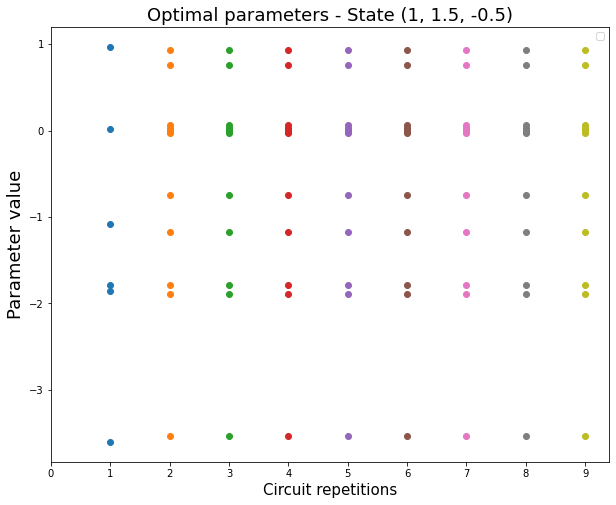

In [21]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

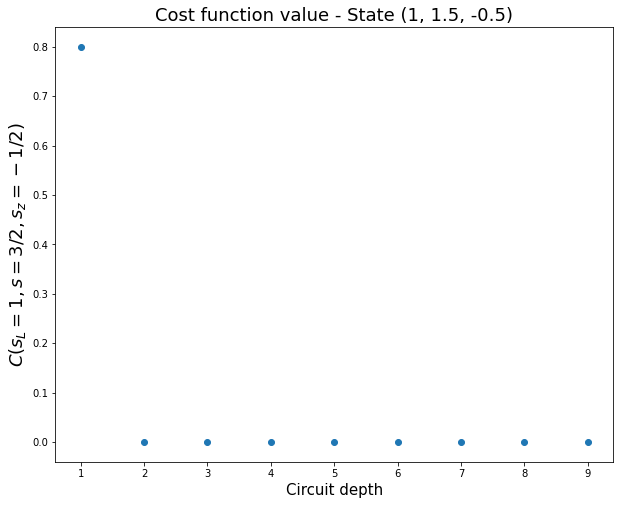

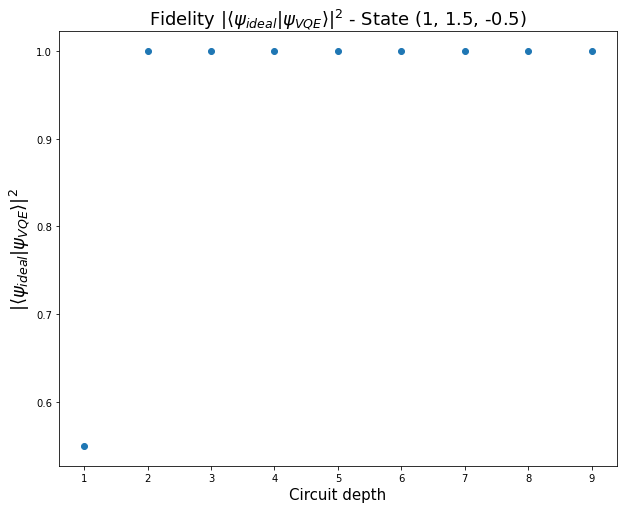

In [22]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### `EvolVarForm4`  ($1$ parameter  for gates with the same connectivity )

In [23]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm4(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=5))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of the circuit

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[0]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

In [24]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm4(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,-0.5)
        return val

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 3 parameters (equal to 0) 
        for j in range(3):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-22 12:17:35,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faacdd806a0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7faacee6df10>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm4 object at 0x7faacdb8aac0>
-- var_form_params: θ, ['θ[0]', 'θ[1]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 0
Variat

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-22 12:17:41,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-22 12:17:49,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faacdb31d00>
-- 

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-22 12:18:21,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faac6aee400>
-- 

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-22 12:18:28,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faace68fc40>
-- 

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

In [25]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm4(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  (4.000000000086142-1.1102230246251565e-16j)
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.029) |011⟩
|< ideal | optimal >|^2 =  0.2929450210027299 

Depth =  2
Optimal cost:  (4.0000000000861435+1.1102204485632045e-16j)
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.029) |011⟩
|< ideal | optimal >|^2 =  0.29294502100273 

Depth =  3
Optimal cost:  4.0000000000861435
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.029) |011⟩
|< ideal | optimal >|^2 =  0.2929450677579356 

Depth =  4
Optimal cost:  4.000000000010437
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.030) |011⟩
|< ideal | optimal >|^2 =  0.29285655391593307 

Depth =  5
Optimal cost:  4.000000000010446
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.030) |011⟩
|< ideal | optimal >|^2 =  0.292856553841207 

Depth =  6
Optimal cost:  4.000000000010387
| optimal state > =  + (0.999) |110⟩ + (-0.032) |101⟩ + (-0.030) |011⟩
|< ideal | optimal

No handles with labels found to put in legend.


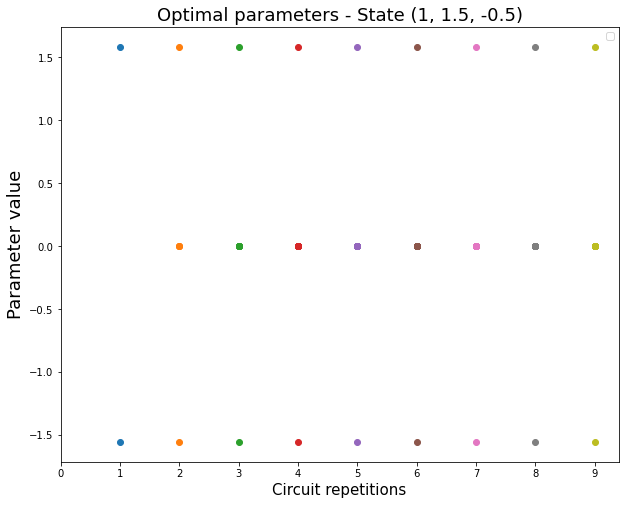

In [26]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

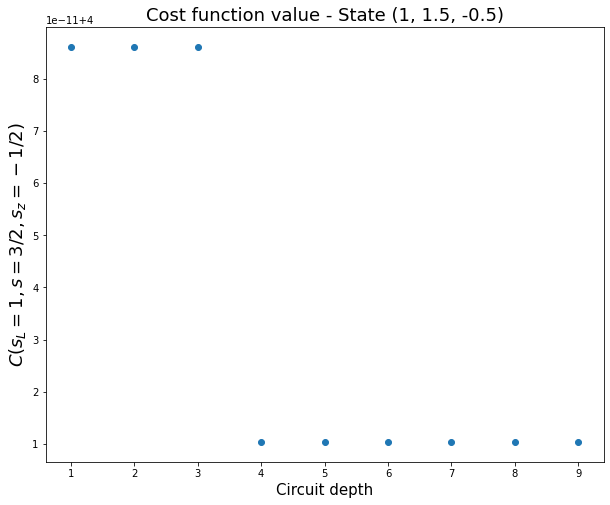

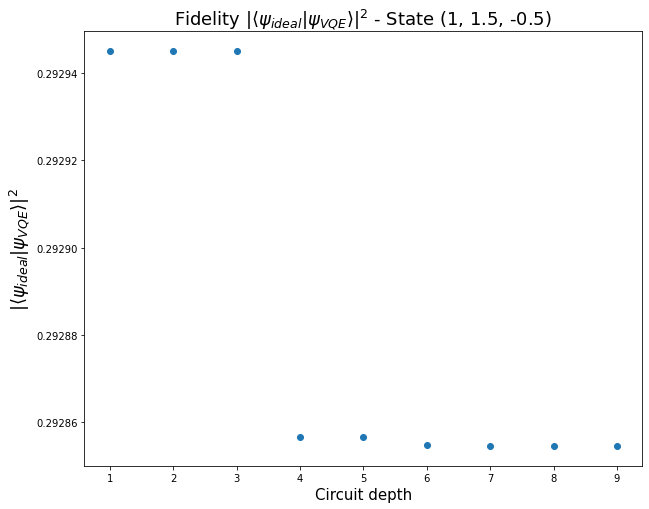

In [27]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### `EvolVarForm5`  ($1$ parameter  for $R_{xx}$, $1$ for  $R_{yy}$, $1$ for $R_{zz}$)

In [28]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,-1)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=6))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0. 0. 0. 1. 0. 0. 0. 0.]


Example of the circuit

     ┌────────────┐                        ┌───┐┌─────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_1: ┤ U(π/2,0,0) ├┤ X ├┤ U(π/2,0,0) ├┤ X ├──■───────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                      │  »
q_2: ────────────────■──────────────────■────────────────────────■──»
                                                                    »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ─────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                         │  │              ││              │»
«q_2: ────────────────────────────────────■──┤1             ├┤1             ├»
«                                   

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

In [29]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,-0.5)
        return val

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 3 parameters (equal to 0) 
        for j in range(3):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-22 12:27:25,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7faace706f10>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7faace706fd0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm5 object at 0x7faacdd019a0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-22 12:29:02,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anac

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Castin

In [30]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[5]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  (0.8205025513295473-6.999595756048196e-17j)
| optimal state > = (0.458) |000⟩ + (-0.395) |110⟩ + (-0.489) |101⟩ + (-0.628) |011⟩
|< ideal | optimal >|^2 =  0.7625934299223216 

Depth =  2
Optimal cost:  2.1020618622414907e-07
| optimal state > = (0.012) |000⟩ + (-0.579) |110⟩ + (-0.575) |101⟩ + (-0.578) |011⟩
|< ideal | optimal >|^2 =  0.9998483624379305 

Depth =  3
Optimal cost:  1.1604227275895882e-16
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999970334179 

Depth =  4
Optimal cost:  9.989871365050525e-17
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999966121571 

Depth =  5
Optimal cost:  9.285121738807702e-17
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (-0.577) |011⟩
|< ideal | optimal >|^2 =  0.9999999972827673 

Depth =  6
Optimal cost:  (9.28512538555939e-17+0j)
| optimal state > =  + (-0.577) |110⟩ + (-0.577) |101⟩ + (

No handles with labels found to put in legend.


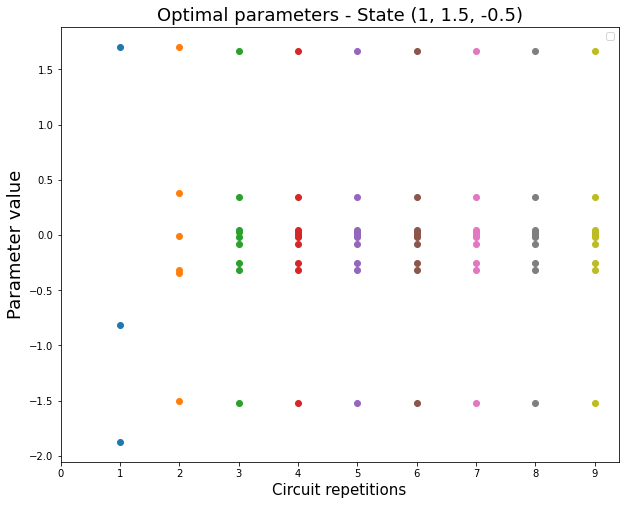

In [31]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

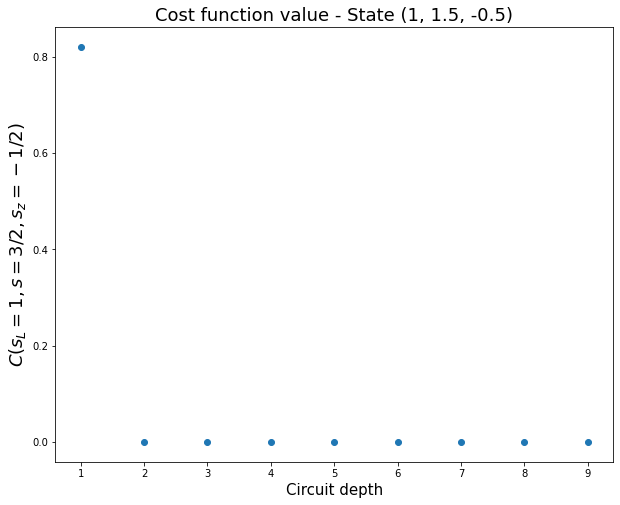

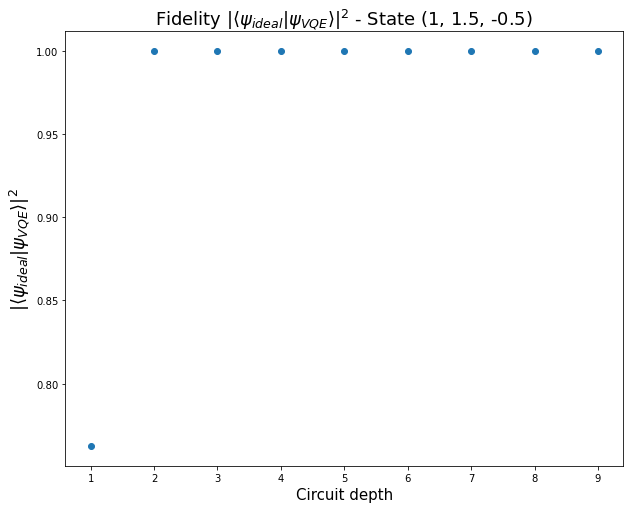

In [32]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

## $| s_L=1,s=3/2,s_z=1/2 \rangle$ ($2$nd Dicke state)

From the previous analysis we understood that the `EvolVarForm3` and `EvolVarForm5` are the best variational forms in terms of fidelity results. We know use those two to study the second Dicke state.

### `EvolVarForm3` ($1$ parameter  for each gate)

In [11]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm3(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of circuit with parameter equal to $\pi$"))
circ=var_form.construct_circuit(ParameterVector('θ', length=15))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]


Example of circuit with parameter equal to $\pi$

     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                        │  │              ││              │»
«q_2: ───────────────────────────────────■──┤1             ├┤1             ├»
«                                           └────

### A) Repetition optimization starts from best parameters of the previous one

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

We notice that we are not using the `Gradient` method, but only the default finite differences to compute the derivatives.

In [12]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,0.5)
        return val

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 9 parameters (equal to 0) because EvolVarForm3 has 1 parameter for each gate
        for j in range(9):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-25 11:15:40,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea063f2940>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea0d5e8bb0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm3 object at 0x7fea0d5e8b50>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_opera

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-25 11:16:03,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d941b50>
-- 

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anac

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 11:18:35,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 11:21:18,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginar

2021-04-25 11:23:42,576:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 11:25:03,775:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

2021-04-25 11:25:03,777:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginar

2021-04-25 11:30:07,883:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 11:34:46,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

2021-04-25 11:34:46,075:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


In [13]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  0.006792704155374209
| optimal state > =  + (0.500) |100⟩ + (0.501) |010⟩ + (0.698) |001⟩ + (-0.106) |111⟩
|< ideal | optimal >|^2 =  0.962744196141205 

Depth =  2
Optimal cost:  4.07627610540403e-17
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999963720132 

Depth =  3
Optimal cost:  8.791200114161852e-19
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999994857165 

Depth =  4
Optimal cost:  (8.791214803095924e-19+2.1552320880123535e-25j)
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.999999999485716 

Depth =  5
Optimal cost:  (8.791234672655822e-19+2.5265163755875433e-25j)
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999994857158 

Depth =  6
Optimal cost:  (8.791260274085128e-19-0j)
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0

No handles with labels found to put in legend.


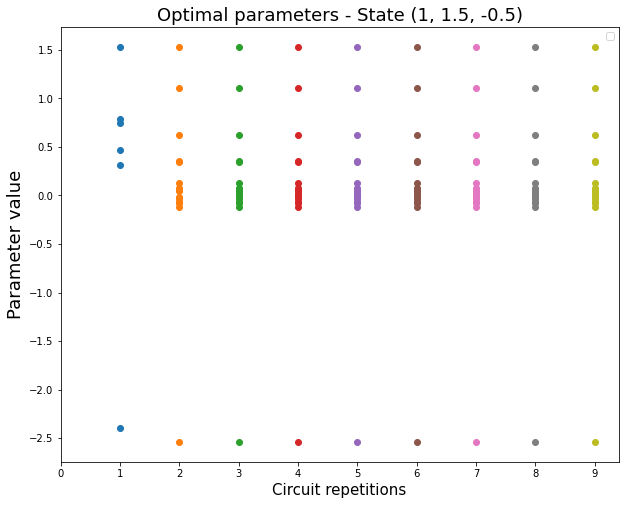

In [14]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

In [15]:
for r in range(1,10):
    print(r," - ",np.round(opt_pnt[r-1],4))
    
'''
param = []
param_pos = [[] for i in range(27)]

for r in range(1,10):
    for iel,el in enumerate(opt_pnt[r-1]):
        if len(param)==0:
            param.append(el)
            param_pos[iel].append(r)
        else:
            for i in range(len(param)):
                if np.round(el,6)!=np.round(param[i],6):
                    param.append(el)
                    param_pos[iel].append(r)

print(param)
print(param_pos)
'''

1  -  [ 0.4681  0.3173  0.7854  0.7471 -2.3943  1.5325]
2  -  [ 0.3513  0.3401  1.1043  0.6269 -2.5395  1.5324  0.0608  0.0785 -0.1154
 -0.0812 -0.0662  0.1267 -0.0157 -0.0312  0.0464]
3  -  [ 0.3512  0.3401  1.1043  0.6269 -2.5395  1.5324  0.0608  0.0785 -0.1154
 -0.0812 -0.0662  0.1267 -0.0157 -0.0312  0.0464  0.      0.     -0.
 -0.     -0.      0.     -0.     -0.      0.    ]
4  -  [ 0.3512  0.3401  1.1043  0.6269 -2.5395  1.5324  0.0608  0.0785 -0.1154
 -0.0812 -0.0662  0.1267 -0.0157 -0.0312  0.0464  0.      0.     -0.
 -0.     -0.      0.     -0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.    ]
5  -  [ 0.3512  0.3401  1.1043  0.6269 -2.5395  1.5324  0.0608  0.0785 -0.1154
 -0.0812 -0.0662  0.1267 -0.0157 -0.0312  0.0464  0.      0.     -0.
 -0.     -0.      0.     -0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.    ]
6  -  [ 0.3512

'\nparam = []\nparam_pos = [[] for i in range(27)]\n\nfor r in range(1,10):\n    for iel,el in enumerate(opt_pnt[r-1]):\n        if len(param)==0:\n            param.append(el)\n            param_pos[iel].append(r)\n        else:\n            for i in range(len(param)):\n                if np.round(el,6)!=np.round(param[i],6):\n                    param.append(el)\n                    param_pos[iel].append(r)\n\nprint(param)\nprint(param_pos)\n'

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

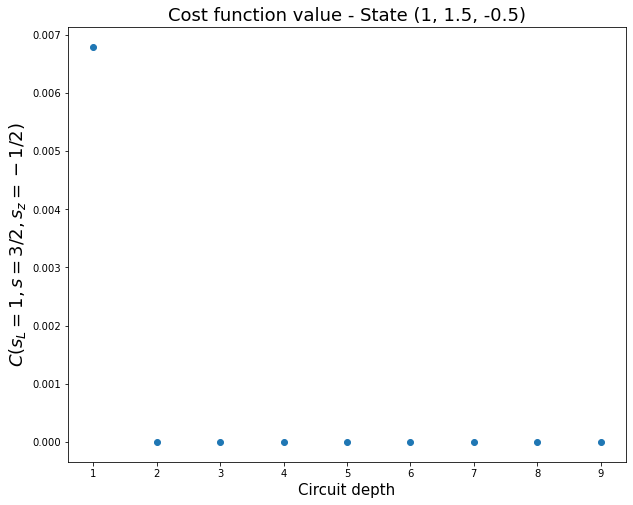

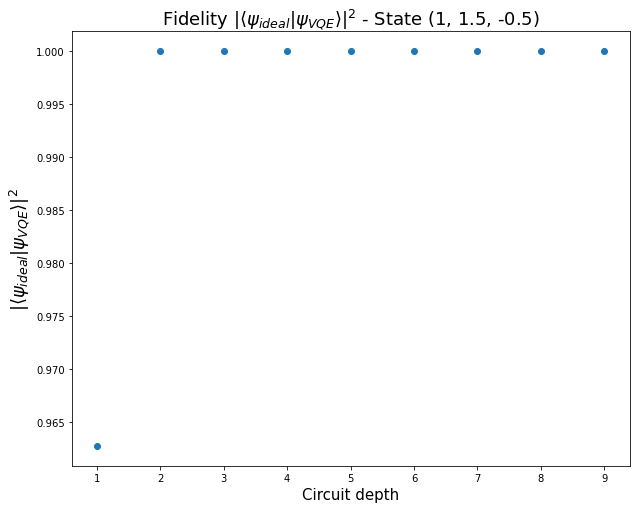

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### B) Normal optimization

In [17]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,0.5)
        return val


    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
   

2021-04-25 11:41:22,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d789ca0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea0d43b7f0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm3 object at 0x7fea0d4375b0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_opera

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-25 11:41:51,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d847580>
-- 

Repetitions:  2


2021-04-25 11:43:03,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d792a00>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea0d792400>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm3 object at 0x7fea0d792bb0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]', 'θ[17]', 'θ[18]', '

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 11:57:55,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 12:07:17,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

2021-04-25 12:07:17,006:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

2021-04-25 12:23:27,631:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

2021-04-25 12:39:13,514:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.


Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

In [18]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm3(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  0.006792699340298353
| optimal state > =  + (0.500) |100⟩ + (0.501) |010⟩ + (0.698) |001⟩ + (0.106) |111⟩
|< ideal | optimal >|^2 =  0.9626995391819807 

Depth =  2
Optimal cost:  5.937436824664385e-18
| optimal state > =  + (-0.577) |100⟩ + (-0.577) |010⟩ + (-0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999994023892 

Depth =  3
Optimal cost:  6.734196798894992e-19
| optimal state > =  + (-0.577) |100⟩ + (-0.577) |010⟩ + (-0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999996665825 

Depth =  4
Optimal cost:  1.3529462258578777e-17
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999983009529 

Depth =  5
Optimal cost:  8.705382251570636e-18
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999987520627 

Depth =  6
Optimal cost:  5.577719931043234e-19
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999

No handles with labels found to put in legend.


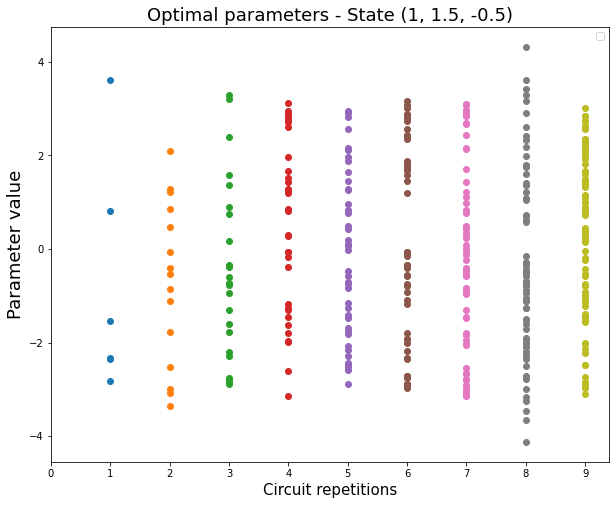

In [19]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

In [20]:
for r in range(1,10):
    print(r," - ",np.round(opt_pnt[r-1],4))
    
'''
param = []
param_pos = [[] for i in range(27)]

for r in range(1,10):
    for iel,el in enumerate(opt_pnt[r-1]):
        if len(param)==0:
            param.append(el)
            param_pos[iel].append(r)
        else:
            for i in range(len(param)):
                if np.round(el,6)!=np.round(param[i],6):
                    param.append(el)
                    param_pos[iel].append(r)

print(param)
print(param_pos)
'''

1  -  [-2.8243  3.6097 -2.3561  0.8221 -2.3197 -1.5342]
2  -  [ 0.8626 -0.4    -3.0707  1.2223  1.2792 -0.8608 -2.5167  2.0891 -0.0742
 -2.9959  0.4763 -1.1062 -0.5246 -3.3496 -1.774 ]
3  -  [-2.2976  1.3575 -0.9306 -2.8327  2.3854 -1.2998  0.8943 -2.7611  0.165
  3.2812 -0.3515 -2.8946  1.5825 -1.783  -0.5973 -2.2075  0.7481  3.2141
 -0.7608 -2.7741 -0.3881 -1.6005 -0.7183 -2.8203]
4  -  [-1.2983  2.892   2.7165  1.2662 -1.2656  2.7521 -3.1353  3.117   2.598
  1.4254  0.865  -0.0743  1.9663  1.5172  1.6771 -0.1786  2.8945 -1.1743
  0.8112 -0.3892  0.2802 -1.4479  2.8229 -1.9944 -0.0601  1.2776 -1.9623
  0.3067 -2.6115 -1.6332 -1.7897  1.1926  2.9457]
5  -  [-2.2798  0.1035 -0.5775  0.7639  2.1508 -2.1485  2.5629  0.0711  0.4825
 -2.8865  2.9043  1.4538  1.8876  2.1242 -0.742  -0.4617 -1.4802 -2.5258
  1.639  -1.1498  0.4258  1.2554 -2.5952 -2.0742 -2.4551 -1.2715 -0.7099
 -1.4132 -2.4607  0.8263 -1.8225  1.9569 -1.6811  2.8157 -0.0144  2.9433
  0.1906 -2.429  -1.7531 -0.8333  0.9618  

'\nparam = []\nparam_pos = [[] for i in range(27)]\n\nfor r in range(1,10):\n    for iel,el in enumerate(opt_pnt[r-1]):\n        if len(param)==0:\n            param.append(el)\n            param_pos[iel].append(r)\n        else:\n            for i in range(len(param)):\n                if np.round(el,6)!=np.round(param[i],6):\n                    param.append(el)\n                    param_pos[iel].append(r)\n\nprint(param)\nprint(param_pos)\n'

Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

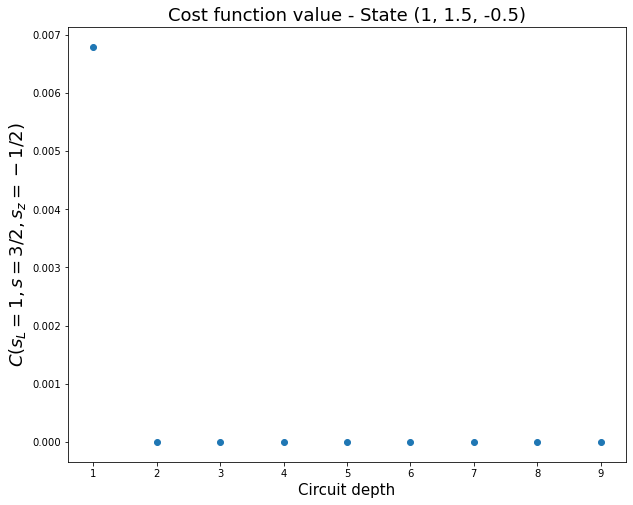

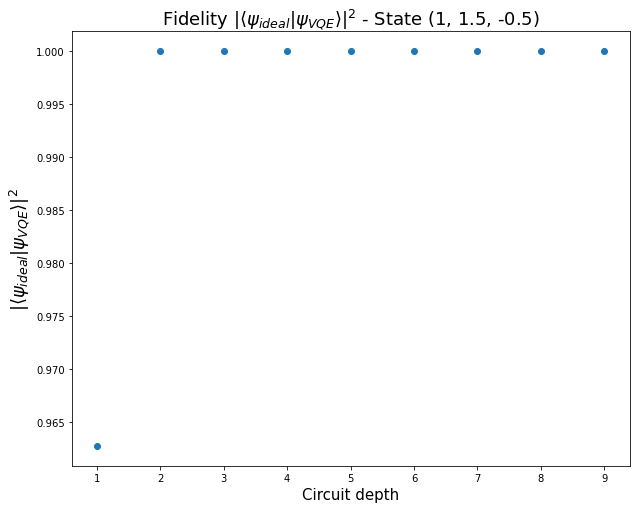

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

### `EvolVarForm5`  ($1$ parameter  for $R_{xx}$, $1$ for  $R_{yy}$, $1$ for $R_{zz}$)

In [22]:
# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=6))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]


Example of the circuit

     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                        │  │              ││              │»
«q_2: ───────────────────────────────────■──┤1             ├┤1             ├»
«                                           └────

### A) Optimization from optimal parameters of the previous one

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

In [23]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,0.5)
        return val

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 3 parameters (equal to 0) 
        for j in range(3):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))

2021-04-25 15:17:53,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d5e8850>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea0d5e81f0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm5 object at 0x7fea0d2cbfd0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary par

Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-25 15:21:50,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d783df0>
-- 

Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

In [24]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  0.11397091119205505
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555132 

Depth =  2
Optimal cost:  0.11397091119205598
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555127 

Depth =  3
Optimal cost:  0.1139709111920569
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555123 

Depth =  4
Optimal cost:  0.11397091119205856
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555114 

Depth =  5
Optimal cost:  (0.11397091119205956-0j)
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555109 

Depth =  6
Optimal cost:  0.11397091119205989
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834470555112 



No handles with labels found to put in legend.


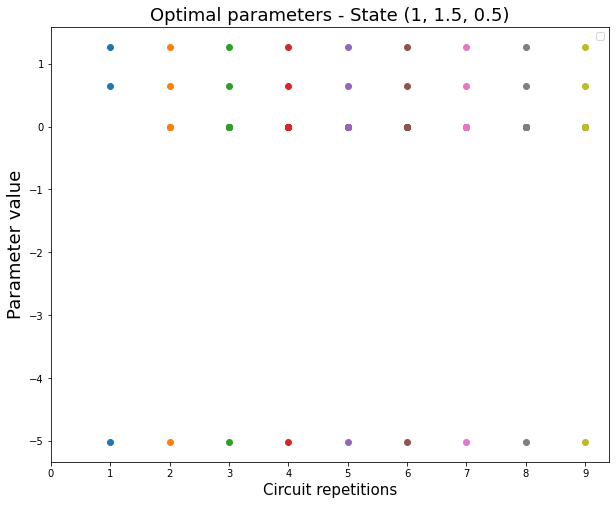

In [25]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
#plt.legend()

In [26]:
for r in range(1,10):
    print(r," - ",np.round(opt_pnt[r-1],4))

1  -  [-5.0136  1.2695  0.6498]
2  -  [-5.0136  1.2695  0.6498 -0.     -0.     -0.    ]
3  -  [-5.0136  1.2695  0.6498 -0.     -0.     -0.     -0.     -0.     -0.    ]
4  -  [-5.0136  1.2695  0.6498  0.      0.      0.      0.      0.      0.
 -0.     -0.     -0.    ]
5  -  [-5.0136  1.2695  0.6498  0.      0.      0.      0.      0.      0.
 -0.     -0.     -0.      0.      0.      0.    ]
6  -  [-5.0136  1.2695  0.6498 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.    ]
7  -  [-5.0136  1.2695  0.6498  0.      0.     -0.     -0.      0.      0.
 -0.     -0.      0.     -0.      0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.    ]
8  -  [-5.0136  1.2695  0.6498  0.      0.     -0.     -0.      0.      0.
 -0.     -0.      0.     -0.      0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.      0.      0.      0.    ]
9  -  [-5.0136  1.2695  0.6498  0.      0.     -0.     -0.      0.      0.
 -0.     -0.      

As we can see in the case of $2$ repetitions, even if we have $6$ different parameters only $3$ are independent.

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

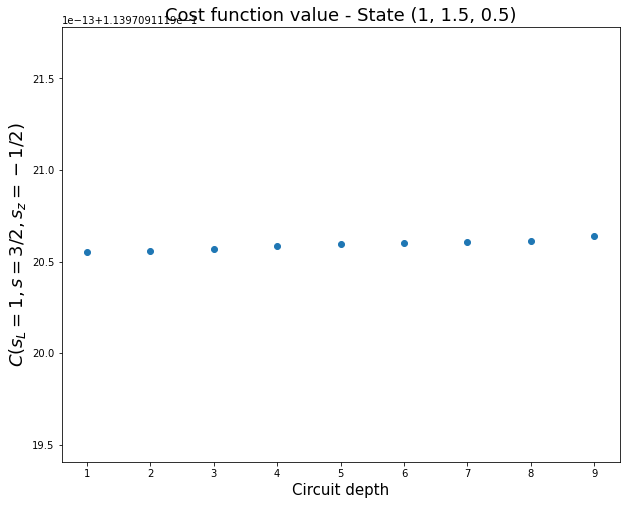

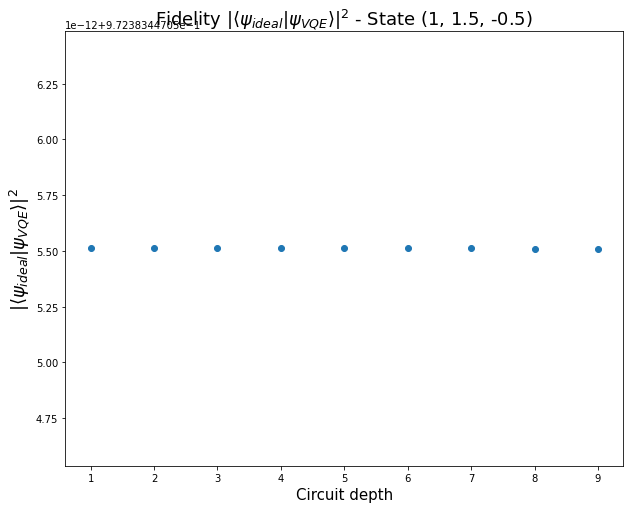

In [27]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

Again, `EvolVarForm5` gives great values of fidelity and it involves less parameters with respect to `EvolvarForm3` under the same number of repetitions. The fidelities are around $97$%.

### B) Normal optimization

In [28]:
from qiskit.aqua.operators.gradients import Gradient

# Definition of the Gradient
grad=Gradient("param_shift")

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
        #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,1,1.5,0.5)
        return val

    
    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad))
    

2021-04-25 15:57:24,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d4527f0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fea0687edf0>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm5 object at 0x7fea0d853d60>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginar

Repetitions:  2


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  3


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  4


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 16:04:07,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  5


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  6


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
2021-04-25 16:13:19,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI

Repetitions:  7


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

Repetitions:  8


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-04-25 16:27:44,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fea0d402640>
-- 

Repetitions:  9


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:500: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:502: ComplexWarning: Casting complex values to real discards the imaginary pa

In [29]:
opt_c   = []
fid     = []
opt_pnt = []
for r in range(1,10):
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    print("Depth = ",r)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    opt_pnt.append(np.real(min_val[r-1]['optimal_point']))
    best_circ = var_form.construct_circuit(opt_pnt[r-1])         # To use with VariationalForm
    best_psi  = CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

Depth =  1
Optimal cost:  0.11397091119205634
| optimal state > =  + (-0.583) |100⟩ + (-0.680) |010⟩ + (-0.446) |001⟩
|< ideal | optimal >|^2 =  0.9723834478033978 

Depth =  2
Optimal cost:  0.008400308278331572
| optimal state > =  + (0.642) |100⟩ + (0.554) |010⟩ + (0.507) |001⟩ + (0.158) |111⟩
|< ideal | optimal >|^2 =  0.9656385031895908 

Depth =  3
Optimal cost:  6.643695107473105e-17
| optimal state > =  + (-0.577) |100⟩ + (-0.577) |010⟩ + (-0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999953778889 

Depth =  4
Optimal cost:  2.2485129696872892e-18
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.9999999995397038 

Depth =  5
Optimal cost:  5.260082923959739e-17
| optimal state > =  + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal | optimal >|^2 =  0.999999996785891 

Depth =  6
Optimal cost:  3.2839889523730432e-18
| optimal state > =  + (-0.577) |100⟩ + (-0.577) |010⟩ + (-0.577) |001⟩
|< ideal | optimal >|^2 =  0.999999

No handles with labels found to put in legend.


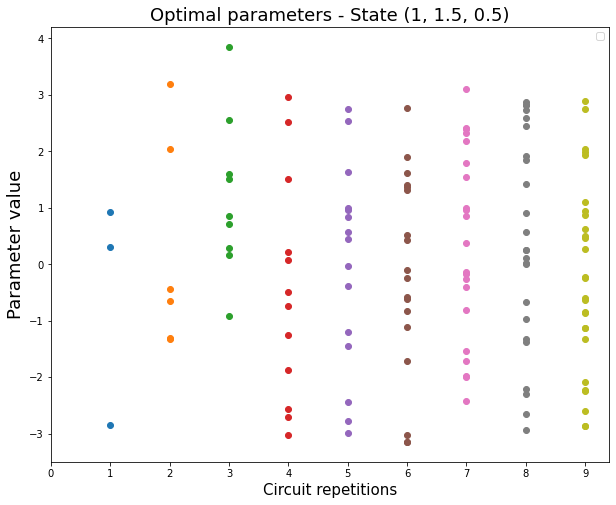

In [30]:
plt.figure(figsize=(10,8))
for iel,el in enumerate(opt_pnt):
    plt.scatter([iel+1]*len(el),el)
plt.title("Optimal parameters - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit repetitions",fontsize=15)
plt.xticks(np.arange(10))
plt.ylabel("Parameter value",fontsize=18)
plt.legend()

In [31]:
for r in range(1,10):
    print(r," - ",np.round(opt_pnt[r-1],4))

1  -  [ 0.3012 -2.8403  0.921 ]
2  -  [ 2.0423 -1.3252 -0.4394  3.2    -0.6505 -1.2992]
3  -  [ 1.5968  0.7209  3.854   2.5548  0.1685  0.2818 -0.9221  1.5029  0.8532]
4  -  [-2.7151 -0.4852  2.9615  0.0833 -2.5681  1.5107  0.2191 -0.7424  2.5191
 -1.8703 -3.0252 -1.2614]
5  -  [-1.4528  2.7517  0.9566  0.8282 -0.0379  2.5431 -1.1967  1.6357 -2.7802
 -0.3848  0.5624  0.4432 -2.9973  0.9877 -2.4492]
6  -  [ 2.76    1.3767 -3.1502 -0.5883 -3.0324 -0.1038 -1.7107  0.5117 -1.1197
  1.9042 -0.8234 -3.143   1.6078  1.3146  1.3963 -0.6175  0.4352 -0.2504]
7  -  [ 3.1047 -1.972   0.8619 -0.1748  1.0018 -0.2555 -2.4297 -0.3951 -1.53
  1.7941 -1.7224  2.3983 -0.816   2.324   2.186  -1.9982 -0.1362  1.5401
  0.9606  0.3727  2.4115]
8  -  [-1.3849  1.8487  0.0071  0.2583 -1.3236  2.455   2.8756  2.7312 -0.9778
  2.8293  1.9118 -2.2092  0.8997 -2.2931  0.0219  0.5743  2.8145  1.4245
  0.2481 -0.6732 -2.9389  2.5906  0.1167 -2.6524]
9  -  [-2.8613 -0.6024 -1.1385  1.9825 -2.0812 -0.6361 -0.2262 -2.2

As we can see in the case of $2$ repetitions, even if we have $6$ different parameters only $3$ are independent.

Text(0, 0.5, '$|\\langle \\psi_{ideal}|\\psi_{VQE} \\rangle |^2$')

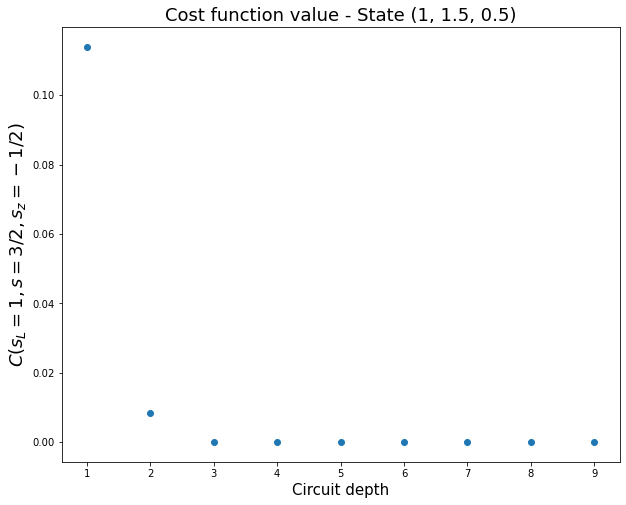

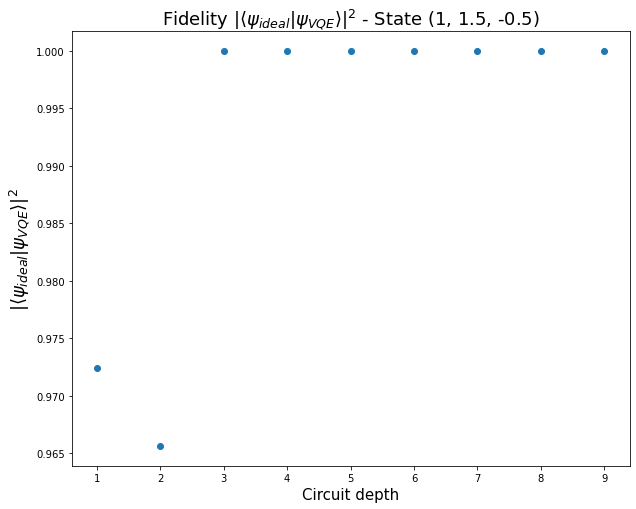

In [32]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[5]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

**Observation**
- Are the bad results of `EvolVarForm`,`EvolVarForm2`, `EvolVarForm4` connected with the use of `Gradient` inside `find_minimum`? Probably we have to use an "handmade" gradient of the cost function to look at the results of the previous VQE optmizations (same thing we made with QASM simulations).

For more information about how the gradient is involved into the optimization look at:

- https://qiskit.org/documentation/_modules/qiskit/aqua/components/optimizers/optimizer.html#Optimizer 

- https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.OptimizerSupportLevel.html

- https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.DIRECT_L_RAND.html#qiskit.aqua.components.optimizers.DIRECT_L_RAND.gradient_support_level

# Use of `grad_spin_cost`

Better to run on INDACO cluster.

In [7]:
def spin_cost(x):
    # Here we convert the circuit corresponding to the variational state into a vector
    circ=var_form.construct_circuit(x)         # To use with so4 and other VariationalForms
    #circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
    v=CircuitStateFn(circ).to_matrix()

    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v) - l[0]*(l[0]+1))**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_s2),v) - l[1]*(l[1]+1))**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_sz),v) - l[2])**2
    return op1+op2+op3
        

def grad_spin_cost(x):
    circ = var_form.construct_circuit(x)
    v    = CircuitStateFn(circ).to_matrix()
    
    # Expectation values computed with matrices, namely as STATEVECTOR 
    # (See the difference w.r.t. the case with QASM)
    f1=np.dot(np.dot(np.conjugate(v),mat_sl2),v)
    f2=np.dot(np.dot(np.conjugate(v),mat_s2),v)
    f3=np.dot(np.dot(np.conjugate(v),mat_sz),v)
    
    # Here we create the dictionary which associates at each Parameter the corresponding value
    pv=ParameterVector("th",var_form.num_parameters)
    par={pv[i] : x[i] for i in range(len(pv))}
    var_form2=var_form.construct_circuit(pv)
    
    # Gradients
    state_grad1=grad.convert(operator=~StateFn(op_sl2) @ CircuitStateFn(primitive=var_form2),params=pv)
    state_grad2=grad.convert(operator=~StateFn(op_s2) @ CircuitStateFn(primitive=var_form2),params=pv)
    state_grad3=grad.convert(operator=~StateFn(op_sz) @ CircuitStateFn(primitive=var_form2),params=pv)

    g1=[np.real(el) for el in state_grad1.assign_parameters(par).eval()]
    g2=[np.real(el) for el in state_grad2.assign_parameters(par).eval()]
    g3=[np.real(el) for el in state_grad3.assign_parameters(par).eval()]
    
    grad_val=[]
    for i in range(len(g1)):
        grad_val.append(2*(f1-l[0]*(l[0]+1))*g1[i] + 2*(f2-l[1]*(l[1]+1))*g2[i] + 2*(f3-l[2])*g3[i])
    
    return grad_val

In [8]:
# Conversion from WeightedPauliOperator function to SummedOp
op_sl2=SummedOp(sl2.to_opflow().to_pauli_op())
op_s2=SummedOp(s2.to_opflow().to_pauli_op())
op_sz=SummedOp(sz.to_opflow().to_pauli_op())

### `EvolVarForm5`  ($1$ parameter  for $R_{xx}$, $1$ for  $R_{yy}$, $1$ for $R_{zz}$)

In [12]:
def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

# Initial states psi(0)
vec=np.kron([1,0],np.real(np.dot(Operator(two_spin(1,0)).data,[1,0,0,0])))
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=6))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[0.         0.70710678 0.70710678 0.         0.         0.
 0.         0.        ]


Example of the circuit

     ┌────────────┐                        ┌───┐┌────────────┐┌───┐»
q_0: ┤ U(π/4,0,0) ├────────────────────────┤ X ├┤ U(π/4,0,0) ├┤ X ├»
     ├────────────┤┌───┐┌────────────┐┌───┐└─┬─┘└────────────┘└─┬─┘»
q_1: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├──■──────────────────┼──»
     └────────────┘└─┬─┘└────────────┘└─┬─┘                     │  »
q_2: ────────────────■──────────────────■───────────────────────■──»
                                                                   »
«     ┌────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U(π/4,0,0) ├┤ X ├┤ U(π/4,0,0) ├┤ X ├┤0             ├┤0             ├»
«     └────────────┘└─┬─┘└────────────┘└─┬─┘│              ││              │»
«q_1: ────────────────■──────────────────┼──┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├»
«                                        │  │              ││              │»
«q_2: ───────────────────────────────────■──┤1             ├┤1             ├»
«                                           └────

#### VQE algorithm

We look for optimal cost function value for several repetitions of the circuit above.

In [14]:
from qiskit.aqua.operators.gradients import Gradient
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

# Definition of the Gradient
grad = Gradient("param_shift")

# Definition of state label
l = lab_list[6]

min_val=[]
for r in range(1,10):
    print("Repetitions: ",r)
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0) 
    algo = VQE(s2, var_form, CG(maxiter=50,gtol=1e-07))

    if r==1:
        min_val.append(algo.find_minimum(cost_fn=spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad_spin_cost))
    else:
        opt_pt=[]
        for el in min_val[r-2]['optimal_point']:
            opt_pt.append(el)
        # We add 3 parameters (equal to 0) 
        for j in range(3):
            opt_pt.append(0.)
        min_val.append(algo.find_minimum(initial_point=opt_pt,cost_fn=spin_cost, optimizer=CG(maxiter=70,gtol=1e-15),gradient_fn=grad_spin_cost))

2021-04-19 18:34:44,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  2.25 * III,
  0.5 * IXX,
  0.5 * XIX,
  0.5 * XXI,
  0.5 * IYY,
  0.5 * YIY,
  0.5 * YYI,
  0.5 * IZZ,
  0.5 * ZIZ,
  0.5 * ZZI
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fed3a8809a0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fed33b56550>>
-- initial_point: Random seed
-- var_form: <__main__.EvolVarForm5 object at 0x7fed3a971370>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]']
-- parameterized_circuits: None
-- ret: None
-- eval_time: None
-- callback: None
-- aux_op_nones: []
-- aux_operators: []
-- eval_count: 

Repetitions:  1


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


KeyboardInterrupt: 

In [ ]:
opt_c=[]
fid=[]
for r in range(1,10):
    print("Depth = ",r)
    var_form  = EvolVarForm5(num_qubits=3, reps=r, connections='full', initial_state=psi_0)
    opt_c.append(min_val[r-1]['optimal_value'])
    print("Optimal cost: ",min_val[r-1]['optimal_value'])
    #print("Optimal parameter: ",min_val[r-1]['optimal_point'][0])
    #best_circ=var_form.assign_parameters(np.real(min_val[r-1]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_circ=var_form.construct_circuit(np.real(min_val[r-1]['optimal_point']))         # To use with VariationalForm
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # We imagine to rotate each state of the phase angle correspondent, namely we compute the square of the absolute value
    best_psi_rot=[]
    for iv in best_psi:
        if np.real(iv)>0:
            best_psi_rot.append(np.sqrt(np.real(iv)**2+np.imag(iv)**2))
        else:
            best_psi_rot.append(-np.sqrt(np.real(iv)**2+np.imag(iv)**2))

    # The best state
    print("| optimal state > =",to_ket(best_psi_rot))
    #print("< optimal | optimal > = ",np.dot(np.conjugate(to_state(np.real(best_psi_rot))),to_state(np.real(best_psi_rot))))
    int_prod=np.dot(np.conjugate(eig_3spins[6]),to_state(np.real(best_psi_rot)))
    fid.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal | optimal >|^2 = ",np.conjugate(int_prod)*int_prod,"\n")

In [ ]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),opt_c)
plt.title("Cost function value - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$C(s_L=1,s=3/2,s_z=-1/2)$",fontsize=18)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(1,10),fid)
plt.title(r"Fidelity $|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$ - State "+str(lab_list[6]),fontsize=18)
plt.xlabel(r"Circuit depth",fontsize=15)
plt.ylabel(r"$|\langle \psi_{ideal}|\psi_{VQE} \rangle |^2$",fontsize=18)

In [10]:
qc = QuantumCircuit(2)
qc.rxx(np.pi/5,0,1)
print(qc.draw())
qg = qc.to_gate()
print(type(qiskit.quantum_info.TwoQubitBasisDecomposer(qg,euler_basis='XYX')))

     ┌───────────┐
q_0: ┤0          ├
     │  RXX(π/5) │
q_1: ┤1          ├
     └───────────┘
<class 'qiskit.quantum_info.synthesis.two_qubit_decompose.TwoQubitBasisDecomposer'>


## Analysis of scalability with VQE

We have to consider the two methods: **RY** and **time evolution** variational forms.

### Depth and number of CNOTs 

#### RY Variational form

If $r (r>1)$ is the number of repetitions (number of RY layers), $N_{CNOT}$ the number of CNOTs, $d$ the depth of the circuit, $n$ the number of qubits and if we suppose that the entanglement structure is linear: 

$$ N_{CNOT} = (n-1)(r-1) \quad d = r + 2(r-1) = 3r-2$$

#### Time evolution variational form

In this case we have to consider that we have made a Trotterization of the time evolution Heisenberg Hamiltonian. This Hamiltonian consider all the couples of $n$ spins, therefore it involves a number of terms equal to the combination of $n$ terms in $2$ places, $C_{n,2} = n(n-1)/2$. Each term can be described with the product of three terms given by $R_{xx}$, $R_{yy}$ and $R_{zz}$.  From *Cross et al., arXiv:1811.12926 [quant-ph]* we know that each exponential circuit on $2$ qubits can be described with at most $3$ CNOTs. Besides, the number of CNOTs of the initial state are always fixed.

$$ N_{CNOT} \propto 9n^2$$

We know study the depth of this time evolution circuit by transpiling first the two-qubit gates rotations  into single qubit gates (device `ibmq_athens`).

In [16]:
IBMQ.load_account()                                                  # connettersi a IBMQ
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubit, lineare, buono
#device   = provider.get_backend('ibmq_5_yorktown')                   # 5 qubit, papillon, medio
#device   = provider.get_backend('ibmq_16_melbourne')                 # 16 qubit, "ladder", cattivo
backend  = Aer.get_backend('qasm_simulator') 

qc = QuantumCircuit(2)
qc.rxx(np.pi/5,0,1)
trans_qc = transpile(qc,device,optimization_level=3,initial_layout=[0,1])
print("Transpiled RXX")
print(trans_qc.draw())
print("Depth of RXX: ",trans_qc.depth())

qc = QuantumCircuit(2)
qc.ryy(np.pi/5,0,1)
trans_qc = transpile(qc,device,optimization_level=3,initial_layout=[0,1])
print("Transpiled RYY")
print(trans_qc.draw())
print("Depth of RYY: ",trans_qc.depth())

qc = QuantumCircuit(2)
qc.rzz(np.pi/5,0,1)
trans_qc = transpile(qc,device,optimization_level=3,initial_layout=[0,1])
print("Transpiled RZZ")
print(trans_qc.draw())
print("Depth of RZZ: ", trans_qc.depth())

ibmqfactory.load_account:WARNING:2021-04-30 16:52:54,570: Credentials are already in use. The existing account in the session will be replaced.


Transpiled RXX
global phase: -75.2557042271200
                ┌───────┐ ┌────┐┌──────────┐┌────┐┌──────────┐     »
      q_0 -> 0 ─┤ RZ(π) ├─┤ √X ├┤ RZ(3π/2) ├┤ √X ├┤ RZ(7π/2) ├──■──»
               ┌┴───────┴┐├────┤├──────────┤├────┤├──────────┤┌─┴─┐»
      q_1 -> 1 ┤ RZ(0.0) ├┤ √X ├┤ RZ(3π/2) ├┤ √X ├┤ RZ(5π/2) ├┤ X ├»
               └─────────┘└────┘└──────────┘└────┘└──────────┘└───┘»
ancilla_0 -> 2 ────────────────────────────────────────────────────»
                                                                   »
ancilla_1 -> 3 ────────────────────────────────────────────────────»
                                                                   »
ancilla_2 -> 4 ────────────────────────────────────────────────────»
                                                                   »
«               ┌──────────────────────┐┌────┐ ┌────────┐ ┌────┐»
«      q_0 -> 0 ┤ RZ(2.97965962969549) ├┤ √X ├─┤ RZ(2π) ├─┤ √X ├»
«               └────┬───────────┬─────┘├────┤┌┴────────┴┐├───

We have that the depth of a circuit with following $R_{xx}$, $R_{yy}$ and $R_{zz}$ is given by $37$. In each repetion of the circuit we have at most $(n-1)$ sets of $\{R_{xx},R_{yy},R_{zz}\}$. The overall depth of the time evolution circuit with fixed number of repetitions $r$ is given by the following formula. We neglect the depth associated with the initial state gates.

$$ d \approx 37r(n-1)$$


### What about the convergence rate?

We have to remind that the circuits above are inside the VQE algorithm and we are interested also into the description of the convergence to the minimum of the spin cost function. To do that we need to know the iteration steps (and the evaluation steps) needed to find the minimum. From [1] we know that the CG (Conjugate Gradient) optimizer uses the nonlinear gradient algorithm by Polak and Ribiere. In the case of minimization of a given operator $A$ the CG optimization will terminate at the solution after a number of steps equal to the number of eigenvalues of $A$ (**Theorem 5.4**, [2]). In the case of a generic cost function $f$ **Theorem 5.7** ([2]) guarantees under specific conditions that:

$$\liminf_{k \to \infty} |\nabla f_k | = 0 $$


[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#rdd2e1855725e-5

[2] *Nocedal, Wright - Numerical Optimization*


For a deep understanding we also need to know the time for the gradient evaluation.

**Question** Because of the difficulty in finding the number of convergence steps by analytical analysis, shouldn't we use a practical approach to give an estimate of the convergence rate?